"The Hit By Pitch Classifier"

# Introduction / Data Science Problem

The Open Source Hit By Pitch Database was conceived by Rob Mains of *Baseball Prospectus*, and opened to the world in an article on April 14, 2020. [Veteran Presence: The Open Source Hit By Pitch Database](https://www.baseballprospectus.com/news/article/58297/veteran-presence-the-open-source-hit-by-pitch-database/?utm_source=Baseball+Prospectus&utm_campaign=37494e2b6c-2020-04-14+Baseball+Prospectus+Premium+Newsletter&utm_medium=email&utm_term=0_1613350d6d-37494e2b6c-369464685). The database consists of every hit-by-pitch event in Major League Baseball since 1969 (there are over 62,000 of them!).

In Rob's words: 
> The point here, though, isn’t for me to show you some numbers. It’s for you to generate some of your own. I’m a guy whose programming skills don’t extend beyond nested IFs and VLOOKUPs in Excel. I know many of you can do much better. So we’re opening up our spreadsheet, all 1.677 million cells of it to you. Download it. See what you can make of it.

As a data scientist and avid sports fan, this dataset appeals to me. It's a quirky side of baseball that typically isn't covered very much by the sabermetric community, and its size lends itself to some interesting analysis, exploratory like Rob started, but perhaps there's something more here. With baseball on an indefinite hiatus, this project will help me stay engaged with the sport as well.

My plan is to use this database as the source for some advanced machine learning, starting with **unsupervised learning** to see whether certain underlying "HBP archetypes" exist - **are there common characteristics that lend themselves to creating groups or types of HBP events?** Do these typologies help tell a more interesting story? 

As there are three "scoresheet epochs" in the dataset, it will be necessary to analyze the data using a pattern submodel method due to the systematic missingness of HBP event information in each of the epochs. Those epochs are:

|Scoresheet Epoch|Years|# of Events|<p align="left">Data</p>|
|---|---|---|---|
|Old School Scoresheets|1969-1987|14,101|<p align="left">No balls & strikes nor pitch types/velocities recorded</p>|
|Project Scoresheet|1988-2007|28,056|<p align="left">Balls & strikes recorded, but not pitch types/velocities</p>|
|PITCHf/x Years|2008-present|19,969|<p align="left">All pitch information recorded (though perhaps not perfectly accurately, especially in the early years of this period)</p>|

While the Project Scoresheet era actually kicked off in 1984, the new balls and strikes data doesn't appear in the database until 1988. It's still the best initial moniker for the era that I could come up with.

The plan is to start with segmenting the PITCHf/x Epoch data, and then work backwards. I can then try to see if there are common segment characteristics that exist in each era, even if some data is missing. I'm not sure whether I'll have time to incorporate this into this capstone project, but my ultimate goal is to **create a HBP Typing Tool so new HBP events can be classified on the fly** - the basis of this classification will be a machine learning classifier (gradient boosting machine or other similar model).

# Executive Summary

# Imports

In [ ]:
# If not already installed, install these packages, which will be required for the unsupervised learning
# portion of the project
# !pip install hdbscan
# !pip install distython
# !pip install xgboost
# xgboost may require libomp if not previously installed on MacOS - use brew install libomp

In [527]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import requests
from lxml import html
from bs4 import BeautifulSoup
import re
from urllib.parse import urlparse, parse_qs

from openpyxl import load_workbook

from datetime import datetime

# from sklearn.preprocessing import OneHotEncoder

from hdbscan import HDBSCAN
from distython import HEOM
from sklearn.manifold import TSNE

from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

import pickle 

In [5]:
pd.set_option('display.max_columns', 30)

# Get Data

## Open Baseball Prospectus HBP Database

In [3]:
# v03 of the database includes three formerly-missing HBP events that were uncovered
# from a comparison with Stathead data over the same time period
df = pd.read_csv("../data/Baseball Prospectus HBP Database v03.csv", dtype={"PITCH_TYPE": object})
df.head()

,DATE,WIN_TEAM,PIT_ID,PITCHER,PIT_TEAM,THROWS,BAT_ID,BATTER,BAT_TEAM,BATS,POSITION,LINEUP_SPOT,BAT_TEAM_SCORE,FLD_TEAM_SCORE,BASES_STATE,HALF,INNING,OUTS_CT,BALLS,STRIKES,PITCH_TYPE,VELOCITY,PIT_REMOVED,BAT_REMOVED,PIT_EJECTED,BAT_EJECTED,UMPIRE,EJECTIONS_CT,EJECTIONS_PL,EJECTION_DES
0,4/7/1969,ATL,23911,Pat Jarvis,ATL,R,23773,Ron Hunt,SFN,R,4,2,1,3,___,Top,6,0,NaN,NaN,NaN,NaN,N,N,N,N,Ken Burkhart,0,NaN,NaN
1,4/8/1969,ATL,27356,Gaylord Perry,SFN,R,26172,Felix Millan,ATL,R,4,2,0,1,__3,Bot,1,0,NaN,NaN,NaN,NaN,N,N,N,N,Ed Sudol,0,NaN,NaN
2,4/8/1969,ATL,26807,Phil Niekro,ATL,R,21692,Bobby Etheridge,SFN,R,5,7,2,3,___,Top,4,1,NaN,NaN,NaN,NaN,N,N,N,N,Ed Sudol,0,NaN,NaN
3,4/8/1969,BOS,29297,Lee Stange,BOS,R,21690,Andy Etchebarren,BAL,R,2,7,1,2,___,Bot,5,1,NaN,NaN,NaN,NaN,N,N,N,N,Hank Soar,0,NaN,NaN
4,4/8/1969,BOS,24764,Bill Landis,BOS,L,21690,Andy Etchebarren,BAL,R,2,7,4,4,___,Bot,11,0,NaN,NaN,NaN,NaN,N,N,N,N,Hank Soar,0,NaN,NaN


In [4]:
df.tail()

,DATE,WIN_TEAM,PIT_ID,PITCHER,PIT_TEAM,THROWS,BAT_ID,BATTER,BAT_TEAM,BATS,POSITION,LINEUP_SPOT,BAT_TEAM_SCORE,FLD_TEAM_SCORE,BASES_STATE,HALF,INNING,OUTS_CT,BALLS,STRIKES,PITCH_TYPE,VELOCITY,PIT_REMOVED,BAT_REMOVED,PIT_EJECTED,BAT_EJECTED,UMPIRE,EJECTIONS_CT,EJECTIONS_PL,EJECTION_DES
62124,9/29/2019,CHA,100959,Victor Alcantara,DET,R,105432,Yoan Moncada,CHA,L,5,4,5,2,___,Bot,8,1,1.0,0.0,CH,90.7,N,N,N,N,Gabe Morales,0,NaN,NaN
62125,9/29/2019,COL,71331,Sam Howard,COL,L,69600,Orlando Arcia,MIL,R,6,7,3,0,_2_,Top,6,2,0.0,1.0,FA,92.4,N,N,N,N,Tripp Gibson,0,NaN,NaN
62126,9/29/2019,COL,100720,Yency Almonte,COL,R,102700,Jacob Nottingham,MIL,R,11,1,3,3,_23,Top,11,0,1.0,0.0,FA,97.7,Y,N,N,N,Tripp Gibson,0,NaN,NaN
62127,9/29/2019,KCA,70464,Jorge Lopez,KCA,R,67574,Miguel Sano,MIN,R,10,3,4,3,___,Top,6,1,3.0,2.0,CH,86.9,N,N,N,N,John Libka,0,NaN,NaN
62128,9/29/2019,SLN,100576,Duane Underwood Jr.,CHN,R,105846,Paul DeJong,SLN,R,6,7,8,0,___,Bot,3,0,0.0,0.0,CU,77.8,N,N,N,N,Doug Eddings,0,NaN,NaN


In [5]:
df.shape

(62129, 30)

In [6]:
df.columns

Index(['DATE', 'WIN_TEAM', 'PIT_ID', 'PITCHER', 'PIT_TEAM', 'THROWS', 'BAT_ID',
       'BATTER', 'BAT_TEAM', 'BATS', 'POSITION', 'LINEUP_SPOT',
       'BAT_TEAM_SCORE', 'FLD_TEAM_SCORE', 'BASES_STATE', 'HALF', 'INNING',
       'OUTS_CT', 'BALLS', 'STRIKES', 'PITCH_TYPE', 'VELOCITY', 'PIT_REMOVED',
       'BAT_REMOVED', 'PIT_EJECTED', 'BAT_EJECTED', 'UMPIRE', 'EJECTIONS_CT',
       'EJECTIONS_PL', 'EJECTION_DES'],
      dtype='object')

In [7]:
df.dtypes

DATE               object
WIN_TEAM           object
PIT_ID              int64
PITCHER            object
PIT_TEAM           object
THROWS             object
BAT_ID              int64
BATTER             object
BAT_TEAM           object
BATS               object
POSITION            int64
LINEUP_SPOT         int64
BAT_TEAM_SCORE      int64
FLD_TEAM_SCORE      int64
BASES_STATE        object
HALF               object
INNING              int64
OUTS_CT             int64
BALLS             float64
STRIKES           float64
PITCH_TYPE         object
VELOCITY          float64
PIT_REMOVED        object
BAT_REMOVED        object
PIT_EJECTED        object
BAT_EJECTED        object
UMPIRE             object
EJECTIONS_CT        int64
EJECTIONS_PL       object
EJECTION_DES       object
dtype: object

### Create HALF_INNING variable for merge purposes

In [8]:
df["HALF_INNING"] = df["HALF"].str[:1].str.lower() + df["INNING"].astype(str)

In [9]:
df["HALF_INNING"].value_counts()

b1     3927
b7     3761
b8     3721
b6     3649
t7     3558
b3     3557
t8     3516
t1     3471
b4     3463
b2     3447
b5     3428
t2     3331
t6     3328
t3     3323
t9     3264
t4     3246
t5     3196
b9     1587
t10     324
b10     289
t11     188
b11     167
t12      92
b12      85
b13      63
t13      51
t14      22
b14      18
b15      14
t15      14
b16       8
t17       6
t16       6
t18       3
t19       2
t20       1
b17       1
b20       1
b22       1
Name: HALF_INNING, dtype: int64

### Combine franchises

In [10]:
df["WIN_TEAM"].value_counts()

BOS    2684
NYA    2490
CHA    2320
HOU    2319
SLN    2296
PIT    2284
PHI    2269
CLE    2252
OAK    2251
MIN    2185
TEX    2160
TOR    2151
CIN    2140
MIL    2135
KCA    2124
CHN    2106
SFN    2093
LAN    2087
DET    2079
BAL    2055
NYN    2051
ATL    1990
SEA    1939
SDN    1771
COL    1371
MON    1344
ANA    1291
TBA    1269
ARI    1146
FLO    1045
CAL     980
WAS     820
MIA     379
TIE     121
WS2     101
SE1      31
Name: WIN_TEAM, dtype: int64

In [11]:
df["PIT_TEAM"].value_counts()

BOS    2570
TEX    2382
PIT    2323
CHA    2322
DET    2247
PHI    2246
CLE    2240
KCA    2209
CHN    2207
MIL    2182
SLN    2179
HOU    2172
OAK    2149
CIN    2118
TOR    2106
SEA    2105
MIN    2059
NYA    2057
NYN    2041
SFN    2019
BAL    1977
SDN    1958
LAN    1934
ATL    1845
COL    1575
MON    1452
TBA    1360
ANA    1244
ARI    1232
CAL    1089
FLO    1017
WAS     858
MIA     500
WS2     108
SE1      47
Name: PIT_TEAM, dtype: int64

In [12]:
df["BAT_TEAM"].value_counts()

PIT    2466
BOS    2373
CHA    2351
MIL    2349
NYA    2348
HOU    2323
OAK    2284
PHI    2248
MIN    2239
CLE    2228
BAL    2219
KCA    2199
CIN    2193
SLN    2145
TOR    2142
TEX    2116
NYN    2094
DET    2082
CHN    2070
SFN    2043
LAN    1978
ATL    1916
SEA    1908
SDN    1846
MON    1400
TBA    1333
COL    1326
ANA    1244
FLO    1124
ARI    1109
CAL     986
WAS     875
MIA     432
WS2     106
SE1      34
Name: BAT_TEAM, dtype: int64

**NOTE** Combine the following teams, which relocated (or changed names) at one point to become current team:
- Seattle Pilots (SE1) became the Milwaukee Brewers (MIL) in 1970
- Washington Senators (WS2) became the Texas Rangers (TEX) in 1972
- California Angels (CAL) became the Anaheim Angels (ANA) in 1997
- Montreal Expos (MON) became the Washington Nationals (WAS) in 2004
- Florida Marlins (FLO) became the Miami Marlins (MIA) in 2011

This is consistent with how Stathead categorizes HBP events in its database [Stathead](https://stathead.com/baseball/event_finder.cgi?request=1&year=1969&year_to=2019&divisory=1&from=button&type=b&event=16), and it will be necessary to have both data sources match in terms of team names used before I can merge them.

In [13]:
bp_team_dict = {
    "SE1": "MIL",
    "WS2": "TEX",
    "CAL": "ANA",
    "MON": "WAS",
    "FLO": "MIA"
}

df["WIN_TEAM"].replace(bp_team_dict, inplace=True)

df["PIT_TEAM"].replace(bp_team_dict, inplace=True)

df["BAT_TEAM"].replace(bp_team_dict, inplace=True)

In [14]:
df["WIN_TEAM"].value_counts()

BOS    2684
NYA    2490
CHA    2320
HOU    2319
SLN    2296
PIT    2284
ANA    2271
PHI    2269
TEX    2261
CLE    2252
OAK    2251
MIN    2185
MIL    2166
WAS    2164
TOR    2151
CIN    2140
KCA    2124
CHN    2106
SFN    2093
LAN    2087
DET    2079
BAL    2055
NYN    2051
ATL    1990
SEA    1939
SDN    1771
MIA    1424
COL    1371
TBA    1269
ARI    1146
TIE     121
Name: WIN_TEAM, dtype: int64

In [15]:
df["PIT_TEAM"].value_counts()

BOS    2570
TEX    2490
ANA    2333
PIT    2323
CHA    2322
WAS    2310
DET    2247
PHI    2246
CLE    2240
MIL    2229
KCA    2209
CHN    2207
SLN    2179
HOU    2172
OAK    2149
CIN    2118
TOR    2106
SEA    2105
MIN    2059
NYA    2057
NYN    2041
SFN    2019
BAL    1977
SDN    1958
LAN    1934
ATL    1845
COL    1575
MIA    1517
TBA    1360
ARI    1232
Name: PIT_TEAM, dtype: int64

In [16]:
df["BAT_TEAM"].value_counts()

PIT    2466
MIL    2383
BOS    2373
CHA    2351
NYA    2348
HOU    2323
OAK    2284
WAS    2275
PHI    2248
MIN    2239
ANA    2230
CLE    2228
TEX    2222
BAL    2219
KCA    2199
CIN    2193
SLN    2145
TOR    2142
NYN    2094
DET    2082
CHN    2070
SFN    2043
LAN    1978
ATL    1916
SEA    1908
SDN    1846
MIA    1556
TBA    1333
COL    1326
ARI    1109
Name: BAT_TEAM, dtype: int64

### Convert date to datetime object, and create Month/Day/Year variables

In [17]:
# Convert date to datetime object
df["DATE"] = pd.to_datetime(df["DATE"], infer_datetime_format=True)
df.head()

,DATE,WIN_TEAM,PIT_ID,PITCHER,PIT_TEAM,THROWS,BAT_ID,BATTER,BAT_TEAM,BATS,POSITION,LINEUP_SPOT,BAT_TEAM_SCORE,FLD_TEAM_SCORE,BASES_STATE,...,INNING,OUTS_CT,BALLS,STRIKES,PITCH_TYPE,VELOCITY,PIT_REMOVED,BAT_REMOVED,PIT_EJECTED,BAT_EJECTED,UMPIRE,EJECTIONS_CT,EJECTIONS_PL,EJECTION_DES,HALF_INNING
0,1969-04-07,ATL,23911,Pat Jarvis,ATL,R,23773,Ron Hunt,SFN,R,4,2,1,3,___,...,6,0,NaN,NaN,NaN,NaN,N,N,N,N,Ken Burkhart,0,NaN,NaN,t6
1,1969-04-08,ATL,27356,Gaylord Perry,SFN,R,26172,Felix Millan,ATL,R,4,2,0,1,__3,...,1,0,NaN,NaN,NaN,NaN,N,N,N,N,Ed Sudol,0,NaN,NaN,b1
2,1969-04-08,ATL,26807,Phil Niekro,ATL,R,21692,Bobby Etheridge,SFN,R,5,7,2,3,___,...,4,1,NaN,NaN,NaN,NaN,N,N,N,N,Ed Sudol,0,NaN,NaN,t4
3,1969-04-08,BOS,29297,Lee Stange,BOS,R,21690,Andy Etchebarren,BAL,R,2,7,1,2,___,...,5,1,NaN,NaN,NaN,NaN,N,N,N,N,Hank Soar,0,NaN,NaN,b5
4,1969-04-08,BOS,24764,Bill Landis,BOS,L,21690,Andy Etchebarren,BAL,R,2,7,4,4,___,...,11,0,NaN,NaN,NaN,NaN,N,N,N,N,Hank Soar,0,NaN,NaN,b11


In [18]:
df["MONTH"] = df["DATE"].dt.month
df["MONTH"].value_counts()

8     10814
5     10570
6     10381
7     10294
9     10266
4      9059
10      622
3       123
Name: MONTH, dtype: int64

In [19]:
df["DAY"] = df["DATE"].dt.day
df["DAY"].value_counts()

22    2167
4     2124
20    2103
18    2089
26    2085
7     2082
29    2075
28    2070
1     2069
24    2069
17    2066
8     2054
30    2054
25    2053
21    2048
23    2041
5     2037
19    2027
2     2020
27    2018
14    1992
10    1991
6     1991
11    1983
3     1981
9     1976
15    1975
16    1954
12    1930
13    1882
31    1123
Name: DAY, dtype: int64

In [20]:
df["YEAR"] = df["DATE"].dt.year
df["YEAR"].value_counts()

2019    1984
2018    1922
2001    1890
2004    1850
2003    1849
2006    1817
2005    1797
2017    1763
2007    1755
2002    1746
2008    1672
2014    1652
2016    1651
2015    1602
2009    1590
1998    1587
1999    1579
2000    1573
2011    1554
2010    1549
2013    1536
2012    1494
1997    1449
1996    1404
1995    1219
1993    1200
1992     980
1988     918
1991     905
1969     882
1994     876
1990     861
1987     842
1970     825
1971     819
1986     812
1989     801
1977     791
1974     774
1978     772
1975     761
1973     755
1979     754
1972     751
1983     717
1985     699
1976     684
1982     677
1984     668
1980     657
1981     464
Name: YEAR, dtype: int64

In [21]:
df.shape

(62129, 34)

### Split first, last names, remove suffixes for merge purposes

In [22]:
df[["PIT_FIRST", "PIT_LAST"]] = df["PITCHER"].str.split(" ", n=1, expand=True)
df[["BAT_FIRST", "BAT_LAST"]] = df["BATTER"].str.split(" ", n=1, expand=True)

In [23]:
df["BAT_LAST"].value_counts()

Johnson       505
Gonzalez      467
Rodriguez     407
Jones         401
Ramirez       393
             ... 
Tauchman        1
Winchester      1
Person          1
Monell          1
Gott            1
Name: BAT_LAST, Length: 2669, dtype: int64

In [24]:
def suff_replace(x):
    match = re.sub(r'Jr.|Jr|Sr.|Sr|I|II|III|IV$',"",x)
    return match

df["BAT_LAST"] = df["BAT_LAST"].apply(suff_replace).str.strip()
df["PIT_LAST"] = df["PIT_LAST"].apply(suff_replace).str.strip()

#### Fix name discrepancies

In [25]:
df["PIT_FIRST"] = df["PIT_FIRST"].str.replace("La", "La Marr")
df["PIT_LAST"] = df["PIT_LAST"].str.replace("Marr Hoyt", "Hoyt")

In [26]:
df[df["PIT_LAST"] == "Hoyt"]

,DATE,WIN_TEAM,PIT_ID,PITCHER,PIT_TEAM,THROWS,BAT_ID,BATTER,BAT_TEAM,BATS,POSITION,LINEUP_SPOT,BAT_TEAM_SCORE,FLD_TEAM_SCORE,BASES_STATE,...,BAT_REMOVED,PIT_EJECTED,BAT_EJECTED,UMPIRE,EJECTIONS_CT,EJECTIONS_PL,EJECTION_DES,HALF_INNING,MONTH,DAY,YEAR,PIT_FIRST,PIT_LAST,BAT_FIRST,BAT_LAST
8892,1980-06-30,ANA,23701,La Marr Hoyt,CHA,R,18897,Don Baylor,ANA,R,7,4,3,5,1__,...,N,N,N,Greg Kosc,0,NaN,NaN,t5,6,30,1980,La Marr,Hoyt,Don,Baylor
9217,1980-10-04,CHA,23701,La Marr Hoyt,CHA,R,22753,Bobby Grich,ANA,R,4,6,1,0,1__,...,N,N,N,George Maloney,0,NaN,NaN,t4,10,4,1980,La Marr,Hoyt,Bobby,Grich
9346,1981-05-08,CHA,23701,La Marr Hoyt,CHA,R,17999,Willie Wilson,KCA,L,7,1,5,9,_2_,...,N,N,N,Larry Barnett,0,NaN,NaN,t8,5,8,1981,La Marr,Hoyt,Willie,Wilson
9394,1981-05-18,CHA,23701,La Marr Hoyt,CHA,R,25658,John Mayberry,TOR,L,3,6,2,7,1__,...,Y,N,N,George Maloney,0,NaN,NaN,b9,5,18,1981,La Marr,Hoyt,John,Mayberry
9455,1981-06-03,OAK,23701,La Marr Hoyt,CHA,R,1325,Rickey Henderson,OAK,R,7,1,5,2,1__,...,N,N,N,Ken Kaiser,0,NaN,NaN,t9,6,3,1981,La Marr,Hoyt,Rickey,Henderson
9739,1982-04-18,CHA,23701,La Marr Hoyt,CHA,R,20947,Rich Dauer,BAL,R,5,2,4,4,___,...,N,N,N,Vic Voltaggio,0,NaN,NaN,t7,4,18,1982,La Marr,Hoyt,Rich,Dauer
10180,1982-08-19,KCA,23701,La Marr Hoyt,CHA,R,26014,Hal McRae,KCA,R,10,3,0,0,_2_,...,N,N,N,Rich Garcia,0,NaN,NaN,b1,8,19,1982,La Marr,Hoyt,Hal,McRae
10903,1983-08-17,CHA,23701,La Marr Hoyt,CHA,R,18168,Dave Winfield,NYA,R,7,3,0,2,1__,...,N,N,N,Rick Reed,0,NaN,NaN,b7,8,17,1983,La Marr,Hoyt,Dave,Winfield
11130,1984-04-15,NYA,23701,La Marr Hoyt,CHA,R,29092,Keith Smith,NYA,L,6,8,1,1,___,...,N,N,N,Larry Barnett,0,NaN,NaN,b8,4,15,1984,La Marr,Hoyt,Keith,Smith
11263,1984-05-22,KCA,23701,La Marr Hoyt,CHA,R,17999,Willie Wilson,KCA,L,8,1,0,3,___,...,N,N,N,Jim Evans,0,NaN,NaN,b1,5,22,1984,La Marr,Hoyt,Willie,Wilson


In [27]:
# Create function to replace initials that snuck into the last name
def init_replace(x):
    match = re.sub(r'^[A-Za-z]\.\s',"",x)
    return match

In [28]:
df["PIT_LAST"] = df["PIT_LAST"].apply(init_replace)
df["BAT_LAST"] = df["BAT_LAST"].apply(init_replace)

In [29]:
# Check to make sure HBP from 7/22/1987 is not credited to Dale Mohorcic (should be Mitch Williams instead)
df[df["PIT_LAST"] == "Mohorcic"]

,DATE,WIN_TEAM,PIT_ID,PITCHER,PIT_TEAM,THROWS,BAT_ID,BATTER,BAT_TEAM,BATS,POSITION,LINEUP_SPOT,BAT_TEAM_SCORE,FLD_TEAM_SCORE,BASES_STATE,...,BAT_REMOVED,PIT_EJECTED,BAT_EJECTED,UMPIRE,EJECTIONS_CT,EJECTIONS_PL,EJECTION_DES,HALF_INNING,MONTH,DAY,YEAR,PIT_FIRST,PIT_LAST,BAT_FIRST,BAT_LAST
13196,1986-09-21,TEX,26317,Dale Mohorcic,TEX,R,17049,Greg Gagne,MIN,R,6,1,1,2,___,...,N,N,N,Tim Tschida,0,NaN,NaN,t7,9,21,1986,Dale,Mohorcic,Greg,Gagne
13295,1987-04-14,BOS,26317,Dale Mohorcic,TEX,R,18897,Don Baylor,BOS,R,10,5,4,1,___,...,N,N,N,Mike Reilly,0,NaN,NaN,b8,4,14,1987,Dale,Mohorcic,Don,Baylor
13503,1987-05-30,KCA,26317,Dale Mohorcic,TEX,R,17999,Willie Wilson,KCA,L,8,1,12,7,___,...,N,N,N,John Shulock,0,NaN,NaN,b8,5,30,1987,Dale,Mohorcic,Willie,Wilson
14373,1988-05-26,TEX,26317,Dale Mohorcic,TEX,R,19955,Sil Campusano,TOR,R,9,8,7,6,___,...,N,N,N,Don Denkinger,0,NaN,NaN,t8,5,26,1988,Dale,Mohorcic,Sil,Campusano
14478,1988-06-16,ANA,26317,Dale Mohorcic,TEX,R,18208,Dick Schofield,ANA,R,6,2,3,0,123,...,N,N,N,Ken Kaiser,0,NaN,NaN,b8,6,16,1988,Dale,Mohorcic,Dick,Schofield
14545,1988-06-26,CHA,26317,Dale Mohorcic,TEX,R,17235,Ron Karkovice,CHA,R,2,9,7,0,___,...,N,N,N,Jim McKean,0,NaN,NaN,t7,6,26,1988,Dale,Mohorcic,Ron,Karkovice
14633,1988-07-14,MIL,26317,Dale Mohorcic,TEX,R,17401,Paul Molitor,MIL,R,10,1,5,2,123,...,N,N,N,John Hirschbeck,0,NaN,NaN,t6,7,14,1988,Dale,Mohorcic,Paul,Molitor
14814,1988-08-21,MIN,26317,Dale Mohorcic,TEX,R,25144,Steve Lombardozzi,MIN,R,4,9,9,2,1__,...,N,N,N,John Hirschbeck,0,NaN,NaN,b7,8,21,1988,Dale,Mohorcic,Steve,Lombardozzi
14902,1988-09-09,NYA,26317,Dale Mohorcic,NYA,R,24533,Ray Knight,DET,R,3,2,2,2,___,...,N,N,N,Drew Coble,0,NaN,NaN,t9,9,9,1988,Dale,Mohorcic,Ray,Knight
14932,1988-09-16,BOS,26317,Dale Mohorcic,NYA,R,17992,Jody Reed,BOS,R,6,8,7,2,1_3,...,N,N,N,Ted Hendry,0,NaN,NaN,b5,9,16,1988,Dale,Mohorcic,Jody,Reed


In [30]:
# Fix names to be consistent with true player name and to match Stathead
bp_player_dict = {
    "Vangorder": "Van Gorder",
    "Vonohlen": "Von Ohlen",
    "Wayne Buice": "Buice",
    "Antonio Nunez": "Nunez",
    "Dejesus": "DeJesus",
    "Keun Bong": "Bong",
    "Seung Baek": "Baek",
    "VandenHurk": "van den Hurk",
    "DeVries": "De Vries",
    "Lagrow": "LaGrow",
    "Demola": "DeMola",
    "Lacorte": "LaCorte",
    "Lacoss": "LaCoss",
    "Macwhorter": "MacWhorter",
    "Lapoint": "LaPoint",
    "Deleon": "DeLeon",
    "Dipino": "DiPino",
    "Delucia": "DeLucia",
    "Macdonald": "MacDonald",
    "Desilva": "DeSilva",
    "Davanon": "DaVanon",
    "Leflore": "LeFlore",
    "Lacock": "LaCock",
    "Decinces": "DeCinces",
    "Lemaster": "LeMaster",
    "Lavalliere": "LaValliere",
    "Mccarty": "McCarty",
    "Lecroy": "LeCroy",
    "Laforest": "LaForest",
    "Den Dekker": "den Dekker"
}

df["PIT_LAST"].replace(bp_player_dict, inplace=True)
df["BAT_LAST"].replace(bp_player_dict, inplace=True)

In [31]:
df.loc[(df["PITCHER"] == "Luis De Los Santos") & (df["PIT_LAST"] == "De Los Santos"),
       "PIT_LAST"] = "de los Santos"

In [32]:
df[df["PIT_LAST"] == "de los Santos"]

,DATE,WIN_TEAM,PIT_ID,PITCHER,PIT_TEAM,THROWS,BAT_ID,BATTER,BAT_TEAM,BATS,POSITION,LINEUP_SPOT,BAT_TEAM_SCORE,FLD_TEAM_SCORE,BASES_STATE,...,BAT_REMOVED,PIT_EJECTED,BAT_EJECTED,UMPIRE,EJECTIONS_CT,EJECTIONS_PL,EJECTION_DES,HALF_INNING,MONTH,DAY,YEAR,PIT_FIRST,PIT_LAST,BAT_FIRST,BAT_LAST
32402,2002-07-20,TOR,1038,Luis De Los Santos,TBA,R,1024,Chris Woodward,TOR,R,6,6,4,0,_2_,...,N,N,N,Gerry Davis,0,NaN,NaN,b3,7,20,2002,Luis,de los Santos,Chris,Woodward
32403,2002-07-20,TOR,1038,Luis De Los Santos,TBA,R,1015,Shannon Stewart,TOR,R,7,1,4,1,___,...,N,N,N,Gerry Davis,0,NaN,NaN,b4,7,20,2002,Luis,de los Santos,Shannon,Stewart
32404,2002-07-20,TOR,1038,Luis De Los Santos,TBA,R,1004,Josh Phelps,TOR,R,10,7,5,1,_23,...,N,N,N,Gerry Davis,0,NaN,NaN,b5,7,20,2002,Luis,de los Santos,Josh,Phelps


In [33]:
df.loc[(df["PITCHER"] == "Denny Lemaster") & (df["PIT_LAST"] == "LeMaster"), "PIT_LAST"] = "Lemaster"

In [34]:
df[df["PITCHER"] == "Denny Lemaster"]

,DATE,WIN_TEAM,PIT_ID,PITCHER,PIT_TEAM,THROWS,BAT_ID,BATTER,BAT_TEAM,BATS,POSITION,LINEUP_SPOT,BAT_TEAM_SCORE,FLD_TEAM_SCORE,BASES_STATE,...,BAT_REMOVED,PIT_EJECTED,BAT_EJECTED,UMPIRE,EJECTIONS_CT,EJECTIONS_PL,EJECTION_DES,HALF_INNING,MONTH,DAY,YEAR,PIT_FIRST,PIT_LAST,BAT_FIRST,BAT_LAST
469,1969-07-09,SFN,24956,Denny Lemaster,HOU,L,23773,Ron Hunt,SFN,R,4,2,0,3,___,...,N,N,N,Mel Steiner,0,NaN,NaN,b7,7,9,1969,Denny,Lemaster,Ron,Hunt
907,1970-04-13,LAN,24956,Denny Lemaster,HOU,L,21012,Willie Davis,LAN,L,8,3,0,0,___,...,N,N,N,Chris Pelekoudas,0,NaN,NaN,t1,4,13,1970,Denny,Lemaster,Willie,Davis
1228,1970-06-24,HOU,24956,Denny Lemaster,HOU,L,18536,Jose Arcia,SDN,R,6,1,1,5,1__,...,N,N,N,Tom Gorman,0,NaN,NaN,t5,6,24,1970,Denny,Lemaster,Jose,Arcia
2325,1971-08-12,ATL,24956,Denny Lemaster,HOU,L,30827,Earl Williams,ATL,R,2,4,10,1,12_,...,N,N,N,Ed Vargo,0,NaN,NaN,b7,8,12,1971,Denny,Lemaster,Earl,Williams
2572,1972-04-27,WAS,24956,Denny Lemaster,WAS,L,28114,Frank Robinson,LAN,R,9,4,1,4,1__,...,N,N,N,Harry Wendelstedt,0,NaN,NaN,b6,4,27,1972,Denny,Lemaster,Frank,Robinson


In [35]:
df.loc[(df["PITCHER"] == "Francisco Rosario") & (df["PIT_LAST"] == "Rosario"), "PIT_LAST"] = "Del Rosario"

In [36]:
df.loc[(df["PITCHER"] == "Francisco Rosario"), "PITCHER"] = "Francisco Del Rosario"

In [37]:
df[df["PITCHER"] == "Francisco Del Rosario"]

,DATE,WIN_TEAM,PIT_ID,PITCHER,PIT_TEAM,THROWS,BAT_ID,BATTER,BAT_TEAM,BATS,POSITION,LINEUP_SPOT,BAT_TEAM_SCORE,FLD_TEAM_SCORE,BASES_STATE,...,BAT_REMOVED,PIT_EJECTED,BAT_EJECTED,UMPIRE,EJECTIONS_CT,EJECTIONS_PL,EJECTION_DES,HALF_INNING,MONTH,DAY,YEAR,PIT_FIRST,PIT_LAST,BAT_FIRST,BAT_LAST
39373,2006-06-17,MIA,31641,Francisco Del Rosario,TOR,R,44018,Dan Uggla,MIA,R,4,2,8,2,123,...,N,N,N,Hunter Wendelstedt,0,NaN,NaN,b7,6,17,2006,Francisco,Del Rosario,Dan,Uggla
40526,2007-04-14,PHI,31641,Francisco Del Rosario,PHI,R,31322,Chris Burke,HOU,R,8,2,5,7,___,...,N,N,N,Charlie Reliford,0,NaN,NaN,t7,4,14,2007,Francisco,Del Rosario,Chris,Burke
40993,2007-06-01,SFN,31641,Francisco Del Rosario,PHI,R,1129,Omar Vizquel,SFN,L,6,8,5,0,___,...,N,N,N,Paul Schrieber,0,NaN,NaN,t3,6,1,2007,Francisco,Del Rosario,Omar,Vizquel
41016,2007-06-04,SFN,31641,Francisco Del Rosario,PHI,R,46014,Kevin Frandsen,SFN,R,6,8,8,1,___,...,N,N,N,Marty Foster,0,NaN,NaN,t9,6,4,2007,Francisco,Del Rosario,Kevin,Frandsen
41048,2007-06-08,KCA,31641,Francisco Del Rosario,PHI,R,42709,Ryan Shealy,KCA,R,3,6,6,4,___,...,N,N,N,Brian Knight,0,NaN,NaN,b7,6,8,2007,Francisco,Del Rosario,Ryan,Shealy


#### Missing Pitcher Names

In [38]:
df[df["PITCHER"].isnull()]

,DATE,WIN_TEAM,PIT_ID,PITCHER,PIT_TEAM,THROWS,BAT_ID,BATTER,BAT_TEAM,BATS,POSITION,LINEUP_SPOT,BAT_TEAM_SCORE,FLD_TEAM_SCORE,BASES_STATE,...,BAT_REMOVED,PIT_EJECTED,BAT_EJECTED,UMPIRE,EJECTIONS_CT,EJECTIONS_PL,EJECTION_DES,HALF_INNING,MONTH,DAY,YEAR,PIT_FIRST,PIT_LAST,BAT_FIRST,BAT_LAST


**NOTE: THIS HAS BEEN FIXED IN V03 OF THE DATABASE**

All three missing pitchers are the same guy, Julio DePaula. See references below from baseball-reference.com.<br>
- [Twins vs Rangers](https://www.baseball-reference.com/boxes/TEX/TEX200705210.shtml)
- [Twins vs Indians](https://www.baseball-reference.com/boxes/CLE/CLE200708270.shtml)
- [Twins vs Rangers](https://www.baseball-reference.com/boxes/MIN/MIN200709180.shtml)

In [39]:
# df["PITCHER"].replace(np.nan, "Julio DePaula", inplace=True)

In [40]:
df[df["PIT_ID"] == 31793]

,DATE,WIN_TEAM,PIT_ID,PITCHER,PIT_TEAM,THROWS,BAT_ID,BATTER,BAT_TEAM,BATS,POSITION,LINEUP_SPOT,BAT_TEAM_SCORE,FLD_TEAM_SCORE,BASES_STATE,...,BAT_REMOVED,PIT_EJECTED,BAT_EJECTED,UMPIRE,EJECTIONS_CT,EJECTIONS_PL,EJECTION_DES,HALF_INNING,MONTH,DAY,YEAR,PIT_FIRST,PIT_LAST,BAT_FIRST,BAT_LAST
40874,2007-05-21,TEX,31793,Julio DePaula,MIN,R,1254,Frank Catalanotto,TEX,L,10,6,13,2,___,...,N,N,N,Ed Montague,0,NaN,NaN,b6,5,21,2007,Julio,DePaula,Frank,Catalanotto
41777,2007-08-27,CLE,31793,Julio DePaula,MIN,R,1463,Casey Blake,CLE,R,5,6,7,2,___,...,N,N,N,John Hirschbeck,0,NaN,NaN,b5,8,27,2007,Julio,DePaula,Casey,Blake
42031,2007-09-18,MIN,31793,Julio DePaula,MIN,R,45438,Ian Kinsler,TEX,R,4,2,2,3,___,...,N,N,N,Jeff Nelson,0,NaN,NaN,t7,9,18,2007,Julio,DePaula,Ian,Kinsler


### Correct runners on base errors

I found two instances where the Baseball Prospectus and Stathead datasets did not agree on the runners on base at the time of the HBP event. Cross referencing against the play-by-play information from baseball-reference.com, I discovered that in both cases, the Stathead data was correct, so I need to fix the BP data.

In [41]:
df.loc[(df["DATE"] == "1979-07-01") & (df["HALF_INNING"] == "b9") & (df["PIT_LAST"] == "Twitchell") & \
       (df["BASES_STATE"] == "1_3"), "BASES_STATE"] = "12_"

df.loc[(df["DATE"] == "1996-04-12") & (df["HALF_INNING"] == "t4") & (df["PIT_LAST"] == "Darwin") & \
       (df["BASES_STATE"] == "1__"), "BASES_STATE"] = "_2_"

In [42]:
df[(df["DATE"] == "1979-07-01") & (df["HALF_INNING"] == "b9") & (df["PIT_LAST"] == "Twitchell")]

,DATE,WIN_TEAM,PIT_ID,PITCHER,PIT_TEAM,THROWS,BAT_ID,BATTER,BAT_TEAM,BATS,POSITION,LINEUP_SPOT,BAT_TEAM_SCORE,FLD_TEAM_SCORE,BASES_STATE,...,BAT_REMOVED,PIT_EJECTED,BAT_EJECTED,UMPIRE,EJECTIONS_CT,EJECTIONS_PL,EJECTION_DES,HALF_INNING,MONTH,DAY,YEAR,PIT_FIRST,PIT_LAST,BAT_FIRST,BAT_LAST
8187,1979-07-01,CHN,30104,Wayne Twitchell,NYN,R,22020,Barry Foote,CHN,R,2,7,4,4,12_,...,N,N,N,Ed Montague,0,NaN,NaN,b9,7,1,1979,Wayne,Twitchell,Barry,Foote


## Get additional data from Stathead.com

### Scrape data from Stathead.com - subscription/login required

In [43]:
# http://kazuar.github.io/scraping-tutorial/
session_requests = requests.session()

In [44]:
payload = {"username": "jgod21", 
           "password": "Clemente!21", 
           "token": "0"
}

In [45]:
login_url = "https://stathead.com/users/login.cgi"
result = session_requests.get(login_url)

tree = html.fromstring(result.text)
authenticity_token = list(set(tree.xpath("//input[@name='token']/@value")))[0]

In [46]:
result = session_requests.post(login_url, 
                               data = payload, 
                               headers = dict(referer=login_url)
)

In [47]:
url = "https://stathead.com/baseball/event_finder.cgi?request=1&year=1969&year_to=2019&divisory=1&from=divisory&type=b&event=16"
result = session_requests.get(url, headers = dict(referer = url))
result.status_code

200

In [48]:
soup = BeautifulSoup(result.content, 'lxml')

In [49]:
table = soup.find('table', {'id': 'ajax_result_table_1969_0'})

stats = []

for row in table.find_all('tr')[1:]:
    event = {
        'EVENT_ID': row.find('th', {'data-stat': 'year_stat_num'}).text,
        'GAME_STAT': row.find('td', {'data-stat': 'game_stat_num'}).text,
        'DATE': row.find('td', {'data-stat': 'date_game'}).text,
        'BAT_ID': parse_qs(urlparse(row.find_all('a')[1]['href']).query)["id"][0],
        'BATTER': row.find('td', {'data-stat': 'tm_player'}).text,
        'BAT_TEAM': row.find('td', {'data-stat': 'team_id'}).text,
        'PIT_ID': parse_qs(urlparse(row.find_all('a')[4]['href']).query)["pitcher"][0],
        'PITCHER': row.find('td', {'data-stat': 'player'}).text,
        'PIT_TEAM': row.find('td', {'data-stat': 'opp_ID'}).text,
        'HALF_INNING': row.find('td', {'data-stat': 'inning'}).text, 
        'ON_BASE': row.find('td', {'data-stat': 'runners_on_bases'}).text,
        'OUTS': row.find('td', {'data-stat': 'outs'}).text,
        'PIT_COUNT': row.find('td', {'data-stat': 'pitches_pbp'}).text,
        'RBI_ON_PLAY': row.find('td', {'data-stat': 'rbi_on_play'}).text,
        'WIN_PROB_ADDED': row.find('td', {'data-stat': 'wpa_bat'}).text, 
        'BASE_OUT_RUNS_ADDED': row.find('td', {'data-stat': 're24_bat'}).text,
        'LEVERAGE_INDEX': row.find('td', {'data-stat': 'leverage_index'}).text       
    }
    
    stats.append(event)
pd.DataFrame(stats)

,EVENT_ID,GAME_STAT,DATE,BAT_ID,BATTER,BAT_TEAM,PIT_ID,PITCHER,PIT_TEAM,HALF_INNING,ON_BASE,OUTS,PIT_COUNT,RBI_ON_PLAY,WIN_PROB_ADDED,BASE_OUT_RUNS_ADDED,LEVERAGE_INDEX
0,1,1,1969-04-07,huntro01,Ron Hunt,SFG,jarvipa01,Pat Jarvis,@ATL,t6,---,0,,0,0.05,0.37,1.20
1,2,1,1969-04-08,millafe01,Felix Millan,ATL,perryga01,Gaylord Perry,SFG,b1,--3,0,,0,0.04,0.42,1.22
2,3,2,1969-04-08,etherbo01,Bobby Etheridge,SFG,niekrph01,Phil Niekro,@ATL,t4,---,1,,0,0.03,0.25,.80
3,4,1,1969-04-08,etchean01,Andy Etchebarren,BAL,stangle01,Lee Stange,BOS,b5,---,1,,0,0.04,0.25,.96
4,5,2,1969-04-08,etchean01,Andy Etchebarren,BAL,landibi01,Bill Landis,BOS,b11,---,0,,0,0.07,0.37,2.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,496,2,1969-07-13,huntro01,Ron Hunt,SFG,singebi01,Bill Singer,@LAD,t9,---,2,,0,0.01,0.11,.28
496,497,1,1969-07-13 (2),beckegl01,Glenn Beckert,CHC,palmelo01,Lowell Palmer,PHI,b1,-2-,0,,0,0.03,0.37,1.29
497,498,1,1969-07-13 (2),brownga01,Gates Brown,DET,tiantlu01,Luis Tiant,CLE,b3,1--,2,,0,0.02,0.20,.98
498,499,1,1969-07-13 (2),kaatji01,Jim Kaat,MIN,talbofr01,Fred Talbot,SEP,b5,---,0,,0,0.04,0.38,.99


In [50]:
base_url = "https://stathead.com/baseball/event_finder.cgi?"

def get_stathead(n_pages):
    stats = []
    div_count = 1
    for _ in range(n_pages):
        
        result = session_requests.get(base_url, 
                                      params = {
                                          'request': 1,
                                          'year': 1969,
                                          'year_to': 2019,
                                          'divisory': div_count,
                                          'from': 'divisory',
                                          'type': 'b',
                                          'event': 16
                                      },
                                      headers = dict(referer = url))
        
        soup = BeautifulSoup(result.content, 'lxml')
        table_id = 'ajax_result_table_1969_' + str(div_count - 1)
        table = soup.find('table', {'id': table_id})

        for row in table.find_all('tr')[1:]:
            event = {
                'EVENT_ID': row.find('th', {'data-stat': 'year_stat_num'}).text,
                'GAME_STAT': row.find('td', {'data-stat': 'game_stat_num'}).text,
                'DATE': row.find('td', {'data-stat': 'date_game'}).text,
                'BAT_ID': parse_qs(urlparse(row.find_all('a')[1]['href']).query)["id"][0],
                'BATTER': row.find('td', {'data-stat': 'tm_player'}).text,
                'BAT_TEAM': row.find('td', {'data-stat': 'team_id'}).text,
                'PIT_ID': parse_qs(urlparse(row.find_all('a')[4]['href']).query)["pitcher"][0],
                'PITCHER': row.find('td', {'data-stat': 'player'}).text,
                'PIT_TEAM': row.find('td', {'data-stat': 'opp_ID'}).text,
                'HALF_INNING': row.find('td', {'data-stat': 'inning'}).text, 
                'ON_BASE': row.find('td', {'data-stat': 'runners_on_bases'}).text,
                'OUTS': row.find('td', {'data-stat': 'outs'}).text,
                'PIT_COUNT': row.find('td', {'data-stat': 'pitches_pbp'}).text,
                'RBI_ON_PLAY': row.find('td', {'data-stat': 'rbi_on_play'}).text,
                'WIN_PROB_ADDED': row.find('td', {'data-stat': 'wpa_bat'}).text, 
                'BASE_OUT_RUNS_ADDED': row.find('td', {'data-stat': 're24_bat'}).text,
                'LEVERAGE_INDEX': row.find('td', {'data-stat': 'leverage_index'}).text 
            }
    
            stats.append(event)
        div_count += 1
        
    return pd.DataFrame(stats)


In [51]:
# Uncomment below and run this cell to repull data - takes about 35-40 minutes to run
# sh = get_stathead(125)

In [52]:
# sh.head()

In [53]:
# sh.tail()

In [54]:
# Save data pull to csv
# sh.to_csv("../data/stathead-data.csv", index=False)

In [55]:
sh = pd.read_csv("../data/stathead-data.csv")
sh.head()

,EVENT_ID,GAME_STAT,DATE,BAT_ID,BATTER,BAT_TEAM,PIT_ID,PITCHER,PIT_TEAM,HALF_INNING,ON_BASE,OUTS,PIT_COUNT,RBI_ON_PLAY,WIN_PROB_ADDED,BASE_OUT_RUNS_ADDED,LEVERAGE_INDEX
0,1,1,1969-04-07,huntro01,Ron Hunt,SFG,jarvipa01,Pat Jarvis,@ATL,t6,---,0,NaN,0,0.05,0.37,1.20
1,2,1,1969-04-08,millafe01,Felix Millan,ATL,perryga01,Gaylord Perry,SFG,b1,--3,0,NaN,0,0.04,0.42,1.22
2,3,2,1969-04-08,etherbo01,Bobby Etheridge,SFG,niekrph01,Phil Niekro,@ATL,t4,---,1,NaN,0,0.03,0.25,0.80
3,4,1,1969-04-08,etchean01,Andy Etchebarren,BAL,stangle01,Lee Stange,BOS,b5,---,1,NaN,0,0.04,0.25,0.96
4,5,2,1969-04-08,etchean01,Andy Etchebarren,BAL,landibi01,Bill Landis,BOS,b11,---,0,NaN,0,0.07,0.37,2.22


### Create doubleheader indicator (Stathead uses (2) in date to flag doubleheader games)

In [56]:
# Create indicator for second game of doubleheader
sh["DOUBLEHEADER_INDEX"] = sh["DATE"].str.find("(2)")

sh["DOUBLEHEADER"] = (sh["DOUBLEHEADER_INDEX"] == 11).astype(int)
sh["DOUBLEHEADER"].value_counts()

0    60690
1     1439
Name: DOUBLEHEADER, dtype: int64

### Fix date data (removing doubleheader indicator, convert to datetime object)

In [57]:
# Fix Date data
# Thanks to Alex Klapheke for helping me with the regular expression syntax
sh["DATE"] = sh["DATE"].str.extract("(?P<DATE>\d+-\d+-\d+)")
sh["DATE"][490:500]

490    1969-07-12
491    1969-07-12
492    1969-07-12
493    1969-07-13
494    1969-07-13
495    1969-07-13
496    1969-07-13
497    1969-07-13
498    1969-07-13
499    1969-07-14
Name: DATE, dtype: object

In [58]:
sh["DATE"] = pd.to_datetime(sh["DATE"], infer_datetime_format=True)
sh.head()

,EVENT_ID,GAME_STAT,DATE,BAT_ID,BATTER,BAT_TEAM,PIT_ID,PITCHER,PIT_TEAM,HALF_INNING,ON_BASE,OUTS,PIT_COUNT,RBI_ON_PLAY,WIN_PROB_ADDED,BASE_OUT_RUNS_ADDED,LEVERAGE_INDEX,DOUBLEHEADER_INDEX,DOUBLEHEADER
0,1,1,1969-04-07,huntro01,Ron Hunt,SFG,jarvipa01,Pat Jarvis,@ATL,t6,---,0,NaN,0,0.05,0.37,1.20,-1,0
1,2,1,1969-04-08,millafe01,Felix Millan,ATL,perryga01,Gaylord Perry,SFG,b1,--3,0,NaN,0,0.04,0.42,1.22,-1,0
2,3,2,1969-04-08,etherbo01,Bobby Etheridge,SFG,niekrph01,Phil Niekro,@ATL,t4,---,1,NaN,0,0.03,0.25,0.80,-1,0
3,4,1,1969-04-08,etchean01,Andy Etchebarren,BAL,stangle01,Lee Stange,BOS,b5,---,1,NaN,0,0.04,0.25,0.96,-1,0
4,5,2,1969-04-08,etchean01,Andy Etchebarren,BAL,landibi01,Bill Landis,BOS,b11,---,0,NaN,0,0.07,0.37,2.22,-1,0


In [59]:
sh["MONTH"] = sh["DATE"].dt.month
sh["MONTH"].value_counts()

8     10814
5     10570
6     10381
7     10294
9     10266
4      9059
10      622
3       123
Name: MONTH, dtype: int64

In [60]:
sh["DAY"] = sh["DATE"].dt.day
sh["DAY"].value_counts()

22    2167
4     2124
20    2103
18    2089
26    2085
7     2082
29    2075
28    2070
1     2069
24    2069
17    2066
8     2054
30    2054
25    2053
21    2048
23    2041
5     2037
19    2027
2     2020
27    2018
14    1992
10    1991
6     1991
11    1983
3     1981
9     1976
15    1975
16    1954
12    1930
13    1882
31    1123
Name: DAY, dtype: int64

In [61]:
sh["YEAR"] = sh["DATE"].dt.year
sh["YEAR"].value_counts()

2019    1984
2018    1922
2001    1890
2004    1850
2003    1849
2006    1817
2005    1797
2017    1763
2007    1755
2002    1746
2008    1672
2014    1652
2016    1651
2015    1602
2009    1590
1998    1587
1999    1579
2000    1573
2011    1554
2010    1549
2013    1536
2012    1494
1997    1449
1996    1404
1995    1219
1993    1200
1992     980
1988     918
1991     905
1969     882
1994     876
1990     861
1987     842
1970     825
1971     819
1986     812
1989     801
1977     791
1974     774
1978     772
1975     761
1973     755
1979     754
1972     751
1983     717
1985     699
1976     684
1982     677
1984     668
1980     657
1981     464
Name: YEAR, dtype: int64

### Combine Franchises and rename to match BP data

In [62]:
# Clean out the @ sign and/or leading space from the pitching team labels
sh["PIT_TEAM"] = [x[1:] for x in sh["PIT_TEAM"]]
sh["PIT_TEAM"].value_counts()

BOS    2570
TEX    2382
PIT    2323
CHW    2322
DET    2247
PHI    2246
CLE    2240
KCR    2209
CHC    2207
MIL    2182
STL    2179
HOU    2172
OAK    2149
CIN    2118
TOR    2106
SEA    2105
MIN    2059
NYY    2057
NYM    2041
SFG    2019
BAL    1977
SDP    1958
LAD    1934
ATL    1845
COL    1575
MON    1452
ARI    1232
CAL    1089
FLA    1017
WSN     858
LAA     818
TBD     773
TBR     587
MIA     500
ANA     426
WSA     108
SEP      47
Name: PIT_TEAM, dtype: int64

In [63]:
# Stathead uses different acronyms for teams than BP, plus the same merges need to be done to combine franchises
sh_team_dict = {
    "KCR": "KCA",
    "CHC": "CHN",
    "STL": "SLN",
    "NYY": "NYA",
    "NYM": "NYN",
    "SFG": "SFN",
    "SDP": "SDN",
    "LAD": "LAN",
    "SEP": "MIL",
    "WSA": "TEX",
    "CAL": "ANA",
    "MON": "WAS",
    "WSN": "WAS",
    "FLA": "MIA",
    "TBD": "TBA",
    "TBR": "TBA",
    "LAA": "ANA",
    "CHW": "CHA", 
}

sh["PIT_TEAM"].replace(sh_team_dict, inplace=True)

sh["BAT_TEAM"].replace(sh_team_dict, inplace=True)

In [64]:
sh["PIT_TEAM"].value_counts()

BOS    2570
TEX    2490
ANA    2333
PIT    2323
CHA    2322
WAS    2310
DET    2247
PHI    2246
CLE    2240
MIL    2229
KCA    2209
CHN    2207
SLN    2179
HOU    2172
OAK    2149
CIN    2118
TOR    2106
SEA    2105
MIN    2059
NYA    2057
NYN    2041
SFN    2019
BAL    1977
SDN    1958
LAN    1934
ATL    1845
COL    1575
MIA    1517
TBA    1360
ARI    1232
Name: PIT_TEAM, dtype: int64

In [65]:
sh["BAT_TEAM"].value_counts()

PIT    2466
MIL    2383
BOS    2373
CHA    2351
NYA    2348
HOU    2323
OAK    2284
WAS    2275
PHI    2248
MIN    2239
ANA    2230
CLE    2228
TEX    2222
BAL    2219
KCA    2199
CIN    2193
SLN    2145
TOR    2142
NYN    2094
DET    2082
CHN    2070
SFN    2043
LAN    1978
ATL    1916
SEA    1908
SDN    1846
MIA    1556
TBA    1333
COL    1326
ARI    1109
Name: BAT_TEAM, dtype: int64

In [66]:
sh.tail()

,EVENT_ID,GAME_STAT,DATE,BAT_ID,BATTER,BAT_TEAM,PIT_ID,PITCHER,PIT_TEAM,HALF_INNING,ON_BASE,OUTS,PIT_COUNT,RBI_ON_PLAY,WIN_PROB_ADDED,BASE_OUT_RUNS_ADDED,LEVERAGE_INDEX,DOUBLEHEADER_INDEX,DOUBLEHEADER,MONTH,DAY,YEAR
62124,62125,1,2019-09-29,smithwi05,Will Smith,LAN,selmasa01,Sam Selman,SFN,t3,---,0,1 (0-0),0,0.01,0.38,0.26,-1,0,9,29,2019
62125,62126,2,2019-09-29,smithwi05,Will Smith,LAN,coonrsa01,Sam Coonrod,SFN,t7,12-,1,1 (0-0),0,0.01,0.66,0.22,-1,0,9,29,2019
62126,62127,1,2019-09-29,dejonpa01,Paul DeJong,SLN,underdu01,Duane Underwood Jr.,CHN,b3,---,0,1 (0-0),0,0.00,0.39,0.06,-1,0,9,29,2019
62127,62128,1,2019-09-29,santada01,Danny Santana,TEX,kahnlto01,Tommy Kahnle,NYA,b5,1--,0,1 (0-0),0,0.03,0.62,0.96,-1,0,9,29,2019
62128,62129,1,2019-09-29,davisjo05,Jonathan Davis,TOR,deleojo03,Jose De Leon,TBA,b8,---,0,3 (1-1),0,0.00,0.39,0.03,-1,0,9,29,2019


In [67]:
sh.shape

(62129, 22)

In [68]:
df.shape

(62129, 38)

### Split Last Name out, remove suffixes for merge

In [69]:
sh[["PIT_FIRST", "PIT_LAST"]] = sh["PITCHER"].str.split(" ", n=1, expand=True)
sh[["BAT_FIRST", "BAT_LAST"]] = sh["BATTER"].str.split(" ", n=1, expand=True)

In [70]:
# Use suff_replace function created earlier
sh["BAT_LAST"] = sh["BAT_LAST"].apply(suff_replace).str.strip()
sh["PIT_LAST"] = sh["PIT_LAST"].apply(suff_replace).str.strip()        

In [71]:
sh[sh["BATTER"] == "Jackie Bradley Jr."]

,EVENT_ID,GAME_STAT,DATE,BAT_ID,BATTER,BAT_TEAM,PIT_ID,PITCHER,PIT_TEAM,HALF_INNING,ON_BASE,OUTS,PIT_COUNT,RBI_ON_PLAY,WIN_PROB_ADDED,BASE_OUT_RUNS_ADDED,LEVERAGE_INDEX,DOUBLEHEADER_INDEX,DOUBLEHEADER,MONTH,DAY,YEAR,PIT_FIRST,PIT_LAST,BAT_FIRST,BAT_LAST
50036,50037,1,2013-04-03,bradlja02,Jackie Bradley Jr.,BOS,kurodhi01,Hiroki Kuroda,NYA,t2,1--,0,4 (1-2),0,0.05,0.61,1.34,-1,0,4,3,2013,Hiroki,Kuroda,Jackie,Bradley
51427,51428,3,2013-09-15,bradlja02,Jackie Bradley Jr.,BOS,zagurmi01,Mike Zagurski,NYA,b7,1--,2,2 (1-0),0,0.00,0.21,0.02,-1,0,9,15,2013,Mike,Zagurski,Jackie,Bradley
51754,51755,2,2014-04-24,bradlja02,Jackie Bradley Jr.,BOS,sabatc.01,CC Sabathia,NYA,b4,---,2,2 (1-0),0,0.01,0.12,0.22,-1,0,4,24,2014,CC,Sabathia,Jackie,Bradley
51919,51920,1,2014-05-10,bradlja02,Jackie Bradley Jr.,BOS,perezma02,Martin Perez,TEX,t2,1--,2,2 (0-1),0,0.02,0.20,0.84,-1,0,5,10,2014,Martin,Perez,Jackie,Bradley
52131,52132,2,2014-06-03,bradlja02,Jackie Bradley Jr.,BOS,rzepcma01,Marc Rzepczynski,CLE,t6,1--,2,3 (1-1),0,0.03,0.20,1.05,-1,0,6,3,2014,Marc,Rzepczynski,Jackie,Bradley
52217,52218,1,2014-06-11,bradlja02,Jackie Bradley Jr.,BOS,chenwe02,Wei-Yin Chen,BAL,t6,1--,1,1 (0-0),0,0.03,0.38,0.80,-1,0,6,11,2014,Wei-Yin,Chen,Jackie,Bradley
52765,52766,1,2014-08-13,bradlja02,Jackie Bradley Jr.,BOS,chapmar01,Aroldis Chapman,CIN,t9,---,0,1 (0-0),0,0.02,0.37,0.58,-1,0,8,13,2014,Aroldis,Chapman,Jackie,Bradley
54200,54201,1,2015-07-30,bradlja02,Jackie Bradley Jr.,BOS,salech01,Chris Sale,CHA,b5,---,1,2 (1-0),0,0.04,0.27,0.97,-1,0,7,30,2015,Chris,Sale,Jackie,Bradley
54688,54689,2,2015-09-21,bradlja02,Jackie Bradley Jr.,BOS,cedenxa01,Xavier Cedeno,TBA,b8,---,2,1 (0-0),0,0.03,0.13,0.65,-1,0,9,21,2015,Xavier,Cedeno,Jackie,Bradley
54777,54778,1,2015-10-02,bradlja02,Jackie Bradley Jr.,BOS,manshje01,Jeff Manship,CLE,t8,---,0,3 (1-1),0,0.01,0.39,0.22,-1,0,10,2,2015,Jeff,Manship,Jackie,Bradley


#### Fix name discrepancies

In [72]:
sh_player_dict = {
    "de Jesus": "DeJesus",
    "Soo Kim": "Kim",
    "VanLandingham": "Van Landingham",
    "VanRyn": "Van Ryn",
    "Ho Cho": "Cho",
    "Carlos Oviedo": "Oviedo",
    "Miguel Fernandez": "Fernandez",
    "L Washington": "Washington",
    "A. Taylor": "Taylor",
    "Therrien": "Dygestile-Therrien",
    "Disarcina": "DiSarcina",
    "Difelice": "DiFelice"
}

sh["PIT_LAST"].replace(sh_player_dict, inplace=True)
sh["BAT_LAST"].replace(sh_player_dict, inplace=True)

In [73]:
sh.loc[(sh["BATTER"] == "Tomas de la Rosa") & (sh["BAT_LAST"] == "de la Rosa"), "BAT_LAST"] = "De La Rosa"

In [74]:
sh[sh["PITCHER"] == "Francisco Del Rosario"]

,EVENT_ID,GAME_STAT,DATE,BAT_ID,BATTER,BAT_TEAM,PIT_ID,PITCHER,PIT_TEAM,HALF_INNING,ON_BASE,OUTS,PIT_COUNT,RBI_ON_PLAY,WIN_PROB_ADDED,BASE_OUT_RUNS_ADDED,LEVERAGE_INDEX,DOUBLEHEADER_INDEX,DOUBLEHEADER,MONTH,DAY,YEAR,PIT_FIRST,PIT_LAST,BAT_FIRST,BAT_LAST
39373,39374,1,2006-06-17,ugglada01,Dan Uggla,MIA,rosarfr01,Francisco Del Rosario,TOR,b7,123,2,1 (0-0),1,0.01,1.00,0.22,-1,0,6,17,2006,Francisco,Del Rosario,Dan,Uggla
40526,40527,2,2007-04-14,burkech01,Chris Burke,HOU,rosarfr01,Francisco Del Rosario,PHI,t7,---,2,1 (0-0),0,0.02,0.13,0.56,-1,0,4,14,2007,Francisco,Del Rosario,Chris,Burke
40993,40994,1,2007-06-01,vizquom01,Omar Vizquel,SFN,rosarfr01,Francisco Del Rosario,PHI,t3,---,2,1 (0-0),0,0.00,0.13,0.13,-1,0,6,1,2007,Francisco,Del Rosario,Omar,Vizquel
41016,41017,1,2007-06-04,frandke01,Kevin Frandsen,SFN,rosarfr01,Francisco Del Rosario,PHI,t9,---,1,2 (0-1),0,0.00,0.27,0.00,-1,0,6,4,2007,Francisco,Del Rosario,Kevin,Frandsen
41048,41049,1,2007-06-08,shealry01,Ryan Shealy,KCA,rosarfr01,Francisco Del Rosario,PHI,b7,---,1,5 (3-1),0,0.01,0.27,0.35,-1,0,6,8,2007,Francisco,Del Rosario,Ryan,Shealy


### Weird game discrepancies

Ok, there are some weird discrepancies between the Baseball Prospectus data and the Stathead data for these 11 HBP events. Turns out BP is correct with their half inning designations. These were all strange games where the game was played in one team's ballpark, but the other team was "home" for the game because of rescheduling, stadium conflicts, etc. These will need to be corrected for the Stathead data before merging.

|BP HALF INNING|DATE|PITCHER|BATTER|OUTS|---|SH HALF INNING|DATE|PITCHER|BATTER|OUTS|
|---|---|---|---|---|---|---|---|---|---|---|
|b5|7 23 2013|Dunning|Heisey|2| |t5|7 23 2013|Dunning|Heisey|2|
|b7|6 26 2010|Baez|Hill|2| |t7|6 26 2010|Baez|Hill|2|
|t7|6 27 2010|Tallet|Utley|2| |b7|6 27 2010|Tallet|Utley|2|
|b2|6 24 2011|Hernandez|Buck|2| |t2|6 24 2011|Hernandez|Buck|2|
|b2|6 24 2011|Hernandez|Infante|2| |t2|6 24 2011|Hernandez|Infante|2|
|b7|6 24 2011|Hernandez|Buck|0| |t7|6 24 2011|Hernandez|Buck|0|
|t7|6 25 2011|Choate|Smoak|2| |b7|6 25 2011|Choate|Smoak|2|
|t2|6 26 2011|Sanchez|Peguero|2| |b2|6 26 2011|Sanchez|Peguero|2|
|b8|6 26 2011|Fister|Sanchez|2| |t8|6 26 2011|Fister|Sanchez|2|
|t1|7 23 2013|Reynolds|Posey|1| |b1|7 23 2013|Reynolds|Posey|1|
|t6|9 15 2017|Garcia|Thames|1| |b6|9 15 2017|Garcia|Thames|1|


In [75]:
# Try one as a test
sh.loc[(sh["DATE"] == "2013-07-23") & (sh["HALF_INNING"] == "t5") & (sh["PIT_LAST"] == "Dunning"), 
       "HALF_INNING"] = "b5"

In [76]:
sh[(sh["DATE"] == "2013-07-23") & (sh["PIT_LAST"] == "Dunning")]

,EVENT_ID,GAME_STAT,DATE,BAT_ID,BATTER,BAT_TEAM,PIT_ID,PITCHER,PIT_TEAM,HALF_INNING,ON_BASE,OUTS,PIT_COUNT,RBI_ON_PLAY,WIN_PROB_ADDED,BASE_OUT_RUNS_ADDED,LEVERAGE_INDEX,DOUBLEHEADER_INDEX,DOUBLEHEADER,MONTH,DAY,YEAR,PIT_FIRST,PIT_LAST,BAT_FIRST,BAT_LAST
50981,50982,2,2013-07-23,heisech01,Chris Heisey,CIN,dunnija01,Jake Dunning,SFN,b5,--3,2,1 (0-0),0,0.02,0.12,1.72,11,1,7,23,2013,Jake,Dunning,Chris,Heisey


In [77]:
# Now do the rest of them
sh.loc[(sh["DATE"] == "2010-06-26") & (sh["HALF_INNING"] == "t7") & (sh["PIT_LAST"] == "Baez"), 
       "HALF_INNING"] = "b7"

sh.loc[(sh["DATE"] == "2010-06-27") & (sh["HALF_INNING"] == "b7") & (sh["PIT_LAST"] == "Tallet"), 
       "HALF_INNING"] = "t7"

sh.loc[(sh["DATE"] == "2011-06-24") & (sh["HALF_INNING"] == "t2") & (sh["PIT_LAST"] == "Hernandez"),
       "HALF_INNING"] = "b2"

sh.loc[(sh["DATE"] == "2011-06-24") & (sh["HALF_INNING"] == "t7") & (sh["PIT_LAST"] == "Hernandez"), 
       "HALF_INNING"] = "b7"

sh.loc[(sh["DATE"] == "2011-06-25") & (sh["HALF_INNING"] == "b7") & (sh["PIT_LAST"] == "Choate"), 
       "HALF_INNING"] = "t7"

sh.loc[(sh["DATE"] == "2011-06-26") & (sh["HALF_INNING"] == "b2") & (sh["PIT_LAST"] == "Sanchez"), 
       "HALF_INNING"] = "t2"

sh.loc[(sh["DATE"] == "2011-06-26") & (sh["HALF_INNING"] == "t8") & (sh["PIT_LAST"] == "Fister"), 
       "HALF_INNING"] = "b8"

sh.loc[(sh["DATE"] == "2013-07-23") & (sh["HALF_INNING"] == "b1") & (sh["PIT_LAST"] == "Reynolds"), 
       "HALF_INNING"] = "t1"

sh.loc[(sh["DATE"] == "2017-09-15") & (sh["HALF_INNING"] == "b6") & (sh["PIT_LAST"] == "Garcia"), 
       "HALF_INNING"] = "t6"

In [78]:
sh[(sh["DATE"] == "2011-06-24") & (sh["PIT_LAST"] == "Hernandez")]

,EVENT_ID,GAME_STAT,DATE,BAT_ID,BATTER,BAT_TEAM,PIT_ID,PITCHER,PIT_TEAM,HALF_INNING,ON_BASE,OUTS,PIT_COUNT,RBI_ON_PLAY,WIN_PROB_ADDED,BASE_OUT_RUNS_ADDED,LEVERAGE_INDEX,DOUBLEHEADER_INDEX,DOUBLEHEADER,MONTH,DAY,YEAR,PIT_FIRST,PIT_LAST,BAT_FIRST,BAT_LAST
47695,47696,1,2011-06-24,buckjo01,John Buck,MIA,hernafe02,Felix Hernandez,SEA,b2,1--,2,2 (0-1),0,0.02,0.20,0.85,-1,0,6,24,2011,Felix,Hernandez,John,Buck
47696,47697,2,2011-06-24,infanom01,Omar Infante,MIA,hernafe02,Felix Hernandez,SEA,b2,12-,2,6 (2-2),0,0.03,0.32,1.78,-1,0,6,24,2011,Felix,Hernandez,Omar,nfante
47697,47698,3,2011-06-24,buckjo01,John Buck,MIA,hernafe02,Felix Hernandez,SEA,b7,---,0,2 (0-1),0,0.07,0.37,1.48,-1,0,6,24,2011,Felix,Hernandez,John,Buck


### Fix outs and on base status for merge

In [79]:
sh["OUTS_CT"] = sh["OUTS"]
sh["OUTS_CT"].value_counts()

1    21070
0    20844
2    20215
Name: OUTS_CT, dtype: int64

In [80]:
# Compare with BP outs count
df["OUTS_CT"].value_counts()

1    21070
0    20844
2    20215
Name: OUTS_CT, dtype: int64

In [81]:
sh["ON_BASE"] = sh["ON_BASE"].str.replace("-","_")

In [82]:
sh["BASES_STATE"] = sh["ON_BASE"]
sh["BASES_STATE"].value_counts()

___    31849
1__    10984
_2_     6004
12_     4879
__3     2428
1_3     2418
123     1833
_23     1734
Name: BASES_STATE, dtype: int64

In [83]:
# Compare with BP base runners data
df["BASES_STATE"].value_counts()

___    31849
1__    10984
_2_     6004
12_     4879
__3     2428
1_3     2418
123     1833
_23     1734
Name: BASES_STATE, dtype: int64

## Merge datasets together

In [84]:
df.head()

,DATE,WIN_TEAM,PIT_ID,PITCHER,PIT_TEAM,THROWS,BAT_ID,BATTER,BAT_TEAM,BATS,POSITION,LINEUP_SPOT,BAT_TEAM_SCORE,FLD_TEAM_SCORE,BASES_STATE,...,BAT_REMOVED,PIT_EJECTED,BAT_EJECTED,UMPIRE,EJECTIONS_CT,EJECTIONS_PL,EJECTION_DES,HALF_INNING,MONTH,DAY,YEAR,PIT_FIRST,PIT_LAST,BAT_FIRST,BAT_LAST
0,1969-04-07,ATL,23911,Pat Jarvis,ATL,R,23773,Ron Hunt,SFN,R,4,2,1,3,___,...,N,N,N,Ken Burkhart,0,NaN,NaN,t6,4,7,1969,Pat,Jarvis,Ron,Hunt
1,1969-04-08,ATL,27356,Gaylord Perry,SFN,R,26172,Felix Millan,ATL,R,4,2,0,1,__3,...,N,N,N,Ed Sudol,0,NaN,NaN,b1,4,8,1969,Gaylord,Perry,Felix,Millan
2,1969-04-08,ATL,26807,Phil Niekro,ATL,R,21692,Bobby Etheridge,SFN,R,5,7,2,3,___,...,N,N,N,Ed Sudol,0,NaN,NaN,t4,4,8,1969,Phil,Niekro,Bobby,Etheridge
3,1969-04-08,BOS,29297,Lee Stange,BOS,R,21690,Andy Etchebarren,BAL,R,2,7,1,2,___,...,N,N,N,Hank Soar,0,NaN,NaN,b5,4,8,1969,Lee,Stange,Andy,Etchebarren
4,1969-04-08,BOS,24764,Bill Landis,BOS,L,21690,Andy Etchebarren,BAL,R,2,7,4,4,___,...,N,N,N,Hank Soar,0,NaN,NaN,b11,4,8,1969,Bill,Landis,Andy,Etchebarren


In [85]:
sh.tail()

,EVENT_ID,GAME_STAT,DATE,BAT_ID,BATTER,BAT_TEAM,PIT_ID,PITCHER,PIT_TEAM,HALF_INNING,ON_BASE,OUTS,PIT_COUNT,RBI_ON_PLAY,WIN_PROB_ADDED,BASE_OUT_RUNS_ADDED,LEVERAGE_INDEX,DOUBLEHEADER_INDEX,DOUBLEHEADER,MONTH,DAY,YEAR,PIT_FIRST,PIT_LAST,BAT_FIRST,BAT_LAST,OUTS_CT,BASES_STATE
62124,62125,1,2019-09-29,smithwi05,Will Smith,LAN,selmasa01,Sam Selman,SFN,t3,___,0,1 (0-0),0,0.01,0.38,0.26,-1,0,9,29,2019,Sam,Selman,Will,Smith,0,___
62125,62126,2,2019-09-29,smithwi05,Will Smith,LAN,coonrsa01,Sam Coonrod,SFN,t7,12_,1,1 (0-0),0,0.01,0.66,0.22,-1,0,9,29,2019,Sam,Coonrod,Will,Smith,1,12_
62126,62127,1,2019-09-29,dejonpa01,Paul DeJong,SLN,underdu01,Duane Underwood Jr.,CHN,b3,___,0,1 (0-0),0,0.00,0.39,0.06,-1,0,9,29,2019,Duane,Underwood,Paul,DeJong,0,___
62127,62128,1,2019-09-29,santada01,Danny Santana,TEX,kahnlto01,Tommy Kahnle,NYA,b5,1__,0,1 (0-0),0,0.03,0.62,0.96,-1,0,9,29,2019,Tommy,Kahnle,Danny,Santana,0,1__
62128,62129,1,2019-09-29,davisjo05,Jonathan Davis,TOR,deleojo03,Jose De Leon,TBA,b8,___,0,3 (1-1),0,0.00,0.39,0.03,-1,0,9,29,2019,Jose,De Leon,Jonathan,Davis,0,___


In [86]:
df.to_csv("../data/temp df.csv", index=False)
sh.to_csv("../data/temp sh.csv", index=False)

In [87]:
sh = pd.read_csv("../data/temp sh.csv")
df = pd.read_csv("../data/temp df.csv", dtype={"PITCH_TYPE": object})

In [88]:
df.columns

Index(['DATE', 'WIN_TEAM', 'PIT_ID', 'PITCHER', 'PIT_TEAM', 'THROWS', 'BAT_ID',
       'BATTER', 'BAT_TEAM', 'BATS', 'POSITION', 'LINEUP_SPOT',
       'BAT_TEAM_SCORE', 'FLD_TEAM_SCORE', 'BASES_STATE', 'HALF', 'INNING',
       'OUTS_CT', 'BALLS', 'STRIKES', 'PITCH_TYPE', 'VELOCITY', 'PIT_REMOVED',
       'BAT_REMOVED', 'PIT_EJECTED', 'BAT_EJECTED', 'UMPIRE', 'EJECTIONS_CT',
       'EJECTIONS_PL', 'EJECTION_DES', 'HALF_INNING', 'MONTH', 'DAY', 'YEAR',
       'PIT_FIRST', 'PIT_LAST', 'BAT_FIRST', 'BAT_LAST'],
      dtype='object')

In [89]:
sh.columns

Index(['EVENT_ID', 'GAME_STAT', 'DATE', 'BAT_ID', 'BATTER', 'BAT_TEAM',
       'PIT_ID', 'PITCHER', 'PIT_TEAM', 'HALF_INNING', 'ON_BASE', 'OUTS',
       'PIT_COUNT', 'RBI_ON_PLAY', 'WIN_PROB_ADDED', 'BASE_OUT_RUNS_ADDED',
       'LEVERAGE_INDEX', 'DOUBLEHEADER_INDEX', 'DOUBLEHEADER', 'MONTH', 'DAY',
       'YEAR', 'PIT_FIRST', 'PIT_LAST', 'BAT_FIRST', 'BAT_LAST', 'OUTS_CT',
       'BASES_STATE'],
      dtype='object')

In [90]:
merge_list = [
    "DATE", 
    "PIT_LAST", 
    "BAT_LAST", 
    "HALF_INNING", 
    "OUTS_CT",
    "BASES_STATE"
             ]
df_merged = df.merge(df.merge(sh, how="inner", on=merge_list, copy=False, sort=False))

In [91]:
df_merged.head()

,DATE,WIN_TEAM,PIT_ID,PITCHER,PIT_TEAM,THROWS,BAT_ID,BATTER,BAT_TEAM,BATS,POSITION,LINEUP_SPOT,BAT_TEAM_SCORE,FLD_TEAM_SCORE,BASES_STATE,...,PIT_TEAM_y,ON_BASE,OUTS,PIT_COUNT,RBI_ON_PLAY,WIN_PROB_ADDED,BASE_OUT_RUNS_ADDED,LEVERAGE_INDEX,DOUBLEHEADER_INDEX,DOUBLEHEADER,MONTH_y,DAY_y,YEAR_y,PIT_FIRST_y,BAT_FIRST_y
0,1969-04-07,ATL,23911,Pat Jarvis,ATL,R,23773,Ron Hunt,SFN,R,4,2,1,3,___,...,ATL,___,0,NaN,0,0.05,0.37,1.20,-1,0,4,7,1969,Pat,Ron
1,1969-04-08,ATL,27356,Gaylord Perry,SFN,R,26172,Felix Millan,ATL,R,4,2,0,1,__3,...,SFN,__3,0,NaN,0,0.04,0.42,1.22,-1,0,4,8,1969,Gaylord,Felix
2,1969-04-08,ATL,26807,Phil Niekro,ATL,R,21692,Bobby Etheridge,SFN,R,5,7,2,3,___,...,ATL,___,1,NaN,0,0.03,0.25,0.80,-1,0,4,8,1969,Phil,Bobby
3,1969-04-08,BOS,29297,Lee Stange,BOS,R,21690,Andy Etchebarren,BAL,R,2,7,1,2,___,...,BOS,___,1,NaN,0,0.04,0.25,0.96,-1,0,4,8,1969,Lee,Andy
4,1969-04-08,BOS,24764,Bill Landis,BOS,L,21690,Andy Etchebarren,BAL,R,2,7,4,4,___,...,BOS,___,0,NaN,0,0.07,0.37,2.22,-1,0,4,8,1969,Bill,Andy


In [92]:
df_merged.tail()

,DATE,WIN_TEAM,PIT_ID,PITCHER,PIT_TEAM,THROWS,BAT_ID,BATTER,BAT_TEAM,BATS,POSITION,LINEUP_SPOT,BAT_TEAM_SCORE,FLD_TEAM_SCORE,BASES_STATE,...,PIT_TEAM_y,ON_BASE,OUTS,PIT_COUNT,RBI_ON_PLAY,WIN_PROB_ADDED,BASE_OUT_RUNS_ADDED,LEVERAGE_INDEX,DOUBLEHEADER_INDEX,DOUBLEHEADER,MONTH_y,DAY_y,YEAR_y,PIT_FIRST_y,BAT_FIRST_y
62124,2019-09-29,CHA,100959,Victor Alcantara,DET,R,105432,Yoan Moncada,CHA,L,5,4,5,2,___,...,DET,___,1,2 (1-0),0,0.00,0.27,0.10,-1,0,9,29,2019,Victor,Yoan
62125,2019-09-29,COL,71331,Sam Howard,COL,L,69600,Orlando Arcia,MIL,R,6,7,3,0,_2_,...,COL,_2_,2,2 (0-1),0,0.00,0.13,0.73,-1,0,9,29,2019,Sam,Orlando
62126,2019-09-29,COL,100720,Yency Almonte,COL,R,102700,Jacob Nottingham,MIL,R,11,1,3,3,_23,...,COL,_23,0,2 (1-0),0,0.02,0.34,2.26,-1,0,9,29,2019,Yency,Jacob
62127,2019-09-29,KCA,70464,Jorge Lopez,KCA,R,67574,Miguel Sano,MIN,R,10,3,4,3,___,...,KCA,___,1,7 (3-2),0,0.03,0.28,0.76,-1,0,9,29,2019,Jorge,Miguel
62128,2019-09-29,SLN,100576,Duane Underwood Jr.,CHN,R,105846,Paul DeJong,SLN,R,6,7,8,0,___,...,CHN,___,0,1 (0-0),0,0.00,0.39,0.06,-1,0,9,29,2019,Duane,Paul


In [93]:
df_merged.shape

(62129, 71)

In [94]:
pd.set_option('display.max_rows', 80)
df_merged.isnull().sum()

DATE                       0
WIN_TEAM                   0
PIT_ID                     0
PITCHER                    0
PIT_TEAM                   0
THROWS                     0
BAT_ID                     0
BATTER                     0
BAT_TEAM                   0
BATS                       0
POSITION                   0
LINEUP_SPOT                0
BAT_TEAM_SCORE             0
FLD_TEAM_SCORE             0
BASES_STATE                0
HALF                       0
INNING                     0
OUTS_CT                    0
BALLS                  14104
STRIKES                14104
PITCH_TYPE             42447
VELOCITY               42447
PIT_REMOVED                0
BAT_REMOVED                0
PIT_EJECTED                0
BAT_EJECTED                0
UMPIRE                  1124
EJECTIONS_CT               0
EJECTIONS_PL           61713
EJECTION_DES           61713
HALF_INNING                0
MONTH                      0
DAY                        0
YEAR                       0
PIT_FIRST     

In [95]:
# Only need this if the merge still isn't working properly
# pd.set_option('display.max_rows', 10)
# df_merged[df_merged["RBI_ON_PLAY"].isnull()]

In [96]:
df_merged.to_csv("../data/merged dataset.csv", index=False)

# Post-Merge Data Cleaning

## Clean out duplicated columns

In [97]:
df_merged = pd.read_csv("../data/merged dataset.csv", dtype={"PITCH_TYPE": object})

In [98]:
df_merged.columns

Index(['DATE', 'WIN_TEAM', 'PIT_ID', 'PITCHER', 'PIT_TEAM', 'THROWS', 'BAT_ID',
       'BATTER', 'BAT_TEAM', 'BATS', 'POSITION', 'LINEUP_SPOT',
       'BAT_TEAM_SCORE', 'FLD_TEAM_SCORE', 'BASES_STATE', 'HALF', 'INNING',
       'OUTS_CT', 'BALLS', 'STRIKES', 'PITCH_TYPE', 'VELOCITY', 'PIT_REMOVED',
       'BAT_REMOVED', 'PIT_EJECTED', 'BAT_EJECTED', 'UMPIRE', 'EJECTIONS_CT',
       'EJECTIONS_PL', 'EJECTION_DES', 'HALF_INNING', 'MONTH', 'DAY', 'YEAR',
       'PIT_FIRST', 'PIT_LAST', 'BAT_FIRST', 'BAT_LAST', 'PIT_ID_x',
       'PITCHER_x', 'PIT_TEAM_x', 'BAT_ID_x', 'BATTER_x', 'BAT_TEAM_x',
       'MONTH_x', 'DAY_x', 'YEAR_x', 'PIT_FIRST_x', 'BAT_FIRST_x', 'EVENT_ID',
       'GAME_STAT', 'BAT_ID_y', 'BATTER_y', 'BAT_TEAM_y', 'PIT_ID_y',
       'PITCHER_y', 'PIT_TEAM_y', 'ON_BASE', 'OUTS', 'PIT_COUNT',
       'RBI_ON_PLAY', 'WIN_PROB_ADDED', 'BASE_OUT_RUNS_ADDED',
       'LEVERAGE_INDEX', 'DOUBLEHEADER_INDEX', 'DOUBLEHEADER', 'MONTH_y',
       'DAY_y', 'YEAR_y', 'PIT_FIRST_y', 'BAT_FIRST_

In [99]:
df_merged.drop(columns=['PIT_ID_x', 'PITCHER_x', 'PIT_TEAM_x', 'BAT_ID_x', 'BATTER_x', 'BAT_TEAM_x',
                        'MONTH_x', 'DAY_x', 'YEAR_x', 'PIT_FIRST_x', 'BAT_FIRST_x', 
                        'BATTER_y', 'BAT_TEAM_y', 'PITCHER_y', 'PIT_TEAM_y', 'DOUBLEHEADER_INDEX',
                        'MONTH_y', 'DAY_y', 'YEAR_y', 'PIT_FIRST_y', 'BAT_FIRST_y',
                        'OUTS', 'ON_BASE'], inplace=True)
df_merged.columns

Index(['DATE', 'WIN_TEAM', 'PIT_ID', 'PITCHER', 'PIT_TEAM', 'THROWS', 'BAT_ID',
       'BATTER', 'BAT_TEAM', 'BATS', 'POSITION', 'LINEUP_SPOT',
       'BAT_TEAM_SCORE', 'FLD_TEAM_SCORE', 'BASES_STATE', 'HALF', 'INNING',
       'OUTS_CT', 'BALLS', 'STRIKES', 'PITCH_TYPE', 'VELOCITY', 'PIT_REMOVED',
       'BAT_REMOVED', 'PIT_EJECTED', 'BAT_EJECTED', 'UMPIRE', 'EJECTIONS_CT',
       'EJECTIONS_PL', 'EJECTION_DES', 'HALF_INNING', 'MONTH', 'DAY', 'YEAR',
       'PIT_FIRST', 'PIT_LAST', 'BAT_FIRST', 'BAT_LAST', 'EVENT_ID',
       'GAME_STAT', 'BAT_ID_y', 'PIT_ID_y', 'PIT_COUNT', 'RBI_ON_PLAY',
       'WIN_PROB_ADDED', 'BASE_OUT_RUNS_ADDED', 'LEVERAGE_INDEX',
       'DOUBLEHEADER'],
      dtype='object')

In [100]:
df_merged.head()

,DATE,WIN_TEAM,PIT_ID,PITCHER,PIT_TEAM,THROWS,BAT_ID,BATTER,BAT_TEAM,BATS,POSITION,LINEUP_SPOT,BAT_TEAM_SCORE,FLD_TEAM_SCORE,BASES_STATE,...,YEAR,PIT_FIRST,PIT_LAST,BAT_FIRST,BAT_LAST,EVENT_ID,GAME_STAT,BAT_ID_y,PIT_ID_y,PIT_COUNT,RBI_ON_PLAY,WIN_PROB_ADDED,BASE_OUT_RUNS_ADDED,LEVERAGE_INDEX,DOUBLEHEADER
0,1969-04-07,ATL,23911,Pat Jarvis,ATL,R,23773,Ron Hunt,SFN,R,4,2,1,3,___,...,1969,Pat,Jarvis,Ron,Hunt,1,1,huntro01,jarvipa01,NaN,0,0.05,0.37,1.20,0
1,1969-04-08,ATL,27356,Gaylord Perry,SFN,R,26172,Felix Millan,ATL,R,4,2,0,1,__3,...,1969,Gaylord,Perry,Felix,Millan,2,1,millafe01,perryga01,NaN,0,0.04,0.42,1.22,0
2,1969-04-08,ATL,26807,Phil Niekro,ATL,R,21692,Bobby Etheridge,SFN,R,5,7,2,3,___,...,1969,Phil,Niekro,Bobby,Etheridge,3,2,etherbo01,niekrph01,NaN,0,0.03,0.25,0.80,0
3,1969-04-08,BOS,29297,Lee Stange,BOS,R,21690,Andy Etchebarren,BAL,R,2,7,1,2,___,...,1969,Lee,Stange,Andy,Etchebarren,4,1,etchean01,stangle01,NaN,0,0.04,0.25,0.96,0
4,1969-04-08,BOS,24764,Bill Landis,BOS,L,21690,Andy Etchebarren,BAL,R,2,7,4,4,___,...,1969,Bill,Landis,Andy,Etchebarren,5,2,etchean01,landibi01,NaN,0,0.07,0.37,2.22,0


## Examine missing data

In [101]:
df_merged.isnull().sum()

DATE                       0
WIN_TEAM                   0
PIT_ID                     0
PITCHER                    0
PIT_TEAM                   0
THROWS                     0
BAT_ID                     0
BATTER                     0
BAT_TEAM                   0
BATS                       0
POSITION                   0
LINEUP_SPOT                0
BAT_TEAM_SCORE             0
FLD_TEAM_SCORE             0
BASES_STATE                0
HALF                       0
INNING                     0
OUTS_CT                    0
BALLS                  14104
STRIKES                14104
PITCH_TYPE             42447
VELOCITY               42447
PIT_REMOVED                0
BAT_REMOVED                0
PIT_EJECTED                0
BAT_EJECTED                0
UMPIRE                  1124
EJECTIONS_CT               0
EJECTIONS_PL           61713
EJECTION_DES           61713
HALF_INNING                0
MONTH                      0
DAY                        0
YEAR                       0
PIT_FIRST     

### Missing Umpires

In [102]:
df_merged[df_merged["UMPIRE"].isnull()]

,DATE,WIN_TEAM,PIT_ID,PITCHER,PIT_TEAM,THROWS,BAT_ID,BATTER,BAT_TEAM,BATS,POSITION,LINEUP_SPOT,BAT_TEAM_SCORE,FLD_TEAM_SCORE,BASES_STATE,...,YEAR,PIT_FIRST,PIT_LAST,BAT_FIRST,BAT_LAST,EVENT_ID,GAME_STAT,BAT_ID_y,PIT_ID_y,PIT_COUNT,RBI_ON_PLAY,WIN_PROB_ADDED,BASE_OUT_RUNS_ADDED,LEVERAGE_INDEX,DOUBLEHEADER
7894,1979-04-27,BAL,24361,Matt Keough,OAK,R,29023,Billy Smith,BAL,L,4,7,1,0,1__,...,1979,Matt,Keough,Billy,Smith,7895,1,smithbi05,keougma02,NaN,0,0.03,0.39,1.10,0
7901,1979-04-28,OAK,25884,Scott McGregor,BAL,L,22806,Wayne Gross,OAK,L,5,7,3,3,_2_,...,1979,Scott,McGregor,Wayne,Gross,7902,1,grosswa01,mcgresc01,NaN,0,0.01,0.11,1.46,0
7972,1979-05-11,CHN,27926,Rick Reuschel,CHN,R,24982,Jeffrey Leonard,HOU,R,8,3,0,0,___,...,1979,Rick,Reuschel,Jeffrey,Leonard,7973,1,leonaje01,reuscri01,NaN,0,0.01,0.12,0.40,0
7975,1979-05-12,HOU,20113,Bill Caudill,CHN,R,20124,Cesar Cedeno,HOU,R,8,3,10,3,___,...,1979,Bill,Caudill,Cesar,Cedeno,7977,1,cedence01,caudibi01,NaN,0,0.00,0.12,0.00,0
28534,2000-06-17,TIE,377,Paul Quantrill,TOR,R,1321,Nomar Garciaparra,BOS,R,6,3,6,11,123,...,2000,Paul,Quantrill,Nomar,Garciaparra,28535,1,garcino01,quantpa01,1 (0-0),1,0.05,1.00,1.38,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58520,2018-04-26,SEA,58289,Nick Vincent,SEA,R,70399,Francisco Lindor,CLE,L,6,1,2,4,___,...,2018,Nick,Vincent,Francisco,Lindor,58520,1,lindofr01,vinceni01,6 (2-2),0,0.05,0.27,1.09,0
58621,2018-05-05,ARI,48258,Charlie Morton,HOU,R,55831,Daniel Descalso,ARI,L,5,2,3,1,___,...,2018,Charlie,Morton,Daniel,Descalso,58615,1,descada01,mortoch02,2 (0-1),0,0.02,0.26,0.43,0
58904,2018-06-06,BOS,57948,Blaine Hardy,DET,L,68302,Jackie Bradley,BOS,L,9,9,1,1,_2_,...,2018,Blaine,Hardy,Jackie,Bradley,58898,1,bradlja02,hardybl01,2 (0-1),0,0.03,0.38,1.31,0
58905,2018-06-06,BOS,59223,Louis Coleman,DET,R,68302,Jackie Bradley,BOS,L,9,9,7,1,_23,...,2018,Louis,Coleman,Jackie,Bradley,58899,2,bradlja02,colemlo01,3 (1-1),0,0.00,0.17,0.00,0


In [103]:
df_merged["UMPIRE"].value_counts().head(10)

Joe West           764
Gerry Davis        657
Dana DeMuth        647
Derryl Cousins     633
Gary Cederstrom    619
Mike Winters       607
Angel Hernandez    590
Jerry Meals        578
Mike Reilly        568
Joe Brinkman       565
Name: UMPIRE, dtype: int64

**NOTE** Will leave these as missing for now, as I only plan to use the umpire names for profiling.

### Missing Balls, Strikes, Pitch Count, Pitch Type & Velocity

In [104]:
df_merged[df_merged["BALLS"].notnull()]

,DATE,WIN_TEAM,PIT_ID,PITCHER,PIT_TEAM,THROWS,BAT_ID,BATTER,BAT_TEAM,BATS,POSITION,LINEUP_SPOT,BAT_TEAM_SCORE,FLD_TEAM_SCORE,BASES_STATE,...,YEAR,PIT_FIRST,PIT_LAST,BAT_FIRST,BAT_LAST,EVENT_ID,GAME_STAT,BAT_ID_y,PIT_ID_y,PIT_COUNT,RBI_ON_PLAY,WIN_PROB_ADDED,BASE_OUT_RUNS_ADDED,LEVERAGE_INDEX,DOUBLEHEADER
14104,1988-04-04,MIL,19261,Mike Boddicker,BAL,R,19562,Greg Brock,MIL,L,3,4,0,0,1__,...,1988,Mike,Boddicker,Greg,Brock,14105,1,brockgr01,boddimi01,4 (1-2),0,0.07,0.60,1.79,0
14105,1988-04-04,MIL,28559,Dave Schmidt,BAL,R,18121,Glenn Braggs,MIL,R,9,6,11,0,__3,...,1988,Dave,Schmidt,Glenn,Braggs,14106,2,bragggl01,schmida01,4 (1-2),0,0.00,0.24,0.00,0
14106,1988-04-04,CHA,23637,Ricky Horton,CHA,L,18128,Brian Downing,ANA,R,10,5,2,0,___,...,1988,Ricky,Horton,Brian,Downing,14107,1,downibr01,hortori01,3 (0-2),0,0.02,0.26,0.50,0
14107,1988-04-04,NYN,17079,Dwight Gooden,NYN,R,401,Andres Galarraga,WAS,R,3,5,1,0,1__,...,1988,Dwight,Gooden,Andres,Galarraga,14108,1,galaran01,goodedw01,1 (0-0),0,0.02,0.20,0.69,0
14108,1988-04-04,TEX,17701,Charlie Hough,TEX,R,16854,Joe Carter,CLE,R,8,4,2,1,___,...,1988,Charlie,Hough,Joe,Carter,14109,1,cartejo01,houghch01,1 (0-0),0,0.01,0.13,0.48,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62124,2019-09-29,CHA,100959,Victor Alcantara,DET,R,105432,Yoan Moncada,CHA,L,5,4,5,2,___,...,2019,Victor,Alcantara,Yoan,Moncada,62120,3,moncayo01,alcanvi01,2 (1-0),0,0.00,0.27,0.10,0
62125,2019-09-29,COL,71331,Sam Howard,COL,L,69600,Orlando Arcia,MIL,R,6,7,3,0,_2_,...,2019,Sam,Howard,Orlando,Arcia,62121,1,arciaor01,howarsa01,2 (0-1),0,0.00,0.13,0.73,0
62126,2019-09-29,COL,100720,Yency Almonte,COL,R,102700,Jacob Nottingham,MIL,R,11,1,3,3,_23,...,2019,Yency,Almonte,Jacob,Nottingham,62122,2,nottija01,almonye01,2 (1-0),0,0.02,0.34,2.26,0
62127,2019-09-29,KCA,70464,Jorge Lopez,KCA,R,67574,Miguel Sano,MIN,R,10,3,4,3,___,...,2019,Jorge,Lopez,Miguel,Sano,62123,1,sanomi01,lopezjo02,7 (3-2),0,0.03,0.28,0.76,0


In [105]:
df_merged[df_merged["STRIKES"].notnull()]

,DATE,WIN_TEAM,PIT_ID,PITCHER,PIT_TEAM,THROWS,BAT_ID,BATTER,BAT_TEAM,BATS,POSITION,LINEUP_SPOT,BAT_TEAM_SCORE,FLD_TEAM_SCORE,BASES_STATE,...,YEAR,PIT_FIRST,PIT_LAST,BAT_FIRST,BAT_LAST,EVENT_ID,GAME_STAT,BAT_ID_y,PIT_ID_y,PIT_COUNT,RBI_ON_PLAY,WIN_PROB_ADDED,BASE_OUT_RUNS_ADDED,LEVERAGE_INDEX,DOUBLEHEADER
14104,1988-04-04,MIL,19261,Mike Boddicker,BAL,R,19562,Greg Brock,MIL,L,3,4,0,0,1__,...,1988,Mike,Boddicker,Greg,Brock,14105,1,brockgr01,boddimi01,4 (1-2),0,0.07,0.60,1.79,0
14105,1988-04-04,MIL,28559,Dave Schmidt,BAL,R,18121,Glenn Braggs,MIL,R,9,6,11,0,__3,...,1988,Dave,Schmidt,Glenn,Braggs,14106,2,bragggl01,schmida01,4 (1-2),0,0.00,0.24,0.00,0
14106,1988-04-04,CHA,23637,Ricky Horton,CHA,L,18128,Brian Downing,ANA,R,10,5,2,0,___,...,1988,Ricky,Horton,Brian,Downing,14107,1,downibr01,hortori01,3 (0-2),0,0.02,0.26,0.50,0
14107,1988-04-04,NYN,17079,Dwight Gooden,NYN,R,401,Andres Galarraga,WAS,R,3,5,1,0,1__,...,1988,Dwight,Gooden,Andres,Galarraga,14108,1,galaran01,goodedw01,1 (0-0),0,0.02,0.20,0.69,0
14108,1988-04-04,TEX,17701,Charlie Hough,TEX,R,16854,Joe Carter,CLE,R,8,4,2,1,___,...,1988,Charlie,Hough,Joe,Carter,14109,1,cartejo01,houghch01,1 (0-0),0,0.01,0.13,0.48,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62124,2019-09-29,CHA,100959,Victor Alcantara,DET,R,105432,Yoan Moncada,CHA,L,5,4,5,2,___,...,2019,Victor,Alcantara,Yoan,Moncada,62120,3,moncayo01,alcanvi01,2 (1-0),0,0.00,0.27,0.10,0
62125,2019-09-29,COL,71331,Sam Howard,COL,L,69600,Orlando Arcia,MIL,R,6,7,3,0,_2_,...,2019,Sam,Howard,Orlando,Arcia,62121,1,arciaor01,howarsa01,2 (0-1),0,0.00,0.13,0.73,0
62126,2019-09-29,COL,100720,Yency Almonte,COL,R,102700,Jacob Nottingham,MIL,R,11,1,3,3,_23,...,2019,Yency,Almonte,Jacob,Nottingham,62122,2,nottija01,almonye01,2 (1-0),0,0.02,0.34,2.26,0
62127,2019-09-29,KCA,70464,Jorge Lopez,KCA,R,67574,Miguel Sano,MIN,R,10,3,4,3,___,...,2019,Jorge,Lopez,Miguel,Sano,62123,1,sanomi01,lopezjo02,7 (3-2),0,0.03,0.28,0.76,0


In [106]:
df_merged[df_merged["PIT_COUNT"].notnull()]

,DATE,WIN_TEAM,PIT_ID,PITCHER,PIT_TEAM,THROWS,BAT_ID,BATTER,BAT_TEAM,BATS,POSITION,LINEUP_SPOT,BAT_TEAM_SCORE,FLD_TEAM_SCORE,BASES_STATE,...,YEAR,PIT_FIRST,PIT_LAST,BAT_FIRST,BAT_LAST,EVENT_ID,GAME_STAT,BAT_ID_y,PIT_ID_y,PIT_COUNT,RBI_ON_PLAY,WIN_PROB_ADDED,BASE_OUT_RUNS_ADDED,LEVERAGE_INDEX,DOUBLEHEADER
310,1969-06-15,PHI,24455,Clay Kirby,SDN,R,29764,Tony Taylor,PHI,R,4,2,0,0,___,...,1969,Clay,Kirby,Tony,Taylor,308,1,tayloto02,kirbycl01,4 (1-2),0,0.02,0.24,0.61,0
312,1969-06-15,PHI,22170,Woodie Fryman,PHI,L,21828,Al Ferrara,SDN,R,7,4,4,4,___,...,1969,Woodie,Fryman,Al,Ferrara,310,3,ferraal01,frymawo01,6 (3-2),0,0.02,0.11,0.97,0
687,1969-08-23,PHI,25761,Billy McCool,SDN,L,23474,Larry Hisle,PHI,R,8,2,6,6,12_,...,1969,Billy,McCool,Larry,Hisle,688,1,hislela01,mccoobi01,2 (0-1),0,0.11,0.65,3.66,0
938,1970-04-19,NYN,28878,Chris Short,PHI,L,24066,Cleon Jones,NYN,R,7,4,3,1,123,...,1970,Chris,Short,Cleon,Jones,940,1,jonescl01,shortch02,3 (0-2),1,0.08,1.00,2.27,1
956,1970-04-25,PIT,21600,Dock Ellis,PIT,R,20126,Orlando Cepeda,ATL,R,3,5,4,1,___,...,1970,Dock,Ellis,Orlando,Cepeda,957,1,cepedor01,ellisdo01,3 (1-1),0,0.01,0.12,0.23,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62124,2019-09-29,CHA,100959,Victor Alcantara,DET,R,105432,Yoan Moncada,CHA,L,5,4,5,2,___,...,2019,Victor,Alcantara,Yoan,Moncada,62120,3,moncayo01,alcanvi01,2 (1-0),0,0.00,0.27,0.10,0
62125,2019-09-29,COL,71331,Sam Howard,COL,L,69600,Orlando Arcia,MIL,R,6,7,3,0,_2_,...,2019,Sam,Howard,Orlando,Arcia,62121,1,arciaor01,howarsa01,2 (0-1),0,0.00,0.13,0.73,0
62126,2019-09-29,COL,100720,Yency Almonte,COL,R,102700,Jacob Nottingham,MIL,R,11,1,3,3,_23,...,2019,Yency,Almonte,Jacob,Nottingham,62122,2,nottija01,almonye01,2 (1-0),0,0.02,0.34,2.26,0
62127,2019-09-29,KCA,70464,Jorge Lopez,KCA,R,67574,Miguel Sano,MIN,R,10,3,4,3,___,...,2019,Jorge,Lopez,Miguel,Sano,62123,1,sanomi01,lopezjo02,7 (3-2),0,0.03,0.28,0.76,0


In [107]:
df_merged[["BALLS", "STRIKES", "PIT_COUNT"]]

,BALLS,STRIKES,PIT_COUNT
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
...,...,...,...
62124,1.0,0.0,2 (1-0)
62125,0.0,1.0,2 (0-1)
62126,1.0,0.0,2 (1-0)
62127,3.0,2.0,7 (3-2)


**NOTE** Balls and strikes start being counted at the start of the 1988 season. So Epoch 1 for analysisis 1969-1987.

In [108]:
df[df["PITCH_TYPE"].notnull()]

,DATE,WIN_TEAM,PIT_ID,PITCHER,PIT_TEAM,THROWS,BAT_ID,BATTER,BAT_TEAM,BATS,POSITION,LINEUP_SPOT,BAT_TEAM_SCORE,FLD_TEAM_SCORE,BASES_STATE,...,BAT_REMOVED,PIT_EJECTED,BAT_EJECTED,UMPIRE,EJECTIONS_CT,EJECTIONS_PL,EJECTION_DES,HALF_INNING,MONTH,DAY,YEAR,PIT_FIRST,PIT_LAST,BAT_FIRST,BAT_LAST
42162,2008-03-31,MIL,743,Salomon Torres,MIL,R,65,Mark DeRosa,CHN,R,4,6,0,0,1__,...,N,N,N,Gary Cederstrom,0,NaN,NaN,b7,3,31,2008,Salomon,Torres,Mark,DeRosa
42163,2008-03-31,MIL,275,Kerry Wood,CHN,R,45365,Rickie Weeks,MIL,R,4,1,0,0,___,...,N,N,N,Gary Cederstrom,0,NaN,NaN,t9,3,31,2008,Kerry,Wood,Rickie,Weeks
42164,2008-03-31,MIL,1329,Bob Howry,CHN,R,45365,Rickie Weeks,MIL,R,4,1,3,3,__3,...,N,N,N,Gary Cederstrom,0,NaN,NaN,t10,3,31,2008,Bob,Howry,Rickie,Weeks
42165,2008-03-31,ARI,31330,Chad Qualls,ARI,R,37096,Norris Hopper,CIN,R,11,9,2,4,___,...,N,N,N,Dana DeMuth,0,NaN,NaN,b7,3,31,2008,Chad,Qualls,Norris,Hopper
42167,2008-03-31,WAS,677,Brett Myers,PHI,R,369,Paul Lo Duca,WAS,R,2,6,0,1,_2_,...,N,N,N,Jerry Crawford,0,NaN,NaN,t2,3,31,2008,Brett,Myers,Paul,Lo Duca
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62124,2019-09-29,CHA,100959,Victor Alcantara,DET,R,105432,Yoan Moncada,CHA,L,5,4,5,2,___,...,N,N,N,Gabe Morales,0,NaN,NaN,b8,9,29,2019,Victor,Alcantara,Yoan,Moncada
62125,2019-09-29,COL,71331,Sam Howard,COL,L,69600,Orlando Arcia,MIL,R,6,7,3,0,_2_,...,N,N,N,Tripp Gibson,0,NaN,NaN,t6,9,29,2019,Sam,Howard,Orlando,Arcia
62126,2019-09-29,COL,100720,Yency Almonte,COL,R,102700,Jacob Nottingham,MIL,R,11,1,3,3,_23,...,N,N,N,Tripp Gibson,0,NaN,NaN,t11,9,29,2019,Yency,Almonte,Jacob,Nottingham
62127,2019-09-29,KCA,70464,Jorge Lopez,KCA,R,67574,Miguel Sano,MIN,R,10,3,4,3,___,...,N,N,N,John Libka,0,NaN,NaN,t6,9,29,2019,Jorge,Lopez,Miguel,Sano


**NOTE**: Pitch type and velocity herald the beginning of the PITCHf/x era in 2008. According to Rob Mains (creator of the database), the PITCHf/x data can be patchy and may not be 100% accurate, especially in the earlier years. So the second epoch for analysis will be 1988-2007, and the third epoch will be 2008-2019.

## Create "epoch" identifier

In [109]:
def make_epochs(series):
    if series <= 1987:
        return 1
    elif 1988 <= series <=2007:
        return 2
    else:
        return 3

df_merged["EPOCH"] = df_merged["YEAR"].apply(make_epochs)
df_merged["EPOCH"].value_counts()

2    28056
3    19969
1    14104
Name: EPOCH, dtype: int64

In [110]:
pd.crosstab(df_merged["YEAR"], df_merged["EPOCH"])

EPOCH,1,2,3
YEAR,,,
1969,882,0,0
1970,825,0,0
1971,819,0,0
1972,751,0,0
1973,755,0,0
1974,774,0,0
1975,761,0,0
1976,684,0,0
1977,791,0,0


In [111]:
df_merged[df_merged["EPOCH"] == 1].isnull().sum()

DATE                       0
WIN_TEAM                   0
PIT_ID                     0
PITCHER                    0
PIT_TEAM                   0
THROWS                     0
BAT_ID                     0
BATTER                     0
BAT_TEAM                   0
BATS                       0
POSITION                   0
LINEUP_SPOT                0
BAT_TEAM_SCORE             0
FLD_TEAM_SCORE             0
BASES_STATE                0
HALF                       0
INNING                     0
OUTS_CT                    0
BALLS                  14104
STRIKES                14104
PITCH_TYPE             14104
VELOCITY               14104
PIT_REMOVED                0
BAT_REMOVED                0
PIT_EJECTED                0
BAT_EJECTED                0
UMPIRE                     4
EJECTIONS_CT               0
EJECTIONS_PL           14030
EJECTION_DES           14030
HALF_INNING                0
MONTH                      0
DAY                        0
YEAR                       0
PIT_FIRST     

In [112]:
df_merged[df_merged["EPOCH"] == 2].isnull().sum()

DATE                       0
WIN_TEAM                   0
PIT_ID                     0
PITCHER                    0
PIT_TEAM                   0
THROWS                     0
BAT_ID                     0
BATTER                     0
BAT_TEAM                   0
BATS                       0
POSITION                   0
LINEUP_SPOT                0
BAT_TEAM_SCORE             0
FLD_TEAM_SCORE             0
BASES_STATE                0
HALF                       0
INNING                     0
OUTS_CT                    0
BALLS                      0
STRIKES                    0
PITCH_TYPE             28056
VELOCITY               28056
PIT_REMOVED                0
BAT_REMOVED                0
PIT_EJECTED                0
BAT_EJECTED                0
UMPIRE                    99
EJECTIONS_CT               0
EJECTIONS_PL           27816
EJECTION_DES           27816
HALF_INNING                0
MONTH                      0
DAY                        0
YEAR                       0
PIT_FIRST     

**NOTE** There are still 487 missing pitch counts in Epoch 2. Maybe these can be fixed at some point.

In [113]:
df_merged[df_merged["EPOCH"] == 3].isnull().sum()

DATE                       0
WIN_TEAM                   0
PIT_ID                     0
PITCHER                    0
PIT_TEAM                   0
THROWS                     0
BAT_ID                     0
BATTER                     0
BAT_TEAM                   0
BATS                       0
POSITION                   0
LINEUP_SPOT                0
BAT_TEAM_SCORE             0
FLD_TEAM_SCORE             0
BASES_STATE                0
HALF                       0
INNING                     0
OUTS_CT                    0
BALLS                      0
STRIKES                    0
PITCH_TYPE               287
VELOCITY                 287
PIT_REMOVED                0
BAT_REMOVED                0
PIT_EJECTED                0
BAT_EJECTED                0
UMPIRE                  1021
EJECTIONS_CT               0
EJECTIONS_PL           19867
EJECTION_DES           19867
HALF_INNING                0
MONTH                      0
DAY                        0
YEAR                       0
PIT_FIRST     

**NOTE** There are still 287 missing pitch types and velocities in Epoch 3.

In [114]:
df_merged[(df_merged["EPOCH"] == 3) & (df_merged["PITCH_TYPE"].isnull())]

,DATE,WIN_TEAM,PIT_ID,PITCHER,PIT_TEAM,THROWS,BAT_ID,BATTER,BAT_TEAM,BATS,POSITION,LINEUP_SPOT,BAT_TEAM_SCORE,FLD_TEAM_SCORE,BASES_STATE,...,PIT_FIRST,PIT_LAST,BAT_FIRST,BAT_LAST,EVENT_ID,GAME_STAT,BAT_ID_y,PIT_ID_y,PIT_COUNT,RBI_ON_PLAY,WIN_PROB_ADDED,BASE_OUT_RUNS_ADDED,LEVERAGE_INDEX,DOUBLEHEADER,EPOCH
42160,2008-03-25,BOS,39203,Daisuke Matsuzaka,BOS,R,822,Jack Cust,OAK,L,10,4,1,0,1__,...,Daisuke,Matsuzaka,Jack,Cust,42161,1,custja01,matsuda01,5 (2-2),0,0.03,0.39,1.00,0,3
42161,2008-03-31,TBA,45312,Jeremy Guthrie,BAL,R,32500,Jason Bartlett,TBA,R,6,9,0,2,1__,...,Jeremy,Guthrie,Jason,Bartlett,42162,1,bartlja01,guthrje01,1 (0-0),0,0.06,0.62,1.62,0,3
42166,2008-03-31,KCA,45613,Justin Verlander,DET,R,355,Mark Grudzielanek,KCA,R,4,2,0,1,___,...,Justin,Verlander,Mark,Grudzielanek,42167,1,grudzma01,verlaju01,4 (1-2),0,0.05,0.39,1.13,0,3
42169,2008-03-31,SEA,46413,Eric O'Flaherty,SEA,L,1251,Hank Blalock,TEX,L,5,4,1,5,___,...,Eric,O'Flaherty,Hank,Blalock,42170,1,blaloha01,oflaher01,3 (1-1),0,0.02,0.39,0.50,0,3
42174,2008-04-02,CLE,427,Javier Vazquez,CHA,R,36436,Franklin Gutierrez,CLE,R,9,6,0,0,___,...,Javier,Vazquez,Franklin,Gutierrez,42175,1,gutiefr01,vazquja01,2 (0-1),0,0.03,0.27,0.67,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61643,2019-08-18,CHN,58350,Craig Kimbrel,CHN,R,104934,Cole Tucker,PIT,L,11,4,1,7,___,...,Craig,Kimbrel,Cole,Tucker,61643,1,tuckeco01,kimbrcr01,4 (0-2),0,0.00,0.39,0.12,0,3
61664,2019-08-21,COL,61051,Mike Leake,ARI,R,58012,Yonder Alonso,COL,L,3,5,2,0,___,...,Mike,Leake,Yonder,Alonso,61662,1,alonsyo01,leakemi01,2 (0-1),0,0.02,0.27,0.53,0,3
62062,2019-09-25,MIL,102652,Tyler Mahle,CIN,R,47127,Ryan Braun,MIL,R,7,5,7,1,___,...,Tyler,Mahle,Ryan,Braun,62065,1,braunry02,mahlety01,2 (0-1),0,0.01,0.27,0.19,0,3
62063,2019-09-25,MIL,70957,Sal Romano,CIN,R,105735,Trent Grisham,MIL,L,9,1,9,2,123,...,Sal,Romano,Trent,Grisham,62066,2,grishtr01,romansa01,1 (0-0),1,0.01,1.00,0.21,0,3


## Other cleaning

### Pat Verditte Problem

In [115]:
df_merged["THROWS"].value_counts()

R    46187
L    15935
S        7
Name: THROWS, dtype: int64

In [116]:
df_merged[df_merged["THROWS"] == "S"]

,DATE,WIN_TEAM,PIT_ID,PITCHER,PIT_TEAM,THROWS,BAT_ID,BATTER,BAT_TEAM,BATS,POSITION,LINEUP_SPOT,BAT_TEAM_SCORE,FLD_TEAM_SCORE,BASES_STATE,...,PIT_FIRST,PIT_LAST,BAT_FIRST,BAT_LAST,EVENT_ID,GAME_STAT,BAT_ID_y,PIT_ID_y,PIT_COUNT,RBI_ON_PLAY,WIN_PROB_ADDED,BASE_OUT_RUNS_ADDED,LEVERAGE_INDEX,DOUBLEHEADER,EPOCH
54960,2016-04-21,BAL,58768,Pat Venditte,TOR,S,46716,Mark Trumbo,BAL,R,10,5,1,2,1__,...,Pat,Venditte,Mark,Trumbo,54951,2,trumbma01,vendipa01,1 (0-0),0,0.07,0.39,2.57,0,3
56204,2016-09-06,TEX,58768,Pat Venditte,SEA,S,45945,Ian Desmond,TEX,R,8,2,9,7,1__,...,Pat,Venditte,Ian,Desmond,56203,2,desmoia01,vendipa01,4 (1-2),0,0.02,0.61,0.44,0,3
58839,2018-05-30,LAN,58768,Pat Venditte,LAN,S,68062,Jorge Alfaro,PHI,R,2,8,1,8,___,...,Pat,Venditte,Jorge,Alfaro,58836,1,alfarjo01,vendipa01,4 (1-2),0,0.00,0.12,0.01,0,3
59880,2018-09-05,NYN,58768,Pat Venditte,LAN,S,100316,Kevin Plawecki,NYN,R,2,7,7,3,___,...,Pat,Venditte,Kevin,Plawecki,59875,1,plaweke01,vendipa01,2 (1-0),0,0.00,0.38,0.15,0,3
60553,2019-05-06,CIN,58768,Pat Venditte,SFN,S,66110,Eugenio Suarez,CIN,R,5,3,7,4,___,...,Pat,Venditte,Eugenio,Suarez,60555,1,suareeu01,vendipa01,1 (0-0),0,0.01,0.27,0.25,0,3
60554,2019-05-06,CIN,58768,Pat Venditte,SFN,S,69752,Jose Peraza,CIN,R,7,8,10,4,1_3,...,Pat,Venditte,Jose,Peraza,60556,2,perazjo01,vendipa01,1 (0-0),0,0.00,0.40,0.04,0,3
60555,2019-05-06,CIN,58768,Pat Venditte,SFN,S,102777,Josh VanMeter,CIN,L,11,9,11,4,123,...,Pat,Venditte,Josh,VanMeter,60557,3,vanmejo01,vendipa01,1 (0-0),1,0.00,1.00,0.15,0,3


**NOTES** Pat Venditte appears to be the only official "switch pitcher" in the database. According to Wikipedia, he usually pitched using the same arm to match the batter, so he pitched righty to righty batters and lefty to lefty batters. [Source](https://en.wikipedia.org/wiki/Pat_Venditte) Consider correcting these cases as such. This is consistent with how switch-hitting batters are represented in the data.

In [117]:
df_merged.loc[(df_merged["PIT_ID"] == 58768) & (df_merged["THROWS"] == "S") & (df["BATS"] == "R"),
       "THROWS"] = "R"
df_merged.loc[(df_merged["PIT_ID"] == 58768) & (df_merged["THROWS"] == "S") & (df["BATS"] == "L"),
       "THROWS"] = "L"

In [118]:
df_merged[df_merged["PIT_ID"] == 58768]

,DATE,WIN_TEAM,PIT_ID,PITCHER,PIT_TEAM,THROWS,BAT_ID,BATTER,BAT_TEAM,BATS,POSITION,LINEUP_SPOT,BAT_TEAM_SCORE,FLD_TEAM_SCORE,BASES_STATE,...,PIT_FIRST,PIT_LAST,BAT_FIRST,BAT_LAST,EVENT_ID,GAME_STAT,BAT_ID_y,PIT_ID_y,PIT_COUNT,RBI_ON_PLAY,WIN_PROB_ADDED,BASE_OUT_RUNS_ADDED,LEVERAGE_INDEX,DOUBLEHEADER,EPOCH
54960,2016-04-21,BAL,58768,Pat Venditte,TOR,R,46716,Mark Trumbo,BAL,R,10,5,1,2,1__,...,Pat,Venditte,Mark,Trumbo,54951,2,trumbma01,vendipa01,1 (0-0),0,0.07,0.39,2.57,0,3
56204,2016-09-06,TEX,58768,Pat Venditte,SEA,R,45945,Ian Desmond,TEX,R,8,2,9,7,1__,...,Pat,Venditte,Ian,Desmond,56203,2,desmoia01,vendipa01,4 (1-2),0,0.02,0.61,0.44,0,3
58839,2018-05-30,LAN,58768,Pat Venditte,LAN,R,68062,Jorge Alfaro,PHI,R,2,8,1,8,___,...,Pat,Venditte,Jorge,Alfaro,58836,1,alfarjo01,vendipa01,4 (1-2),0,0.00,0.12,0.01,0,3
59880,2018-09-05,NYN,58768,Pat Venditte,LAN,R,100316,Kevin Plawecki,NYN,R,2,7,7,3,___,...,Pat,Venditte,Kevin,Plawecki,59875,1,plaweke01,vendipa01,2 (1-0),0,0.00,0.38,0.15,0,3
60553,2019-05-06,CIN,58768,Pat Venditte,SFN,R,66110,Eugenio Suarez,CIN,R,5,3,7,4,___,...,Pat,Venditte,Eugenio,Suarez,60555,1,suareeu01,vendipa01,1 (0-0),0,0.01,0.27,0.25,0,3
60554,2019-05-06,CIN,58768,Pat Venditte,SFN,R,69752,Jose Peraza,CIN,R,7,8,10,4,1_3,...,Pat,Venditte,Jose,Peraza,60556,2,perazjo01,vendipa01,1 (0-0),0,0.00,0.40,0.04,0,3
60555,2019-05-06,CIN,58768,Pat Venditte,SFN,L,102777,Josh VanMeter,CIN,L,11,9,11,4,123,...,Pat,Venditte,Josh,VanMeter,60557,3,vanmejo01,vendipa01,1 (0-0),1,0.00,1.00,0.15,0,3


# Feature Engineering

## Combine low-frequency pitch types

In [119]:
df_merged["PITCH_TYPE"].value_counts()

FA    7110
SI    5216
SL    2678
CU    2249
FC    1220
CH     808
FS     259
KN     118
CS      20
SB       4
Name: PITCH_TYPE, dtype: int64

In [120]:
df_merged["VELOCITY"].value_counts()

92.2    203
91.4    199
92.1    192
91.7    190
91.8    189
       ... 
62.0      1
63.1      1
53.8      1
62.1      1
64.7      1
Name: VELOCITY, Length: 387, dtype: int64

In [121]:
round(df_merged.groupby("PITCH_TYPE")["VELOCITY"].mean(), 2)

PITCH_TYPE
CH    83.52
CS    70.26
CU    78.09
FA    92.78
FC    88.44
FS    83.90
KN    72.49
SB    87.55
SI    91.76
SL    83.64
Name: VELOCITY, dtype: float64

**NOTE** Consider combining screwballs and sliders, slow curves and curveballs.

In [122]:
df_merged["PITCH_TYPE"] = df_merged["PITCH_TYPE"].map({
    "CH": "Changeup (CH)",
    "CS": "Curveball (CU, CS)",
    "CU": "Curveball (CU, CS)",
    "FA": "Fastball (FA)",
    "FC": "Cutter (FC)",
    "FS": "Splitter (FS)",
    "KN": "Knuckleball (KN)",
    "SB": "Slider (SL, SB)",
    "SI": "Sinker (SI)",
    "SL": "Slider (SL, SB)"
})
df_merged["PITCH_TYPE"].value_counts()

Fastball (FA)         7110
Sinker (SI)           5216
Slider (SL, SB)       2682
Curveball (CU, CS)    2269
Cutter (FC)           1220
Changeup (CH)          808
Splitter (FS)          259
Knuckleball (KN)       118
Name: PITCH_TYPE, dtype: int64

## Combine any extra innings into 10th inning

**NOTE** This is also consistent with Stathead.com's categorization

In [123]:
df_merged["INNING"].value_counts()

1     7398
7     7319
8     7237
6     6977
3     6880
2     6778
4     6709
5     6624
9     4851
10     613
11     355
12     177
13     114
14      40
15      28
16      14
17       7
18       3
20       2
19       2
22       1
Name: INNING, dtype: int64

In [124]:
df_merged["INNING_REC"] = df_merged["INNING"]
df_merged.loc[(df_merged["INNING"] > 10), "INNING_REC"] = 10
df_merged["INNING_REC"].value_counts()

1     7398
7     7319
8     7237
6     6977
3     6880
2     6778
4     6709
5     6624
9     4851
10    1356
Name: INNING_REC, dtype: int64

## Create count status and pitch variable missing indicators

In [125]:
df_merged.loc[(df_merged["BALLS"] == 0) & (df_merged["STRIKES"] == 0), "COUNT_STATUS"] = "Even"
df_merged.loc[(df_merged["BALLS"] == 0) & (df_merged["STRIKES"] == 1), "COUNT_STATUS"] = "Pitcher ahead"
df_merged.loc[(df_merged["BALLS"] == 0) & (df_merged["STRIKES"] == 2), "COUNT_STATUS"] = "Pitcher ahead"
df_merged.loc[(df_merged["BALLS"] == 1) & (df_merged["STRIKES"] == 0), "COUNT_STATUS"] = "Batter ahead"
df_merged.loc[(df_merged["BALLS"] == 2) & (df_merged["STRIKES"] == 0), "COUNT_STATUS"] = "Batter ahead"
df_merged.loc[(df_merged["BALLS"] == 3) & (df_merged["STRIKES"] == 0), "COUNT_STATUS"] = "Batter ahead"
df_merged.loc[(df_merged["BALLS"] == 1) & (df_merged["STRIKES"] == 1), "COUNT_STATUS"] = "Even"
df_merged.loc[(df_merged["BALLS"] == 1) & (df_merged["STRIKES"] == 2), "COUNT_STATUS"] = "Pitcher ahead"
df_merged.loc[(df_merged["BALLS"] == 2) & (df_merged["STRIKES"] == 1), "COUNT_STATUS"] = "Batter ahead"
df_merged.loc[(df_merged["BALLS"] == 2) & (df_merged["STRIKES"] == 2), "COUNT_STATUS"] = "Even"
df_merged.loc[(df_merged["BALLS"] == 3) & (df_merged["STRIKES"] == 1), "COUNT_STATUS"] = "Batter ahead"
df_merged.loc[(df_merged["BALLS"] == 3) & (df_merged["STRIKES"] == 2), "COUNT_STATUS"] = "Full"
df_merged.loc[(df_merged["BALLS"].isnull()) & (df_merged["STRIKES"].isnull()), "COUNT_STATUS"] = "Unknown"

In [126]:
df_merged["COUNT_STATUS"].value_counts()

Pitcher ahead    20172
Even             20024
Unknown          14104
Batter ahead      6060
Full              1769
Name: COUNT_STATUS, dtype: int64

In [127]:
df_merged.loc[(df_merged["BALLS"] == 0) & (df_merged["STRIKES"] == 0), "THE_COUNT"] = "0-0"
df_merged.loc[(df_merged["BALLS"] == 0) & (df_merged["STRIKES"] == 1), "THE_COUNT"] = "0-1"
df_merged.loc[(df_merged["BALLS"] == 0) & (df_merged["STRIKES"] == 2), "THE_COUNT"] = "0-2"
df_merged.loc[(df_merged["BALLS"] == 1) & (df_merged["STRIKES"] == 0), "THE_COUNT"] = "1-0"
df_merged.loc[(df_merged["BALLS"] == 2) & (df_merged["STRIKES"] == 0), "THE_COUNT"] = "2-0"
df_merged.loc[(df_merged["BALLS"] == 3) & (df_merged["STRIKES"] == 0), "THE_COUNT"] = "3-0"
df_merged.loc[(df_merged["BALLS"] == 1) & (df_merged["STRIKES"] == 1), "THE_COUNT"] = "1-1"
df_merged.loc[(df_merged["BALLS"] == 1) & (df_merged["STRIKES"] == 2), "THE_COUNT"] = "1-2"
df_merged.loc[(df_merged["BALLS"] == 2) & (df_merged["STRIKES"] == 1), "THE_COUNT"] = "2-1"
df_merged.loc[(df_merged["BALLS"] == 2) & (df_merged["STRIKES"] == 2), "THE_COUNT"] = "2-2"
df_merged.loc[(df_merged["BALLS"] == 3) & (df_merged["STRIKES"] == 1), "THE_COUNT"] = "3-1"
df_merged.loc[(df_merged["BALLS"] == 3) & (df_merged["STRIKES"] == 2), "THE_COUNT"] = "3-2"
df_merged.loc[(df_merged["BALLS"].isnull()) & (df_merged["STRIKES"].isnull()), "THE_COUNT"] = "Unknown"

In [128]:
df_merged["THE_COUNT"] = df_merged["THE_COUNT"].astype('category')
df_merged["THE_COUNT"].value_counts()

Unknown    14104
0-0        10140
0-1         7603
1-2         7364
0-2         5205
1-1         4969
2-2         4915
1-0         2963
3-2         1769
2-1         1666
2-0          774
3-1          464
3-0          193
Name: THE_COUNT, dtype: int64

In [129]:
pd.crosstab(df_merged["THE_COUNT"], df_merged["BALLS"])

BALLS,0.0,1.0,2.0,3.0
THE_COUNT,,,,
0-0,10140,0,0,0
0-1,7603,0,0,0
0-2,5205,0,0,0
1-0,0,2963,0,0
1-1,0,4969,0,0
1-2,0,7364,0,0
2-0,0,0,774,0
2-1,0,0,1666,0
2-2,0,0,4915,0


In [130]:
pd.crosstab(df_merged["THE_COUNT"], df_merged["STRIKES"])

STRIKES,0.0,1.0,2.0
THE_COUNT,,,
0-0,10140,0,0
0-1,0,7603,0
0-2,0,0,5205
1-0,2963,0,0
1-1,0,4969,0
1-2,0,0,7364
2-0,774,0,0
2-1,0,1666,0
2-2,0,0,4915


In [131]:
# Create missing value indicators
df_merged["MISSING_BALLS_STRIKES"] = (df_merged["BALLS"].isnull()).astype(int)
df_merged["MISSING_BALLS_STRIKES"].value_counts()

0    48025
1    14104
Name: MISSING_BALLS_STRIKES, dtype: int64

In [132]:
df_merged["MISSING_PIT_COUNT"] = (df_merged["PIT_COUNT"].isnull()).astype(int)
df_merged["MISSING_PIT_COUNT"].value_counts()

0    47700
1    14429
Name: MISSING_PIT_COUNT, dtype: int64

In [133]:
df_merged["MISSING_PITCH_TYPE"] = (df_merged["PITCH_TYPE"].isnull()).astype(int)
df_merged["MISSING_PITCH_TYPE"].value_counts()

1    42447
0    19682
Name: MISSING_PITCH_TYPE, dtype: int64

In [134]:
df_merged["MISSING_VELOCITY"] = (df_merged["VELOCITY"].isnull()).astype(int)
df_merged["MISSING_VELOCITY"].value_counts()

1    42447
0    19682
Name: MISSING_VELOCITY, dtype: int64

## Create pitcher-batter combined variable

In [135]:
# Create pitcher-batter combined variable
df_merged["PIT_BAT"] = (df_merged["PITCHER"] + " --> " + df_merged["BATTER"])
df_merged["PIT_BAT"].value_counts().head(10)

David Wells --> Jason Giambi         8
Tanner Roark --> Derek Dietrich      7
Charlie Hough --> Don Baylor         7
Pedro Astacio --> Craig Biggio       7
Tim Hudson --> Chase Utley           7
Alfredo Simon --> Starling Marte     6
Jamey Wright --> Jason Kendall       6
Jeff Weaver --> A.J. Pierzynski      6
Tim Wakefield --> Shannon Stewart    6
Mark Buehrle --> Travis Hafner       6
Name: PIT_BAT, dtype: int64

## Create Winning Team (relative to pitcher) and Tie Game indicators

In [136]:
df_merged.columns

Index(['DATE', 'WIN_TEAM', 'PIT_ID', 'PITCHER', 'PIT_TEAM', 'THROWS', 'BAT_ID',
       'BATTER', 'BAT_TEAM', 'BATS', 'POSITION', 'LINEUP_SPOT',
       'BAT_TEAM_SCORE', 'FLD_TEAM_SCORE', 'BASES_STATE', 'HALF', 'INNING',
       'OUTS_CT', 'BALLS', 'STRIKES', 'PITCH_TYPE', 'VELOCITY', 'PIT_REMOVED',
       'BAT_REMOVED', 'PIT_EJECTED', 'BAT_EJECTED', 'UMPIRE', 'EJECTIONS_CT',
       'EJECTIONS_PL', 'EJECTION_DES', 'HALF_INNING', 'MONTH', 'DAY', 'YEAR',
       'PIT_FIRST', 'PIT_LAST', 'BAT_FIRST', 'BAT_LAST', 'EVENT_ID',
       'GAME_STAT', 'BAT_ID_y', 'PIT_ID_y', 'PIT_COUNT', 'RBI_ON_PLAY',
       'WIN_PROB_ADDED', 'BASE_OUT_RUNS_ADDED', 'LEVERAGE_INDEX',
       'DOUBLEHEADER', 'EPOCH', 'INNING_REC', 'COUNT_STATUS', 'THE_COUNT',
       'MISSING_BALLS_STRIKES', 'MISSING_PIT_COUNT', 'MISSING_PITCH_TYPE',
       'MISSING_VELOCITY', 'PIT_BAT'],
      dtype='object')

In [137]:
df_merged["WIN_TEAM"].value_counts()

BOS    2684
NYA    2490
CHA    2320
HOU    2319
SLN    2296
PIT    2284
ANA    2271
PHI    2269
TEX    2261
CLE    2252
OAK    2251
MIN    2185
MIL    2166
WAS    2164
TOR    2151
CIN    2140
KCA    2124
CHN    2106
SFN    2093
LAN    2087
DET    2079
BAL    2055
NYN    2051
ATL    1990
SEA    1939
SDN    1771
MIA    1424
COL    1371
TBA    1269
ARI    1146
TIE     121
Name: WIN_TEAM, dtype: int64

In [138]:
df_merged.loc[(df_merged["WIN_TEAM"] == df_merged["PIT_TEAM"]), "WINNING_TEAM"] = "Team pitching"
df_merged.loc[(df_merged["WIN_TEAM"] == df_merged["BAT_TEAM"]), "WINNING_TEAM"] = "Team batting"
df_merged.loc[(df_merged["WIN_TEAM"] == "TIE"), "WINNING_TEAM"] = "Tie"
df_merged["WINNING_TEAM"].value_counts(normalize=True)

Team batting     0.577959
Team pitching    0.420094
Tie              0.001948
Name: WINNING_TEAM, dtype: float64

## Run Differential

In [139]:
df_merged.columns

Index(['DATE', 'WIN_TEAM', 'PIT_ID', 'PITCHER', 'PIT_TEAM', 'THROWS', 'BAT_ID',
       'BATTER', 'BAT_TEAM', 'BATS', 'POSITION', 'LINEUP_SPOT',
       'BAT_TEAM_SCORE', 'FLD_TEAM_SCORE', 'BASES_STATE', 'HALF', 'INNING',
       'OUTS_CT', 'BALLS', 'STRIKES', 'PITCH_TYPE', 'VELOCITY', 'PIT_REMOVED',
       'BAT_REMOVED', 'PIT_EJECTED', 'BAT_EJECTED', 'UMPIRE', 'EJECTIONS_CT',
       'EJECTIONS_PL', 'EJECTION_DES', 'HALF_INNING', 'MONTH', 'DAY', 'YEAR',
       'PIT_FIRST', 'PIT_LAST', 'BAT_FIRST', 'BAT_LAST', 'EVENT_ID',
       'GAME_STAT', 'BAT_ID_y', 'PIT_ID_y', 'PIT_COUNT', 'RBI_ON_PLAY',
       'WIN_PROB_ADDED', 'BASE_OUT_RUNS_ADDED', 'LEVERAGE_INDEX',
       'DOUBLEHEADER', 'EPOCH', 'INNING_REC', 'COUNT_STATUS', 'THE_COUNT',
       'MISSING_BALLS_STRIKES', 'MISSING_PIT_COUNT', 'MISSING_PITCH_TYPE',
       'MISSING_VELOCITY', 'PIT_BAT', 'WINNING_TEAM'],
      dtype='object')

In [140]:
df_merged["BAT_TEAM_SCORE"].value_counts()

0     18238
1     10352
2      8687
3      7092
4      5352
5      3975
6      2882
7      1865
8      1364
9       845
10      549
11      358
12      205
13      142
14       78
15       57
16       50
17       19
19        8
18        7
21        2
22        1
25        1
Name: BAT_TEAM_SCORE, dtype: int64

In [141]:
df_merged["FLD_TEAM_SCORE"].value_counts()

0     20473
1     10759
2      8816
3      6742
4      4869
5      3508
6      2445
7      1624
8      1023
9       738
10      434
11      306
12      151
13      102
14       60
15       33
16       19
17        9
19        9
18        3
22        3
20        2
21        1
Name: FLD_TEAM_SCORE, dtype: int64

In [142]:
pd.crosstab(df_merged["BAT_TEAM_SCORE"], df_merged["FLD_TEAM_SCORE"])

FLD_TEAM_SCORE,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
BAT_TEAM_SCORE,,,,,,,,,,,,,,,,,,,,,,,
0,9898,3131,2017,1250,747,487,297,160,95,64,42,31,8,6,2,1,2,0,0,0,0,0,0
1,3569,2047,1640,1006,723,452,344,210,136,91,52,41,16,9,8,5,2,0,0,1,0,0,0
2,2455,1521,1501,1033,713,499,327,232,127,119,52,45,21,19,9,9,1,0,1,3,0,0,0
3,1617,1214,1040,1091,652,492,332,218,165,102,68,39,29,13,10,5,2,2,0,1,0,0,0
4,1057,930,792,695,669,431,283,173,109,80,53,34,17,14,5,2,2,1,2,2,1,0,0
5,661,647,563,534,466,427,239,164,92,60,51,28,14,13,6,4,3,3,0,0,0,0,0
6,462,477,442,379,286,221,242,134,83,44,38,30,17,12,9,3,2,0,0,1,0,0,0
7,278,264,297,242,191,152,117,165,64,40,20,11,11,6,3,0,1,0,0,1,0,1,1
8,207,191,197,194,136,114,93,59,75,51,19,13,4,5,2,1,0,2,0,0,0,0,1


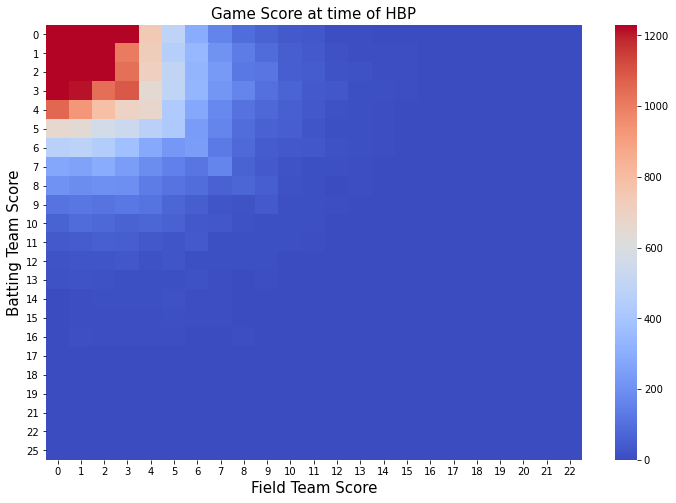

In [143]:
plt.figure(figsize=(12, 8))
sns.heatmap(pd.crosstab(df_merged["BAT_TEAM_SCORE"], df_merged["FLD_TEAM_SCORE"]), cmap="coolwarm", robust=True)
plt.title("Game Score at time of HBP", fontsize=15)
plt.xlabel("Field Team Score", fontsize=15)
plt.ylabel("Batting Team Score", fontsize=15)
plt.yticks(rotation=0);

**NOTE** High run totals for either side are rare. Convert to something categorical, like "Tie Score, BAT TEAM ahead by 1-5 runs, BAT TEAM ahead by 6-10 runs, BAT TEAM ahead by >10 runs, FLD TEAM ahead by 1-5 runs, FLD TEAM ahead by 6-10 runs, FLD TEAM ahead by >10 runs, or something like that depending on how the data breaks out. Somewhat similar to [Stathead](https://stathead.com/baseball/event_finder.cgi?request=1&year=1969&year_to=2019&divisory=1&from=button&type=b&event=16)'s RelScore Summary statistic. 

In [144]:
df_merged["FLD_TEAM_RUN_DIFF"] = df_merged["FLD_TEAM_SCORE"] - df_merged["BAT_TEAM_SCORE"]

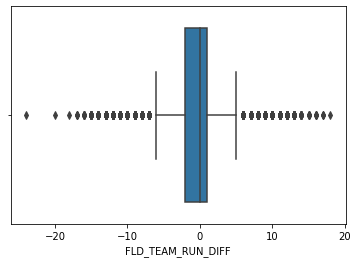

In [145]:
sns.boxplot(x=df_merged["FLD_TEAM_RUN_DIFF"]);

In [146]:
df_merged["FLD_TEAM_RUN_DIFF"].mean()

-0.2709684688309807

In [147]:
# Create function to categorize run differential into buckets
def run_diff(series):
    if series <= -7:
        return "Down by 7 or more runs"
    elif -6 <= series <= -4:
        return "Down by 4 to 6 runs"
    elif -3 <= series <= -2:
        return "Down by 2 to 3 runs"
    elif series == -1:
        return "Down by 1 run"
    elif series == 0:
        return "Tie score"
    elif series == 1:
        return "Up by 1 run"
    elif 1 < series <= 3:
        return "Up by 2 to 3 runs"
    elif 3 < series <= 6:
        return "Up by 4 to 6 runs"
    else:
        return "Up by 7 or more runs"

df_merged["FLD_RUN_DIFF"] = df_merged["FLD_TEAM_RUN_DIFF"].apply(run_diff).astype('category')
# Reorder categories into more logical order
df_merged["FLD_RUN_DIFF"].cat.reorder_categories([
    "Down by 7 or more runs", 
    "Down by 4 to 6 runs",
    "Down by 2 to 3 runs",
    "Down by 1 run",
    "Tie score",
    "Up by 1 run",
    "Up by 2 to 3 runs",
    "Up by 4 to 6 runs",
    "Up by 7 or more runs"
], ordered = True, inplace = True)

df_merged["FLD_RUN_DIFF"].value_counts()

Tie score                 16177
Down by 2 to 3 runs        9486
Up by 2 to 3 runs          7985
Down by 1 run              7738
Up by 1 run                7401
Down by 4 to 6 runs        5705
Up by 4 to 6 runs          4223
Down by 7 or more runs     2030
Up by 7 or more runs       1384
Name: FLD_RUN_DIFF, dtype: int64

In [148]:
# Check to make sure this worked properly
pd.crosstab(df_merged["FLD_TEAM_RUN_DIFF"], df_merged["FLD_RUN_DIFF"])

FLD_RUN_DIFF,Down by 7 or more runs,Down by 4 to 6 runs,Down by 2 to 3 runs,Down by 1 run,Tie score,Up by 1 run,Up by 2 to 3 runs,Up by 4 to 6 runs,Up by 7 or more runs
FLD_TEAM_RUN_DIFF,,,,,,,,,
-24,1,0,0,0,0,0,0,0,0
-20,1,0,0,0,0,0,0,0,0
-18,1,0,0,0,0,0,0,0,0
-17,4,0,0,0,0,0,0,0,0
-16,8,0,0,0,0,0,0,0,0
-15,24,0,0,0,0,0,0,0,0
-14,23,0,0,0,0,0,0,0,0
-13,34,0,0,0,0,0,0,0,0
-12,71,0,0,0,0,0,0,0,0


In [149]:
# Now create an ahead/behind indicator
df_merged["PIT_TEAM_IS_AHEAD"] = (df_merged["FLD_TEAM_RUN_DIFF"] > 0).astype(int)
df_merged["PIT_TEAM_IS_AHEAD"].value_counts()

0    41136
1    20993
Name: PIT_TEAM_IS_AHEAD, dtype: int64

In [150]:
# Do the same for behind
df_merged["PIT_TEAM_IS_BEHIND"] = (df_merged["FLD_TEAM_RUN_DIFF"] < 0).astype(int)
df_merged["PIT_TEAM_IS_BEHIND"].value_counts()

0    37170
1    24959
Name: PIT_TEAM_IS_BEHIND, dtype: int64

In [151]:
pd.crosstab(df_merged["PIT_TEAM_IS_AHEAD"], df_merged["PIT_TEAM_IS_BEHIND"])

PIT_TEAM_IS_BEHIND,0,1
PIT_TEAM_IS_AHEAD,,
0,16177,24959
1,20993,0


## Create new base runners variable

**NOTE** This may not be entirely necessary, but the ___ and __ can be tricky to discern, so for ease of future coding, I'm converting to string representations.

In [152]:
df_merged["BASES_STATE"].value_counts()

___    31849
1__    10984
_2_     6004
12_     4879
__3     2428
1_3     2418
123     1833
_23     1734
Name: BASES_STATE, dtype: int64

In [153]:
df_merged["RUNNERS_ON"] = df_merged["BASES_STATE"].map({
    "___": "empty",
    "1__": "1st",
    "_2_": "2nd",
    "__3": "3rd",
    "12_": "1st_2nd",
    "1_3": "1st_3rd",
    "_23": "2nd_3rd",
    "123": "full"
}).astype('category')
df_merged["RUNNERS_ON"].value_counts()

empty      31849
1st        10984
2nd         6004
1st_2nd     4879
3rd         2428
1st_3rd     2418
full        1833
2nd_3rd     1734
Name: RUNNERS_ON, dtype: int64

In [154]:
df_merged["RUNNERS_ON"].cat.reorder_categories(["empty",
                                                "1st",
                                                "2nd",
                                                "3rd",
                                                "1st_2nd",
                                                "1st_3rd",
                                                "2nd_3rd",
                                                "full"], 
                                               ordered = True, 
                                               inplace = True)

In [155]:
# Now create runners in scoring position variable
df_merged["RISP"] = ((df_merged["RUNNERS_ON"] != "empty") & (df_merged["RUNNERS_ON"] != "1st")).astype(int)
df_merged["RISP"].value_counts()

0    42833
1    19296
Name: RISP, dtype: int64

In [156]:
pd.crosstab(df_merged["RUNNERS_ON"], df_merged["RISP"])

RISP,0,1
RUNNERS_ON,,
empty,31849,0
1st,10984,0
2nd,0,6004
3rd,0,2428
1st_2nd,0,4879
1st_3rd,0,2418
2nd_3rd,0,1734
full,0,1833


## Pitching team home or away

In [157]:
df_merged["HALF"].value_counts()

Bot    31187
Top    30942
Name: HALF, dtype: int64

In [158]:
df_merged["PIT_TEAM_IS_HOME"] = (df_merged["HALF"] == "Top").astype(int)
df_merged["PIT_TEAM_IS_HOME"].value_counts(normalize=True)

0    0.501972
1    0.498028
Name: PIT_TEAM_IS_HOME, dtype: float64

## Add whether game was intradivision, intraleague, or interleague

Read in data file of teams, leagues and divisions over time. File was created by me based on info from [How They Play](https://howtheyplay.com/team-sports/major-league-baseball-expansion-and-franchise-relocation) and [Baseball Reference](https://www.baseball-reference.com/).

In [159]:
divs = pd.read_csv("../data/mlb leagues divisions.csv")
divs.head()

,TEAM,YEAR,LEAGUE,DIVISION,PIT_TEAM,PIT_LEAGUE,PIT_DIVISION,PIT_LG_DIV,BAT_TEAM,BAT_LEAGUE,BAT_DIVISION,BAT_LG_DIV
0,ANA,1969,AL,West,ANA,AL,West,AL - West,ANA,AL,West,AL - West
1,ANA,1970,AL,West,ANA,AL,West,AL - West,ANA,AL,West,AL - West
2,ANA,1971,AL,West,ANA,AL,West,AL - West,ANA,AL,West,AL - West
3,ANA,1972,AL,West,ANA,AL,West,AL - West,ANA,AL,West,AL - West
4,ANA,1973,AL,West,ANA,AL,West,AL - West,ANA,AL,West,AL - West


In [160]:
# Split file into a pitchers dataframe and a batters dataframe
# This is so it's easier to merge in the new columns properly for each row in the HBP database
divs_pit = divs.drop(columns=["TEAM", 
                              "LEAGUE", 
                              "DIVISION", 
                              "BAT_TEAM", 
                              "BAT_LEAGUE", 
                              "BAT_DIVISION", 
                              "BAT_LG_DIV"], axis=1)
divs_bat = divs.drop(columns=["TEAM", 
                              "LEAGUE", 
                              "DIVISION", 
                              "PIT_TEAM", 
                              "PIT_LEAGUE", 
                              "PIT_DIVISION", 
                              "PIT_LG_DIV"], axis=1)

In [161]:
divs_pit.head()

,YEAR,PIT_TEAM,PIT_LEAGUE,PIT_DIVISION,PIT_LG_DIV
0,1969,ANA,AL,West,AL - West
1,1970,ANA,AL,West,AL - West
2,1971,ANA,AL,West,AL - West
3,1972,ANA,AL,West,AL - West
4,1973,ANA,AL,West,AL - West


In [162]:
divs_bat.head()

,YEAR,BAT_TEAM,BAT_LEAGUE,BAT_DIVISION,BAT_LG_DIV
0,1969,ANA,AL,West,AL - West
1,1970,ANA,AL,West,AL - West
2,1971,ANA,AL,West,AL - West
3,1972,ANA,AL,West,AL - West
4,1973,ANA,AL,West,AL - West


In [163]:
# Merge in data for pitcher's team
df_merged = df_merged.merge(df_merged.merge(divs_pit, how="inner", on=["YEAR", "PIT_TEAM"], sort=False))
df_merged.head()

,DATE,WIN_TEAM,PIT_ID,PITCHER,PIT_TEAM,THROWS,BAT_ID,BATTER,BAT_TEAM,BATS,POSITION,LINEUP_SPOT,BAT_TEAM_SCORE,FLD_TEAM_SCORE,BASES_STATE,...,MISSING_PIT_COUNT,MISSING_PITCH_TYPE,MISSING_VELOCITY,PIT_BAT,WINNING_TEAM,FLD_TEAM_RUN_DIFF,FLD_RUN_DIFF,PIT_TEAM_IS_AHEAD,PIT_TEAM_IS_BEHIND,RUNNERS_ON,RISP,PIT_TEAM_IS_HOME,PIT_LEAGUE,PIT_DIVISION,PIT_LG_DIV
0,1969-04-07,ATL,23911,Pat Jarvis,ATL,R,23773,Ron Hunt,SFN,R,4,2,1,3,___,...,1,1,1,Pat Jarvis --> Ron Hunt,Team pitching,2,Up by 2 to 3 runs,1,0,empty,0,1,NL,West,NL - West
1,1969-04-08,ATL,27356,Gaylord Perry,SFN,R,26172,Felix Millan,ATL,R,4,2,0,1,__3,...,1,1,1,Gaylord Perry --> Felix Millan,Team batting,1,Up by 1 run,1,0,3rd,1,0,NL,West,NL - West
2,1969-04-08,ATL,26807,Phil Niekro,ATL,R,21692,Bobby Etheridge,SFN,R,5,7,2,3,___,...,1,1,1,Phil Niekro --> Bobby Etheridge,Team pitching,1,Up by 1 run,1,0,empty,0,1,NL,West,NL - West
3,1969-04-08,BOS,29297,Lee Stange,BOS,R,21690,Andy Etchebarren,BAL,R,2,7,1,2,___,...,1,1,1,Lee Stange --> Andy Etchebarren,Team pitching,1,Up by 1 run,1,0,empty,0,0,AL,East,AL - East
4,1969-04-08,BOS,24764,Bill Landis,BOS,L,21690,Andy Etchebarren,BAL,R,2,7,4,4,___,...,1,1,1,Bill Landis --> Andy Etchebarren,Team pitching,0,Tie score,0,0,empty,0,0,AL,East,AL - East


In [164]:
# Now merge in data for batter's team
df_merged = df_merged.merge(df_merged.merge(divs_bat, how="inner", on=["YEAR", "BAT_TEAM"], sort=False))
df_merged.head()

,DATE,WIN_TEAM,PIT_ID,PITCHER,PIT_TEAM,THROWS,BAT_ID,BATTER,BAT_TEAM,BATS,POSITION,LINEUP_SPOT,BAT_TEAM_SCORE,FLD_TEAM_SCORE,BASES_STATE,...,PIT_BAT,WINNING_TEAM,FLD_TEAM_RUN_DIFF,FLD_RUN_DIFF,PIT_TEAM_IS_AHEAD,PIT_TEAM_IS_BEHIND,RUNNERS_ON,RISP,PIT_TEAM_IS_HOME,PIT_LEAGUE,PIT_DIVISION,PIT_LG_DIV,BAT_LEAGUE,BAT_DIVISION,BAT_LG_DIV
0,1969-04-07,ATL,23911,Pat Jarvis,ATL,R,23773,Ron Hunt,SFN,R,4,2,1,3,___,...,Pat Jarvis --> Ron Hunt,Team pitching,2,Up by 2 to 3 runs,1,0,empty,0,1,NL,West,NL - West,NL,West,NL - West
1,1969-04-08,ATL,27356,Gaylord Perry,SFN,R,26172,Felix Millan,ATL,R,4,2,0,1,__3,...,Gaylord Perry --> Felix Millan,Team batting,1,Up by 1 run,1,0,3rd,1,0,NL,West,NL - West,NL,West,NL - West
2,1969-04-08,ATL,26807,Phil Niekro,ATL,R,21692,Bobby Etheridge,SFN,R,5,7,2,3,___,...,Phil Niekro --> Bobby Etheridge,Team pitching,1,Up by 1 run,1,0,empty,0,1,NL,West,NL - West,NL,West,NL - West
3,1969-04-08,BOS,29297,Lee Stange,BOS,R,21690,Andy Etchebarren,BAL,R,2,7,1,2,___,...,Lee Stange --> Andy Etchebarren,Team pitching,1,Up by 1 run,1,0,empty,0,0,AL,East,AL - East,AL,East,AL - East
4,1969-04-08,BOS,24764,Bill Landis,BOS,L,21690,Andy Etchebarren,BAL,R,2,7,4,4,___,...,Bill Landis --> Andy Etchebarren,Team pitching,0,Tie score,0,0,empty,0,0,AL,East,AL - East,AL,East,AL - East


In [165]:
# Create game type variable based on pitcher/batter team league and division
df_merged.loc[df_merged["PIT_LG_DIV"] == df_merged["BAT_LG_DIV"], "GAME_TYPE"] = "Division"
df_merged.loc[(df_merged["PIT_DIVISION"] != df_merged["BAT_DIVISION"]) & \
              (df_merged["PIT_LEAGUE"] == df_merged["BAT_LEAGUE"]), "GAME_TYPE"] = "Intraleague"
df_merged.loc[df_merged["PIT_LEAGUE"] != df_merged["BAT_LEAGUE"], "GAME_TYPE"] = "Interleague"
df_merged["GAME_TYPE"].value_counts()

Intraleague    29060
Division       28918
Interleague     4151
Name: GAME_TYPE, dtype: int64

In [166]:
df_merged.tail()

,DATE,WIN_TEAM,PIT_ID,PITCHER,PIT_TEAM,THROWS,BAT_ID,BATTER,BAT_TEAM,BATS,POSITION,LINEUP_SPOT,BAT_TEAM_SCORE,FLD_TEAM_SCORE,BASES_STATE,...,WINNING_TEAM,FLD_TEAM_RUN_DIFF,FLD_RUN_DIFF,PIT_TEAM_IS_AHEAD,PIT_TEAM_IS_BEHIND,RUNNERS_ON,RISP,PIT_TEAM_IS_HOME,PIT_LEAGUE,PIT_DIVISION,PIT_LG_DIV,BAT_LEAGUE,BAT_DIVISION,BAT_LG_DIV,GAME_TYPE
62124,2019-09-29,CHA,100959,Victor Alcantara,DET,R,105432,Yoan Moncada,CHA,L,5,4,5,2,___,...,Team batting,-3,Down by 2 to 3 runs,0,1,empty,0,0,AL,Central,AL - Central,AL,Central,AL - Central,Division
62125,2019-09-29,COL,71331,Sam Howard,COL,L,69600,Orlando Arcia,MIL,R,6,7,3,0,_2_,...,Team pitching,-3,Down by 2 to 3 runs,0,1,2nd,1,1,NL,West,NL - West,NL,Central,NL - Central,Intraleague
62126,2019-09-29,COL,100720,Yency Almonte,COL,R,102700,Jacob Nottingham,MIL,R,11,1,3,3,_23,...,Team pitching,0,Tie score,0,0,2nd_3rd,1,1,NL,West,NL - West,NL,Central,NL - Central,Intraleague
62127,2019-09-29,KCA,70464,Jorge Lopez,KCA,R,67574,Miguel Sano,MIN,R,10,3,4,3,___,...,Team pitching,-1,Down by 1 run,0,1,empty,0,1,AL,Central,AL - Central,AL,Central,AL - Central,Division
62128,2019-09-29,SLN,100576,Duane Underwood Jr.,CHN,R,105846,Paul DeJong,SLN,R,6,7,8,0,___,...,Team batting,-8,Down by 7 or more runs,0,1,empty,0,0,NL,Central,NL - Central,NL,Central,NL - Central,Division


In [167]:
df_merged.columns

Index(['DATE', 'WIN_TEAM', 'PIT_ID', 'PITCHER', 'PIT_TEAM', 'THROWS', 'BAT_ID',
       'BATTER', 'BAT_TEAM', 'BATS', 'POSITION', 'LINEUP_SPOT',
       'BAT_TEAM_SCORE', 'FLD_TEAM_SCORE', 'BASES_STATE', 'HALF', 'INNING',
       'OUTS_CT', 'BALLS', 'STRIKES', 'PITCH_TYPE', 'VELOCITY', 'PIT_REMOVED',
       'BAT_REMOVED', 'PIT_EJECTED', 'BAT_EJECTED', 'UMPIRE', 'EJECTIONS_CT',
       'EJECTIONS_PL', 'EJECTION_DES', 'HALF_INNING', 'MONTH', 'DAY', 'YEAR',
       'PIT_FIRST', 'PIT_LAST', 'BAT_FIRST', 'BAT_LAST', 'EVENT_ID',
       'GAME_STAT', 'BAT_ID_y', 'PIT_ID_y', 'PIT_COUNT', 'RBI_ON_PLAY',
       'WIN_PROB_ADDED', 'BASE_OUT_RUNS_ADDED', 'LEVERAGE_INDEX',
       'DOUBLEHEADER', 'EPOCH', 'INNING_REC', 'COUNT_STATUS', 'THE_COUNT',
       'MISSING_BALLS_STRIKES', 'MISSING_PIT_COUNT', 'MISSING_PITCH_TYPE',
       'MISSING_VELOCITY', 'PIT_BAT', 'WINNING_TEAM', 'FLD_TEAM_RUN_DIFF',
       'FLD_RUN_DIFF', 'PIT_TEAM_IS_AHEAD', 'PIT_TEAM_IS_BEHIND', 'RUNNERS_ON',
       'RISP', 'PIT_TEAM_IS_HOME'

## Group Positions

In [168]:
df_merged["POSITION"].value_counts()

2     7468
4     7357
7     7334
3     7059
9     7045
8     7011
5     6962
6     5771
10    3537
11    1837
1      743
0        5
Name: POSITION, dtype: int64

In [169]:
df_merged[df_merged["POSITION"] == 0]

,DATE,WIN_TEAM,PIT_ID,PITCHER,PIT_TEAM,THROWS,BAT_ID,BATTER,BAT_TEAM,BATS,POSITION,LINEUP_SPOT,BAT_TEAM_SCORE,FLD_TEAM_SCORE,BASES_STATE,...,WINNING_TEAM,FLD_TEAM_RUN_DIFF,FLD_RUN_DIFF,PIT_TEAM_IS_AHEAD,PIT_TEAM_IS_BEHIND,RUNNERS_ON,RISP,PIT_TEAM_IS_HOME,PIT_LEAGUE,PIT_DIVISION,PIT_LG_DIV,BAT_LEAGUE,BAT_DIVISION,BAT_LG_DIV,GAME_TYPE
1266,1970-07-02,PHI,25883,Tug McGraw,NYN,L,29764,Tony Taylor,PHI,R,0,7,6,1,123,...,Team batting,-5,Down by 4 to 6 runs,0,1,full,1,0,NL,East,NL - East,NL,East,NL - East,Division
17529,1991-09-24,SFN,17752,Dwayne Henry,HOU,R,16754,Mike Benjamin,SFN,R,0,9,8,5,123,...,Team batting,-3,Down by 2 to 3 runs,0,1,full,1,1,NL,West,NL - West,NL,West,NL - West,Division
23270,1997-04-01,SDN,17325,Barry Manuel,NYN,R,1325,Rickey Henderson,SDN,R,0,9,6,4,123,...,Team batting,-2,Down by 2 to 3 runs,0,1,full,1,0,NL,East,NL - East,NL,West,NL - West,Intraleague
24038,1997-07-11,PHI,991,Felix Heredia,MIA,L,17468,Ricky Otero,PHI,R,0,3,12,2,_23,...,Team batting,-10,Down by 7 or more runs,0,1,2nd_3rd,1,1,NL,East,NL - East,NL,East,NL - East,Division
34919,2003-09-27,NYN,31482,Nate Bump,MIA,R,579,Marco Scutaro,NYN,R,0,9,8,2,12_,...,Team batting,-6,Down by 4 to 6 runs,0,1,1st_2nd,1,1,NL,East,NL - East,NL,East,NL - East,Division


In [170]:
df_merged["POSITION"] = df_merged["POSITION"].map({
        0: "PH_PR",
        1: "P",
        2: "C",
        3: "1B",
        4: "2B",
        5: "3B",
        6: "SS",
        7: "LF",
        8: "CF",
        9: "RF",
        10: "DH",
        11: "PH_PR"
    })

df_merged["POSITION"].value_counts()

C        7468
2B       7357
LF       7334
1B       7059
RF       7045
CF       7011
3B       6962
SS       5771
DH       3537
PH_PR    1842
P         743
Name: POSITION, dtype: int64

In [171]:
df_merged["POSITION_GROUP"] = df_merged["POSITION"].map({
    "P": "Pitcher_Catcher",
    "C": "Pitcher_Catcher",
    "1B": "Infielder",
    "2B": "Infielder",
    "3B": "Infielder",
    "SS": "Infielder",
    "LF": "Outfielder",
    "CF": "Outfielder",
    "RF": "Outfielder",
    "DH": "DH_PH_PR",
    "PH_PR": "DH_PH_PR"    
})
df_merged["POSITION_GROUP"].value_counts()

Infielder          27149
Outfielder         21390
Pitcher_Catcher     8211
DH_PH_PR            5379
Name: POSITION_GROUP, dtype: int64

In [172]:
df_merged.columns

Index(['DATE', 'WIN_TEAM', 'PIT_ID', 'PITCHER', 'PIT_TEAM', 'THROWS', 'BAT_ID',
       'BATTER', 'BAT_TEAM', 'BATS', 'POSITION', 'LINEUP_SPOT',
       'BAT_TEAM_SCORE', 'FLD_TEAM_SCORE', 'BASES_STATE', 'HALF', 'INNING',
       'OUTS_CT', 'BALLS', 'STRIKES', 'PITCH_TYPE', 'VELOCITY', 'PIT_REMOVED',
       'BAT_REMOVED', 'PIT_EJECTED', 'BAT_EJECTED', 'UMPIRE', 'EJECTIONS_CT',
       'EJECTIONS_PL', 'EJECTION_DES', 'HALF_INNING', 'MONTH', 'DAY', 'YEAR',
       'PIT_FIRST', 'PIT_LAST', 'BAT_FIRST', 'BAT_LAST', 'EVENT_ID',
       'GAME_STAT', 'BAT_ID_y', 'PIT_ID_y', 'PIT_COUNT', 'RBI_ON_PLAY',
       'WIN_PROB_ADDED', 'BASE_OUT_RUNS_ADDED', 'LEVERAGE_INDEX',
       'DOUBLEHEADER', 'EPOCH', 'INNING_REC', 'COUNT_STATUS', 'THE_COUNT',
       'MISSING_BALLS_STRIKES', 'MISSING_PIT_COUNT', 'MISSING_PITCH_TYPE',
       'MISSING_VELOCITY', 'PIT_BAT', 'WINNING_TEAM', 'FLD_TEAM_RUN_DIFF',
       'FLD_RUN_DIFF', 'PIT_TEAM_IS_AHEAD', 'PIT_TEAM_IS_BEHIND', 'RUNNERS_ON',
       'RISP', 'PIT_TEAM_IS_HOME'

In [173]:
df_merged["LINEUP_SPOT"].value_counts()

1    7731
4    7582
3    7512
2    7300
5    7051
6    7008
7    6701
8    6381
9    4863
Name: LINEUP_SPOT, dtype: int64

In [174]:
pd.crosstab(df_merged["LINEUP_SPOT"], df_merged["POSITION_GROUP"])

POSITION_GROUP,DH_PH_PR,Infielder,Outfielder,Pitcher_Catcher
LINEUP_SPOT,,,,
1,266,3074,4322,69
2,275,4316,2479,230
3,626,3344,3312,230
4,1072,3424,2663,423
5,806,2872,2545,828
6,535,2885,2510,1078
7,430,2785,1823,1663
8,340,2703,1082,2256
9,1029,1746,654,1434


## Removals & Ejections

In [175]:
df_merged["PIT_REMOVED"] = (df_merged["PIT_REMOVED"] == "Y").astype(int)
df_merged["PIT_REMOVED"].value_counts()

0    57962
1     4167
Name: PIT_REMOVED, dtype: int64

In [176]:
df_merged["BAT_REMOVED"] = (df_merged["BAT_REMOVED"] == "Y").astype(int)
df_merged["BAT_REMOVED"].value_counts()

0    59890
1     2239
Name: BAT_REMOVED, dtype: int64

In [177]:
df_merged["PIT_EJECTED"] = (df_merged["PIT_EJECTED"] == "Y").astype(int)
df_merged["PIT_EJECTED"].value_counts()

0    61862
1      267
Name: PIT_EJECTED, dtype: int64

In [178]:
df_merged["BAT_EJECTED"] = (df_merged["BAT_EJECTED"] == "Y").astype(int)
df_merged["BAT_EJECTED"].value_counts()

0    62024
1      105
Name: BAT_EJECTED, dtype: int64

In [179]:
df_merged["ANY_EJECTION"] = (df_merged["EJECTIONS_CT"] > 0).astype(int)
df_merged["ANY_EJECTION"].value_counts()

0    61713
1      416
Name: ANY_EJECTION, dtype: int64

## Velocity Ranges

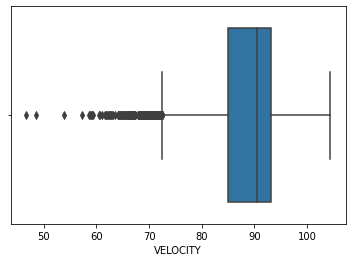

In [183]:
sns.boxplot(df_merged["VELOCITY"])

In [184]:
df_merged["VELOCITY"].describe()

count    19682.000000
mean        88.675668
std          6.247230
min         46.600000
25%         84.900000
50%         90.400000
75%         93.200000
max        104.400000
Name: VELOCITY, dtype: float64

In [186]:
df_merged["LOW_VELOCITY"] = (df_merged["VELOCITY"] < 85).astype(int)
df_merged["AVG_VELOCITY"] = ((df_merged["VELOCITY"] >= 85) & (df_merged["VELOCITY"] <= 93)).astype(int)
df_merged["HIGH_VELOCITY"] = (df_merged["VELOCITY"] > 93).astype(int)

In [187]:
df_merged["LOW_VELOCITY"].value_counts()

0    57169
1     4960
Name: LOW_VELOCITY, dtype: int64

In [188]:
df_merged["AVG_VELOCITY"].value_counts()

0    52644
1     9485
Name: AVG_VELOCITY, dtype: int64

In [189]:
df_merged["HIGH_VELOCITY"].value_counts()

0    56892
1     5237
Name: HIGH_VELOCITY, dtype: int64

In [194]:
# Create categorical velocity range variable
def velocity_ranges(series):
    if series < 70:
        return "Under 70 mph"
    elif 70 <= series < 80:
        return "70-79 mph"
    elif 80 <= series < 90:
        return "80-89 mph"
    elif 90 <= series < 96:
        return "90-95 mph"
    elif series >= 96:
        return "96+ mph"
    else:
        return "Unknown"
    
df_merged["VELOCITY_RANGE"] = df_merged["VELOCITY"].apply(velocity_ranges).astype('category')
df_merged["VELOCITY_RANGE"].cat.reorder_categories([
    "Unknown",
    "Under 70 mph", 
    "70-79 mph",
    "80-89 mph",
    "90-95 mph",
    "96+ mph"
], ordered = True, inplace = True)
df_merged["VELOCITY_RANGE"].value_counts()

Unknown         42447
90-95 mph        9187
80-89 mph        7037
70-79 mph        2058
96+ mph          1263
Under 70 mph      137
Name: VELOCITY_RANGE, dtype: int64

In [195]:
pd.crosstab(df_merged["VELOCITY_RANGE"], df_merged["PITCH_TYPE"])

PITCH_TYPE,Changeup (CH),"Curveball (CU, CS)",Cutter (FC),Fastball (FA),Knuckleball (KN),Sinker (SI),"Slider (SL, SB)",Splitter (FS)
VELOCITY_RANGE,,,,,,,,
Under 70 mph,2,88,0,4,40,0,2,1
70-79 mph,128,1410,6,12,69,2,404,27
80-89 mph,657,771,841,1088,9,1258,2184,229
90-95 mph,21,0,370,5083,0,3619,92,2
96+ mph,0,0,3,923,0,337,0,0


## Pitch Count

In [211]:
df_merged["PIT_COUNT"].value_counts()

1 (0-0)     9576
2 (0-1)     7623
4 (1-2)     5321
3 (1-1)     4981
3 (0-2)     4204
5 (2-2)     3120
2 (1-0)     2968
4 (2-1)     1671
5 (1-2)     1531
6 (2-2)     1221
6 (3-2)      939
4 (0-2)      795
3 (2-0)      776
7 (3-2)      503
5 (3-1)      468
7 (2-2)      399
6 (1-2)      387
8 (3-2)      209
4 (3-0)      193
5 (0-2)      169
8 (2-2)      137
7 (1-2)       98
9 (3-2)       85
8 (1-2)       35
9 (2-2)       34
6 (0-2)       31
10 (3-2)      29
2 (1-1)       26
1 (1-0)       25
3 (1-2)       16
10 (2-2)      13
3 (2-1)       13
5 (3-2)       12
7 (0-2)       12
4 (2-2)       11
9 (1-2)       11
11 (3-2)      11
2 (2-0)       10
4 (3-1)       10
12 (3-2)       8
12 (2-2)       4
13 (3-2)       4
3 (3-0)        4
11 (2-2)       3
8 (0-2)        3
14 (2-2)       1
Name: PIT_COUNT, dtype: int64

In [236]:
df_merged["NUM_PITCHES"] = df_merged["PIT_COUNT"].str.split(expand=True)[0]

In [237]:
df_merged["NUM_PITCHES"].value_counts()

2     10627
3      9994
1      9601
4      8001
5      5300
6      2578
7      1012
8       384
9       130
10       42
11       14
12       12
13        4
14        1
Name: NUM_PITCHES, dtype: int64

In [238]:
df_merged.tail()

,DATE,WIN_TEAM,PIT_ID,PITCHER,PIT_TEAM,THROWS,BAT_ID,BATTER,BAT_TEAM,BATS,POSITION,LINEUP_SPOT,BAT_TEAM_SCORE,FLD_TEAM_SCORE,BASES_STATE,HALF,INNING,OUTS_CT,BALLS,STRIKES,PITCH_TYPE,VELOCITY,PIT_REMOVED,BAT_REMOVED,PIT_EJECTED,BAT_EJECTED,UMPIRE,EJECTIONS_CT,EJECTIONS_PL,EJECTION_DES,HALF_INNING,MONTH,DAY,YEAR,PIT_FIRST,PIT_LAST,BAT_FIRST,BAT_LAST,EVENT_ID,GAME_STAT,BAT_ID_y,PIT_ID_y,PIT_COUNT,RBI_ON_PLAY,WIN_PROB_ADDED,BASE_OUT_RUNS_ADDED,LEVERAGE_INDEX,DOUBLEHEADER,EPOCH,INNING_REC,COUNT_STATUS,THE_COUNT,MISSING_BALLS_STRIKES,MISSING_PIT_COUNT,MISSING_PITCH_TYPE,MISSING_VELOCITY,PIT_BAT,WINNING_TEAM,FLD_TEAM_RUN_DIFF,FLD_RUN_DIFF,PIT_TEAM_IS_AHEAD,PIT_TEAM_IS_BEHIND,RUNNERS_ON,RISP,PIT_TEAM_IS_HOME,PIT_LEAGUE,PIT_DIVISION,PIT_LG_DIV,BAT_LEAGUE,BAT_DIVISION,BAT_LG_DIV,GAME_TYPE,POSITION_GROUP,ANY_EJECTION,LOW_VELOCITY,AVG_VELOCITY,HIGH_VELOCITY,VELOCITY_RANGE,NUM_PITCHES
62124,2019-09-29,CHA,100959,Victor Alcantara,DET,R,105432,Yoan Moncada,CHA,L,3B,4,5,2,___,Bot,8,1,1.0,0.0,Changeup (CH),90.7,0,0,0,0,Gabe Morales,0,NaN,NaN,b8,9,29,2019,Victor,Alcantara,Yoan,Moncada,62120,3,moncayo01,alcanvi01,2 (1-0),0,0.00,0.27,0.10,0,3,8,Batter ahead,1-0,0,0,0,0,Victor Alcantara --> Yoan Moncada,Team batting,-3,Down by 2 to 3 runs,0,1,empty,0,0,AL,Central,AL - Central,AL,Central,AL - Central,Division,Infielder,0,0,1,0,90-95 mph,2
62125,2019-09-29,COL,71331,Sam Howard,COL,L,69600,Orlando Arcia,MIL,R,SS,7,3,0,_2_,Top,6,2,0.0,1.0,Fastball (FA),92.4,0,0,0,0,Tripp Gibson,0,NaN,NaN,t6,9,29,2019,Sam,Howard,Orlando,Arcia,62121,1,arciaor01,howarsa01,2 (0-1),0,0.00,0.13,0.73,0,3,6,Pitcher ahead,0-1,0,0,0,0,Sam Howard --> Orlando Arcia,Team pitching,-3,Down by 2 to 3 runs,0,1,2nd,1,1,NL,West,NL - West,NL,Central,NL - Central,Intraleague,Infielder,0,0,1,0,90-95 mph,2
62126,2019-09-29,COL,100720,Yency Almonte,COL,R,102700,Jacob Nottingham,MIL,R,PH_PR,1,3,3,_23,Top,11,0,1.0,0.0,Fastball (FA),97.7,1,0,0,0,Tripp Gibson,0,NaN,NaN,t11,9,29,2019,Yency,Almonte,Jacob,Nottingham,62122,2,nottija01,almonye01,2 (1-0),0,0.02,0.34,2.26,0,3,10,Batter ahead,1-0,0,0,0,0,Yency Almonte --> Jacob Nottingham,Team pitching,0,Tie score,0,0,2nd_3rd,1,1,NL,West,NL - West,NL,Central,NL - Central,Intraleague,DH_PH_PR,0,0,0,1,96+ mph,2
62127,2019-09-29,KCA,70464,Jorge Lopez,KCA,R,67574,Miguel Sano,MIN,R,DH,3,4,3,___,Top,6,1,3.0,2.0,Changeup (CH),86.9,0,0,0,0,John Libka,0,NaN,NaN,t6,9,29,2019,Jorge,Lopez,Miguel,Sano,62123,1,sanomi01,lopezjo02,7 (3-2),0,0.03,0.28,0.76,0,3,6,Full,3-2,0,0,0,0,Jorge Lopez --> Miguel Sano,Team pitching,-1,Down by 1 run,0,1,empty,0,1,AL,Central,AL - Central,AL,Central,AL - Central,Division,DH_PH_PR,0,0,1,0,80-89 mph,7
62128,2019-09-29,SLN,100576,Duane Underwood Jr.,CHN,R,105846,Paul DeJong,SLN,R,SS,7,8,0,___,Bot,3,0,0.0,0.0,"Curveball (CU, CS)",77.8,0,0,0,0,Doug Eddings,0,NaN,NaN,b3,9,29,2019,Duane,Underwood,Paul,DeJong,62127,1,dejonpa01,underdu01,1 (0-0),0,0.00,0.39,0.06,0,3,3,Even,0-0,0,0,0,0,Duane Underwood Jr. --> Paul DeJong,Team batting,-8,Down by 7 or more runs,0,1,empty,0,0,NL,Central,NL - Central,NL,Central,NL - Central,Division,Infielder,0,1,0,0,70-79 mph,1


In [239]:
df_merged.shape

(62129, 79)

## Game stats - no new features created here, consider this EDA

In [196]:
df_merged["GAME_STAT"].value_counts()

1    45627
2    12856
3     2904
4      611
5      106
6       21
7        4
Name: GAME_STAT, dtype: int64

In [198]:
df_merged[df_merged["DATE"] == "2008-07-05"]

,DATE,WIN_TEAM,PIT_ID,PITCHER,PIT_TEAM,THROWS,BAT_ID,BATTER,BAT_TEAM,BATS,POSITION,LINEUP_SPOT,BAT_TEAM_SCORE,FLD_TEAM_SCORE,BASES_STATE,...,RISP,PIT_TEAM_IS_HOME,PIT_LEAGUE,PIT_DIVISION,PIT_LG_DIV,BAT_LEAGUE,BAT_DIVISION,BAT_LG_DIV,GAME_TYPE,POSITION_GROUP,ANY_EJECTION,LOW_VELOCITY,AVG_VELOCITY,HIGH_VELOCITY,VELOCITY_RANGE
43005,2008-07-05,TEX,45622,Scott Feldman,TEX,R,1240,Brian Roberts,BAL,L,2B,1,3,2,1__,...,0,0,AL,West,AL - West,AL,East,AL - East,Intraleague,Infielder,0,0,1,0,80-89 mph
43006,2008-07-05,COL,38540,Matt Lindstrom,MIA,R,31587,Brad Hawpe,COL,L,RF,5,8,0,___,...,0,0,NL,East,NL - East,NL,West,NL - West,Intraleague,Outfielder,0,0,0,1,96+ mph
43007,2008-07-05,COL,17438,Joe Nelson,MIA,R,31576,Garrett Atkins,COL,R,3B,4,8,3,1__,...,0,0,NL,East,NL - East,NL,West,NL - West,Intraleague,Infielder,0,0,1,0,80-89 mph
43008,2008-07-05,MIN,46279,Aaron Laffey,CLE,L,31760,Justin Morneau,MIN,L,1B,4,0,0,1__,...,0,0,AL,Central,AL - Central,AL,Central,AL - Central,Division,Infielder,0,0,1,0,80-89 mph
43009,2008-07-05,NYA,1598,Mike Mussina,NYA,R,1342,Manny Ramirez,BOS,R,DH,4,0,0,__3,...,1,1,AL,East,AL - East,AL,East,AL - East,Division,DH_PH_PR,0,1,0,0,70-79 mph
43010,2008-07-05,NYA,49766,Justin Masterson,BOS,R,1292,Alex Rodriguez,NYA,R,3B,4,1,0,12_,...,1,0,AL,East,AL - East,AL,East,AL - East,Division,Infielder,0,0,1,0,80-89 mph
43011,2008-07-05,NYA,1598,Mike Mussina,NYA,R,1342,Manny Ramirez,BOS,R,DH,4,0,1,___,...,0,1,AL,East,AL - East,AL,East,AL - East,Division,DH_PH_PR,0,0,1,0,80-89 mph
43012,2008-07-05,NYA,49766,Justin Masterson,BOS,R,31789,Robinson Cano,NYA,L,2B,7,1,0,___,...,0,0,AL,East,AL - East,AL,East,AL - East,Division,Infielder,0,1,0,0,80-89 mph
43013,2008-07-05,NYA,49766,Justin Masterson,BOS,R,894,Jose Molina,NYA,R,C,9,1,0,_23,...,1,0,AL,East,AL - East,AL,East,AL - East,Division,Pitcher_Catcher,0,0,1,0,80-89 mph
43014,2008-07-05,NYA,1604,Mariano Rivera,NYA,R,1342,Manny Ramirez,BOS,R,DH,4,0,2,1__,...,0,1,AL,East,AL - East,AL,East,AL - East,Division,DH_PH_PR,0,0,1,0,90-95 mph


In [199]:
df_merged["RBI_ON_PLAY"].value_counts()

0    60296
1     1833
Name: RBI_ON_PLAY, dtype: int64

In [203]:
df_merged["WIN_PROB_ADDED"].describe()

count    62129.000000
mean         0.029310
std          0.028188
min         -0.010000
25%          0.010000
50%          0.020000
75%          0.040000
max          0.400000
Name: WIN_PROB_ADDED, dtype: float64

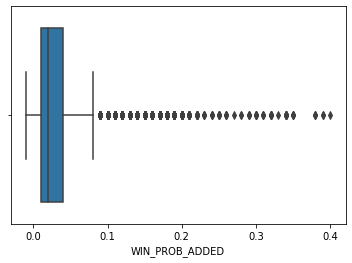

In [206]:
sns.boxplot(df_merged["WIN_PROB_ADDED"])

In [204]:
df_merged["BASE_OUT_RUNS_ADDED"].describe()

count    62129.000000
mean         0.334816
std          0.190645
min          0.090000
25%          0.210000
50%          0.320000
75%          0.390000
max          1.000000
Name: BASE_OUT_RUNS_ADDED, dtype: float64

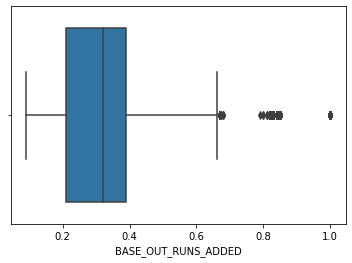

In [207]:
sns.boxplot(df_merged["BASE_OUT_RUNS_ADDED"])

In [205]:
df_merged["LEVERAGE_INDEX"].describe()

count    62129.000000
mean         1.035291
std          0.929620
min          0.000000
25%          0.410000
50%          0.850000
75%          1.380000
max         10.920000
Name: LEVERAGE_INDEX, dtype: float64

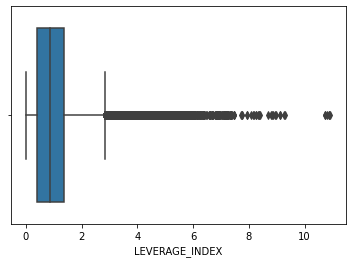

In [208]:
sns.boxplot(df_merged["LEVERAGE_INDEX"])

In [209]:
df_merged.to_csv("../data/temp merged file.csv", index=False)

# Save Cleaned data file

In [240]:
df_merged.columns

Index(['DATE', 'WIN_TEAM', 'PIT_ID', 'PITCHER', 'PIT_TEAM', 'THROWS', 'BAT_ID',
       'BATTER', 'BAT_TEAM', 'BATS', 'POSITION', 'LINEUP_SPOT',
       'BAT_TEAM_SCORE', 'FLD_TEAM_SCORE', 'BASES_STATE', 'HALF', 'INNING',
       'OUTS_CT', 'BALLS', 'STRIKES', 'PITCH_TYPE', 'VELOCITY', 'PIT_REMOVED',
       'BAT_REMOVED', 'PIT_EJECTED', 'BAT_EJECTED', 'UMPIRE', 'EJECTIONS_CT',
       'EJECTIONS_PL', 'EJECTION_DES', 'HALF_INNING', 'MONTH', 'DAY', 'YEAR',
       'PIT_FIRST', 'PIT_LAST', 'BAT_FIRST', 'BAT_LAST', 'EVENT_ID',
       'GAME_STAT', 'BAT_ID_y', 'PIT_ID_y', 'PIT_COUNT', 'RBI_ON_PLAY',
       'WIN_PROB_ADDED', 'BASE_OUT_RUNS_ADDED', 'LEVERAGE_INDEX',
       'DOUBLEHEADER', 'EPOCH', 'INNING_REC', 'COUNT_STATUS', 'THE_COUNT',
       'MISSING_BALLS_STRIKES', 'MISSING_PIT_COUNT', 'MISSING_PITCH_TYPE',
       'MISSING_VELOCITY', 'PIT_BAT', 'WINNING_TEAM', 'FLD_TEAM_RUN_DIFF',
       'FLD_RUN_DIFF', 'PIT_TEAM_IS_AHEAD', 'PIT_TEAM_IS_BEHIND', 'RUNNERS_ON',
       'RISP', 'PIT_TEAM_IS_HOME'

In [241]:
# Reorder columns
hbp = df_merged.loc[:, [
    'EPOCH', 
    'EVENT_ID',
    'DATE', 
    'MONTH', 
    'DAY', 
    'YEAR',
    'DOUBLEHEADER',
    'PIT_TEAM_IS_HOME', 
    'PIT_LEAGUE', 
    'PIT_DIVISION', 
    'PIT_LG_DIV',
    'BAT_LEAGUE', 
    'BAT_DIVISION', 
    'BAT_LG_DIV', 
    'GAME_TYPE',
    'GAME_STAT',
    'PIT_BAT',
    'PIT_ID',
    'PIT_ID_y',     
    'PITCHER', 
    'PIT_FIRST', 
    'PIT_LAST', 
    'PIT_TEAM', 
    'THROWS', 
    'BAT_ID',
    'BAT_ID_y',
    'BATTER',
    'BAT_FIRST', 
    'BAT_LAST',
    'BAT_TEAM', 
    'BATS', 
    'POSITION',
    'POSITION_GROUP',
    'LINEUP_SPOT',
    'BAT_TEAM_SCORE', 
    'FLD_TEAM_SCORE',
    'FLD_TEAM_RUN_DIFF',
    'FLD_RUN_DIFF', 
    'PIT_TEAM_IS_AHEAD', 
    'PIT_TEAM_IS_BEHIND', 
    'BASES_STATE',
    'RUNNERS_ON',
    'RISP',
    'HALF', 
    'INNING',
    'HALF_INNING',
    'INNING_REC', 
    'OUTS_CT', 
    'BALLS', 
    'STRIKES', 
    'NUM_PITCHES',
    'PIT_COUNT', 
    'COUNT_STATUS', 
    'THE_COUNT',
    'MISSING_BALLS_STRIKES',
    'MISSING_PIT_COUNT',
    'PITCH_TYPE', 
    'MISSING_PITCH_TYPE',
    'VELOCITY',
    'MISSING_VELOCITY',
    'LOW_VELOCITY', 
    'AVG_VELOCITY',
    'HIGH_VELOCITY', 
    'VELOCITY_RANGE',
    'RBI_ON_PLAY',
    'WIN_PROB_ADDED', 
    'BASE_OUT_RUNS_ADDED', 
    'LEVERAGE_INDEX',
    'WINNING_TEAM', 
    'WIN_TEAM',
    'PIT_REMOVED',
    'BAT_REMOVED', 
    'PIT_EJECTED', 
    'BAT_EJECTED', 
    'ANY_EJECTION',
    'EJECTIONS_CT',
    'UMPIRE', 
    'EJECTIONS_PL', 
    'EJECTION_DES'   
]]

In [242]:
hbp.head()

,EPOCH,EVENT_ID,DATE,MONTH,DAY,YEAR,DOUBLEHEADER,PIT_TEAM_IS_HOME,PIT_LEAGUE,PIT_DIVISION,PIT_LG_DIV,BAT_LEAGUE,BAT_DIVISION,BAT_LG_DIV,GAME_TYPE,GAME_STAT,PIT_BAT,PIT_ID,PIT_ID_y,PITCHER,PIT_FIRST,PIT_LAST,PIT_TEAM,THROWS,BAT_ID,BAT_ID_y,BATTER,BAT_FIRST,BAT_LAST,BAT_TEAM,BATS,POSITION,POSITION_GROUP,LINEUP_SPOT,BAT_TEAM_SCORE,FLD_TEAM_SCORE,FLD_TEAM_RUN_DIFF,FLD_RUN_DIFF,PIT_TEAM_IS_AHEAD,PIT_TEAM_IS_BEHIND,BASES_STATE,RUNNERS_ON,RISP,HALF,INNING,HALF_INNING,INNING_REC,OUTS_CT,BALLS,STRIKES,NUM_PITCHES,PIT_COUNT,COUNT_STATUS,THE_COUNT,MISSING_BALLS_STRIKES,MISSING_PIT_COUNT,PITCH_TYPE,MISSING_PITCH_TYPE,VELOCITY,MISSING_VELOCITY,LOW_VELOCITY,AVG_VELOCITY,HIGH_VELOCITY,VELOCITY_RANGE,RBI_ON_PLAY,WIN_PROB_ADDED,BASE_OUT_RUNS_ADDED,LEVERAGE_INDEX,WINNING_TEAM,WIN_TEAM,PIT_REMOVED,BAT_REMOVED,PIT_EJECTED,BAT_EJECTED,ANY_EJECTION,EJECTIONS_CT,UMPIRE,EJECTIONS_PL,EJECTION_DES
0,1,1,1969-04-07,4,7,1969,0,1,NL,West,NL - West,NL,West,NL - West,Division,1,Pat Jarvis --> Ron Hunt,23911,jarvipa01,Pat Jarvis,Pat,Jarvis,ATL,R,23773,huntro01,Ron Hunt,Ron,Hunt,SFN,R,2B,Infielder,2,1,3,2,Up by 2 to 3 runs,1,0,___,empty,0,Top,6,t6,6,0,NaN,NaN,NaN,NaN,Unknown,Unknown,1,1,NaN,1,NaN,1,0,0,0,Unknown,0,0.05,0.37,1.20,Team pitching,ATL,0,0,0,0,0,0,Ken Burkhart,NaN,NaN
1,1,2,1969-04-08,4,8,1969,0,0,NL,West,NL - West,NL,West,NL - West,Division,1,Gaylord Perry --> Felix Millan,27356,perryga01,Gaylord Perry,Gaylord,Perry,SFN,R,26172,millafe01,Felix Millan,Felix,Millan,ATL,R,2B,Infielder,2,0,1,1,Up by 1 run,1,0,__3,3rd,1,Bot,1,b1,1,0,NaN,NaN,NaN,NaN,Unknown,Unknown,1,1,NaN,1,NaN,1,0,0,0,Unknown,0,0.04,0.42,1.22,Team batting,ATL,0,0,0,0,0,0,Ed Sudol,NaN,NaN
2,1,3,1969-04-08,4,8,1969,0,1,NL,West,NL - West,NL,West,NL - West,Division,2,Phil Niekro --> Bobby Etheridge,26807,niekrph01,Phil Niekro,Phil,Niekro,ATL,R,21692,etherbo01,Bobby Etheridge,Bobby,Etheridge,SFN,R,3B,Infielder,7,2,3,1,Up by 1 run,1,0,___,empty,0,Top,4,t4,4,1,NaN,NaN,NaN,NaN,Unknown,Unknown,1,1,NaN,1,NaN,1,0,0,0,Unknown,0,0.03,0.25,0.80,Team pitching,ATL,0,0,0,0,0,0,Ed Sudol,NaN,NaN
3,1,4,1969-04-08,4,8,1969,0,0,AL,East,AL - East,AL,East,AL - East,Division,1,Lee Stange --> Andy Etchebarren,29297,stangle01,Lee Stange,Lee,Stange,BOS,R,21690,etchean01,Andy Etchebarren,Andy,Etchebarren,BAL,R,C,Pitcher_Catcher,7,1,2,1,Up by 1 run,1,0,___,empty,0,Bot,5,b5,5,1,NaN,NaN,NaN,NaN,Unknown,Unknown,1,1,NaN,1,NaN,1,0,0,0,Unknown,0,0.04,0.25,0.96,Team pitching,BOS,0,0,0,0,0,0,Hank Soar,NaN,NaN
4,1,5,1969-04-08,4,8,1969,0,0,AL,East,AL - East,AL,East,AL - East,Division,2,Bill Landis --> Andy Etchebarren,24764,landibi01,Bill Landis,Bill,Landis,BOS,L,21690,etchean01,Andy Etchebarren,Andy,Etchebarren,BAL,R,C,Pitcher_Catcher,7,4,4,0,Tie score,0,0,___,empty,0,Bot,11,b11,10,0,NaN,NaN,NaN,NaN,Unknown,Unknown,1,1,NaN,1,NaN,1,0,0,0,Unknown,0,0.07,0.37,2.22,Team pitching,BOS,0,0,0,0,0,0,Hank Soar,NaN,NaN


In [243]:
# Change all column names to lower case
hbp.columns = map(str.lower, hbp.columns)

In [244]:
hbp.head()

,epoch,event_id,date,month,day,year,doubleheader,pit_team_is_home,pit_league,pit_division,pit_lg_div,bat_league,bat_division,bat_lg_div,game_type,game_stat,pit_bat,pit_id,pit_id_y,pitcher,pit_first,pit_last,pit_team,throws,bat_id,bat_id_y,batter,bat_first,bat_last,bat_team,bats,position,position_group,lineup_spot,bat_team_score,fld_team_score,fld_team_run_diff,fld_run_diff,pit_team_is_ahead,pit_team_is_behind,bases_state,runners_on,risp,half,inning,half_inning,inning_rec,outs_ct,balls,strikes,num_pitches,pit_count,count_status,the_count,missing_balls_strikes,missing_pit_count,pitch_type,missing_pitch_type,velocity,missing_velocity,low_velocity,avg_velocity,high_velocity,velocity_range,rbi_on_play,win_prob_added,base_out_runs_added,leverage_index,winning_team,win_team,pit_removed,bat_removed,pit_ejected,bat_ejected,any_ejection,ejections_ct,umpire,ejections_pl,ejection_des
0,1,1,1969-04-07,4,7,1969,0,1,NL,West,NL - West,NL,West,NL - West,Division,1,Pat Jarvis --> Ron Hunt,23911,jarvipa01,Pat Jarvis,Pat,Jarvis,ATL,R,23773,huntro01,Ron Hunt,Ron,Hunt,SFN,R,2B,Infielder,2,1,3,2,Up by 2 to 3 runs,1,0,___,empty,0,Top,6,t6,6,0,NaN,NaN,NaN,NaN,Unknown,Unknown,1,1,NaN,1,NaN,1,0,0,0,Unknown,0,0.05,0.37,1.20,Team pitching,ATL,0,0,0,0,0,0,Ken Burkhart,NaN,NaN
1,1,2,1969-04-08,4,8,1969,0,0,NL,West,NL - West,NL,West,NL - West,Division,1,Gaylord Perry --> Felix Millan,27356,perryga01,Gaylord Perry,Gaylord,Perry,SFN,R,26172,millafe01,Felix Millan,Felix,Millan,ATL,R,2B,Infielder,2,0,1,1,Up by 1 run,1,0,__3,3rd,1,Bot,1,b1,1,0,NaN,NaN,NaN,NaN,Unknown,Unknown,1,1,NaN,1,NaN,1,0,0,0,Unknown,0,0.04,0.42,1.22,Team batting,ATL,0,0,0,0,0,0,Ed Sudol,NaN,NaN
2,1,3,1969-04-08,4,8,1969,0,1,NL,West,NL - West,NL,West,NL - West,Division,2,Phil Niekro --> Bobby Etheridge,26807,niekrph01,Phil Niekro,Phil,Niekro,ATL,R,21692,etherbo01,Bobby Etheridge,Bobby,Etheridge,SFN,R,3B,Infielder,7,2,3,1,Up by 1 run,1,0,___,empty,0,Top,4,t4,4,1,NaN,NaN,NaN,NaN,Unknown,Unknown,1,1,NaN,1,NaN,1,0,0,0,Unknown,0,0.03,0.25,0.80,Team pitching,ATL,0,0,0,0,0,0,Ed Sudol,NaN,NaN
3,1,4,1969-04-08,4,8,1969,0,0,AL,East,AL - East,AL,East,AL - East,Division,1,Lee Stange --> Andy Etchebarren,29297,stangle01,Lee Stange,Lee,Stange,BOS,R,21690,etchean01,Andy Etchebarren,Andy,Etchebarren,BAL,R,C,Pitcher_Catcher,7,1,2,1,Up by 1 run,1,0,___,empty,0,Bot,5,b5,5,1,NaN,NaN,NaN,NaN,Unknown,Unknown,1,1,NaN,1,NaN,1,0,0,0,Unknown,0,0.04,0.25,0.96,Team pitching,BOS,0,0,0,0,0,0,Hank Soar,NaN,NaN
4,1,5,1969-04-08,4,8,1969,0,0,AL,East,AL - East,AL,East,AL - East,Division,2,Bill Landis --> Andy Etchebarren,24764,landibi01,Bill Landis,Bill,Landis,BOS,L,21690,etchean01,Andy Etchebarren,Andy,Etchebarren,BAL,R,C,Pitcher_Catcher,7,4,4,0,Tie score,0,0,___,empty,0,Bot,11,b11,10,0,NaN,NaN,NaN,NaN,Unknown,Unknown,1,1,NaN,1,NaN,1,0,0,0,Unknown,0,0.07,0.37,2.22,Team pitching,BOS,0,0,0,0,0,0,Hank Soar,NaN,NaN


In [245]:
hbp.to_csv("../data/Combined HBP Database - cleaned.csv", index=False)

In [91]:
hbp = pd.read_csv("../data/Combined HBP Database - cleaned.csv", dtype={"pitch_type": object,
                                                                        "runners_on": 'category'})
hbp.head()

,epoch,event_id,date,month,day,year,doubleheader,pit_team_is_home,pit_league,pit_division,pit_lg_div,bat_league,bat_division,bat_lg_div,game_type,...,rbi_on_play,win_prob_added,base_out_runs_added,leverage_index,winning_team,win_team,pit_removed,bat_removed,pit_ejected,bat_ejected,any_ejection,ejections_ct,umpire,ejections_pl,ejection_des
0,1,1,1969-04-07,4,7,1969,0,1,NL,West,NL - West,NL,West,NL - West,Division,...,0,0.05,0.37,1.20,Team pitching,ATL,0,0,0,0,0,0,Ken Burkhart,NaN,NaN
1,1,2,1969-04-08,4,8,1969,0,0,NL,West,NL - West,NL,West,NL - West,Division,...,0,0.04,0.42,1.22,Team batting,ATL,0,0,0,0,0,0,Ed Sudol,NaN,NaN
2,1,3,1969-04-08,4,8,1969,0,1,NL,West,NL - West,NL,West,NL - West,Division,...,0,0.03,0.25,0.80,Team pitching,ATL,0,0,0,0,0,0,Ed Sudol,NaN,NaN
3,1,4,1969-04-08,4,8,1969,0,0,AL,East,AL - East,AL,East,AL - East,Division,...,0,0.04,0.25,0.96,Team pitching,BOS,0,0,0,0,0,0,Hank Soar,NaN,NaN
4,1,5,1969-04-08,4,8,1969,0,0,AL,East,AL - East,AL,East,AL - East,Division,...,0,0.07,0.37,2.22,Team pitching,BOS,0,0,0,0,0,0,Hank Soar,NaN,NaN


In [92]:
hbp["pitch_type"].value_counts()

Fastball (FA)         7110
Sinker (SI)           5216
Slider (SL, SB)       2682
Curveball (CU, CS)    2269
Cutter (FC)           1220
Changeup (CH)          808
Splitter (FS)          259
Knuckleball (KN)       118
Name: pitch_type, dtype: int64

In [93]:
hbp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62129 entries, 0 to 62128
Data columns (total 79 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   epoch                  62129 non-null  int64   
 1   event_id               62129 non-null  int64   
 2   date                   62129 non-null  object  
 3   month                  62129 non-null  int64   
 4   day                    62129 non-null  int64   
 5   year                   62129 non-null  int64   
 6   doubleheader           62129 non-null  int64   
 7   pit_team_is_home       62129 non-null  int64   
 8   pit_league             62129 non-null  object  
 9   pit_division           62129 non-null  object  
 10  pit_lg_div             62129 non-null  object  
 11  bat_league             62129 non-null  object  
 12  bat_division           62129 non-null  object  
 13  bat_lg_div             62129 non-null  object  
 14  game_type              62129 non-null 

In [9]:
hbp.columns

Index(['epoch', 'event_id', 'date', 'month', 'day', 'year', 'doubleheader',
       'pit_team_is_home', 'pit_league', 'pit_division', 'pit_lg_div',
       'bat_league', 'bat_division', 'bat_lg_div', 'game_type', 'game_stat',
       'pit_bat', 'pit_id', 'pit_id_y', 'pitcher', 'pit_first', 'pit_last',
       'pit_team', 'throws', 'bat_id', 'bat_id_y', 'batter', 'bat_first',
       'bat_last', 'bat_team', 'bats', 'position', 'position_group',
       'lineup_spot', 'bat_team_score', 'fld_team_score', 'fld_team_run_diff',
       'fld_run_diff', 'pit_team_is_ahead', 'pit_team_is_behind',
       'bases_state', 'runners_on', 'risp', 'half', 'inning', 'half_inning',
       'inning_rec', 'outs_ct', 'balls', 'strikes', 'num_pitches', 'pit_count',
       'count_status', 'the_count', 'missing_balls_strikes',
       'missing_pit_count', 'pitch_type', 'missing_pitch_type', 'velocity',
       'missing_velocity', 'low_velocity', 'avg_velocity', 'high_velocity',
       'velocity_range', 'rbi_on_play', 'w

# Exploratory Data Analysis - All Years

In [10]:
hbp["epoch"].value_counts().sort_index()

1    14104
2    28056
3    19969
Name: epoch, dtype: int64

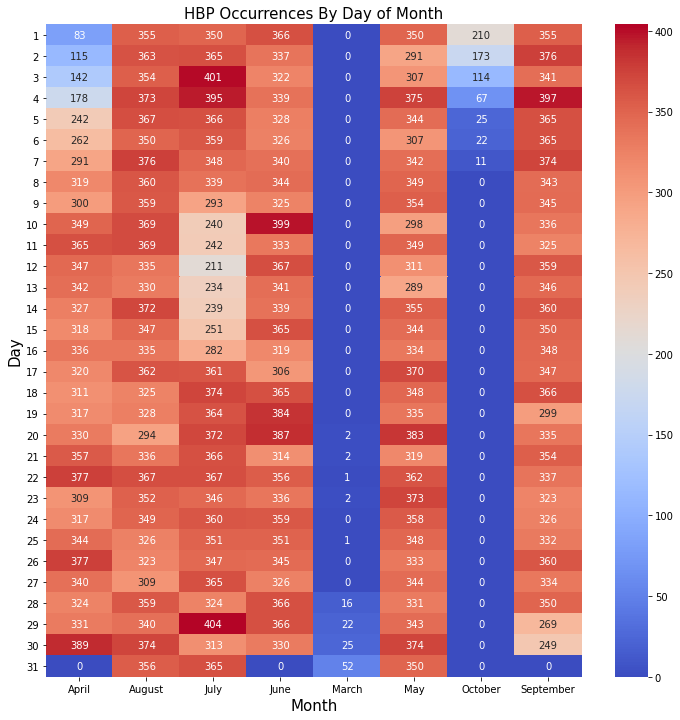

In [90]:
# Examine HBP Occurences by month and day
plt.figure(figsize=(12,12))
sns.heatmap(pd.crosstab(hbp["day"], hbp["month"]), cmap="coolwarm", annot=True, fmt='d')
plt.title("HBP Occurrences By Day of Month", fontsize=15)
plt.xlabel("Month", fontsize=15)
plt.xticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5],
          ["March", "April", "May", "June", "July", "August", "September", "October"])
plt.ylabel("Day", fontsize=15)
plt.yticks(rotation=0);

In [12]:
hbp["pitcher"].value_counts().head(10)

Randy Johnson     190
Tim Wakefield     186
Charlie Hough     174
Roger Clemens     159
Jamey Wright      155
Bert Blyleven     155
Nolan Ryan        154
Pedro Martinez    146
Jamie Moyer       146
A.J. Burnett      143
Name: pitcher, dtype: int64

In [13]:
hbp[hbp["pit_team"] == "BOS"]["pitcher"].value_counts().head(10)

Tim Wakefield     176
Roger Clemens      86
Pedro Martinez     77
Jon Lester         55
Josh Beckett       53
Rick Porcello      51
Derek Lowe         48
Clay Buchholz      45
Aaron Sele         42
Bob Stanley        41
Name: pitcher, dtype: int64

In [14]:
hbp["batter"].value_counts().head(10)

Craig Biggio        285
Don Baylor          267
Jason Kendall       254
Chase Utley         204
Jason Giambi        180
Andres Galarraga    178
Alex Rodriguez      176
Carlos Delgado      172
Derek Jeter         170
Ron Hunt            165
Name: batter, dtype: int64

In [15]:
pd.crosstab(hbp["pit_team"], hbp["bat_team"])

bat_team,ANA,ARI,ATL,BAL,BOS,CHA,CHN,CIN,CLE,COL,DET,HOU,KCA,LAN,MIA,MIL,MIN,NYA,NYN,OAK,PHI,PIT,SDN,SEA,SFN,SLN,TBA,TEX,TOR,WAS
pit_team,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ANA,0,14,6,146,139,181,4,5,132,13,135,59,152,39,2,91,166,133,5,246,4,9,9,197,8,7,60,246,120,5
ARI,11,0,51,4,9,2,61,60,6,121,7,80,7,163,45,55,7,6,37,8,53,39,125,4,129,58,11,11,3,59
ATL,11,55,0,11,17,7,99,123,6,54,6,107,7,111,121,45,5,13,176,1,174,121,110,7,136,112,12,8,17,173
BAL,129,7,14,0,197,117,2,2,112,2,100,30,88,7,12,60,109,228,12,110,18,11,13,99,4,3,146,109,201,35
BOS,148,9,25,222,0,136,8,3,158,4,142,20,137,8,21,87,142,299,16,162,29,10,9,134,6,8,188,163,263,13
CHA,145,4,5,137,142,0,44,8,232,2,220,21,240,9,9,76,236,117,3,165,12,14,6,118,5,16,53,153,118,12
CHN,4,39,100,5,5,52,0,215,6,57,10,162,6,101,92,155,7,6,134,4,149,255,106,4,125,237,6,1,2,162
CIN,4,39,130,0,1,7,203,0,30,57,12,193,10,129,66,166,8,8,122,5,97,245,119,13,124,184,3,7,11,125
CLE,144,8,4,133,203,206,7,41,0,3,205,18,193,6,8,100,233,139,7,136,9,13,4,104,3,9,49,135,117,3


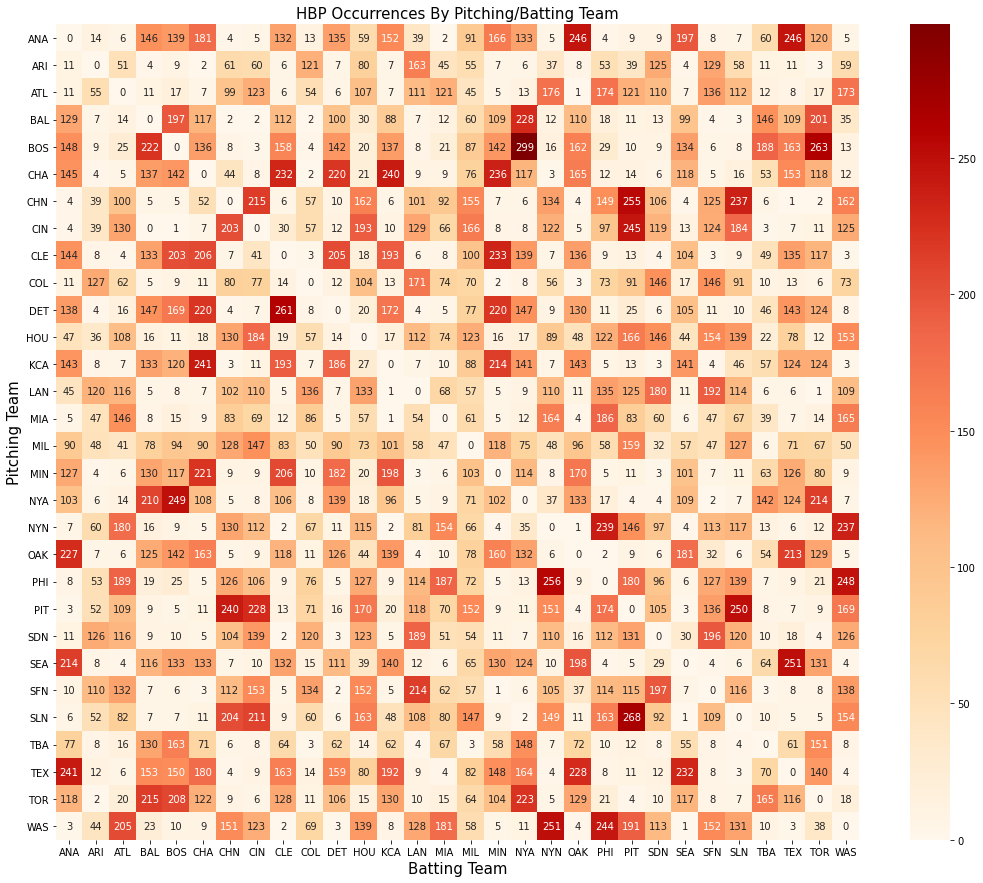

In [16]:
plt.figure(figsize=(18,15))
sns.heatmap(pd.crosstab(hbp["pit_team"], hbp["bat_team"]), cmap="OrRd", annot=True, fmt='d')
plt.title("HBP Occurrences By Pitching/Batting Team", fontsize=15)
plt.xlabel("Batting Team", fontsize=15)
plt.ylabel("Pitching Team", fontsize=15)
plt.yticks(rotation=0);

In [17]:
pd.crosstab(hbp["pit_lg_div"], hbp["bat_lg_div"])

bat_lg_div,AL - Central,AL - East,AL - West,NL - Central,NL - East,NL - West
pit_lg_div,,,,,,
AL - Central,2942,1710,1403,425,183,139
AL - East,1732,5995,4271,170,470,166
AL - West,1573,4428,5427,181,119,282
NL - Central,393,154,139,4193,1846,1566
NL - East,145,422,125,1903,5474,3294
NL - West,148,170,320,1969,3365,4887


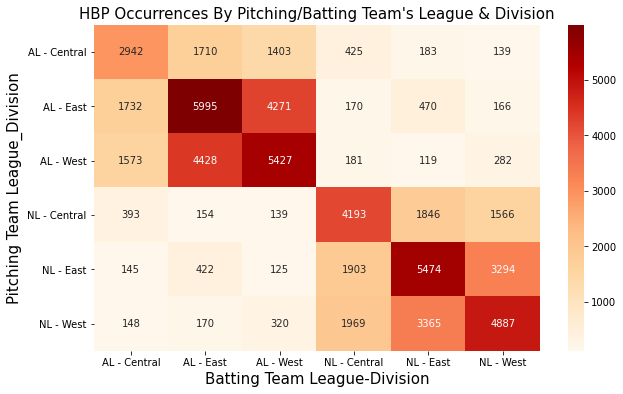

In [18]:
plt.figure(figsize=(10,6))
sns.heatmap(pd.crosstab(hbp["pit_lg_div"], hbp["bat_lg_div"]), cmap="OrRd", annot=True, fmt='d')
plt.title("HBP Occurrences By Pitching/Batting Team's League & Division", fontsize=15)
plt.xlabel("Batting Team League-Division", fontsize=15)
plt.ylabel("Pitching Team League_Division", fontsize=15)
plt.yticks(rotation=0);

In [19]:
hbp["bats"].value_counts(normalize=True)

R    0.644111
L    0.355889
Name: bats, dtype: float64

In [20]:
hbp["throws"].value_counts(normalize=True)

R    0.743501
L    0.256499
Name: throws, dtype: float64

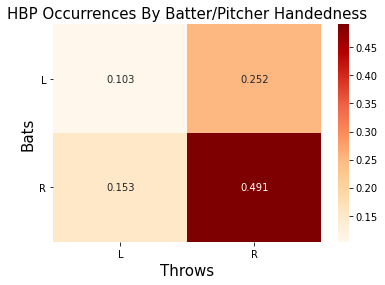

In [167]:
sns.heatmap(pd.crosstab(hbp["bats"], hbp["throws"], normalize=True), cmap="OrRd", annot=True, fmt='.3f')
plt.title("HBP Occurrences By Batter/Pitcher Handedness", fontsize=15)
plt.xlabel("Throws", fontsize=15)
plt.ylabel("Bats", fontsize=15)
plt.yticks(rotation=0);

In [22]:
hbp["half"].value_counts()

Bot    31187
Top    30942
Name: half, dtype: int64

In [23]:
hbp["outs_ct"].value_counts(normalize=True)

1    0.339133
0    0.335496
2    0.325371
Name: outs_ct, dtype: float64

In [24]:
hbp["balls"].value_counts(normalize=True)

0.0    0.477834
1.0    0.318501
2.0    0.153149
3.0    0.050515
Name: balls, dtype: float64

In [25]:
hbp["strikes"].value_counts(normalize=True)

2.0    0.400895
1.0    0.306132
0.0    0.292972
Name: strikes, dtype: float64

In [26]:
hbp["the_count"].value_counts()

Unknown    14104
0-0        10140
0-1         7603
1-2         7364
0-2         5205
1-1         4969
2-2         4915
1-0         2963
3-2         1769
2-1         1666
2-0          774
3-1          464
3-0          193
Name: the_count, dtype: int64

In [27]:
hbp["pit_removed"].value_counts(normalize=True)

0    0.93293
1    0.06707
Name: pit_removed, dtype: float64

In [28]:
hbp["bat_removed"].value_counts(normalize=True)

0    0.963962
1    0.036038
Name: bat_removed, dtype: float64

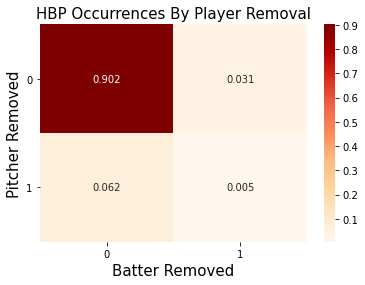

In [166]:
sns.heatmap(pd.crosstab(hbp["pit_removed"], 
                        hbp["bat_removed"], 
                        normalize=True), cmap="OrRd", annot=True, fmt='.3f')
plt.title("HBP Occurrences By Player Removal", fontsize=15)
plt.xlabel("Batter Removed", fontsize=15)
plt.ylabel("Pitcher Removed", fontsize=15)
plt.yticks(rotation=0);

In [30]:
hbp["pit_ejected"].value_counts()

0    61862
1      267
Name: pit_ejected, dtype: int64

In [31]:
hbp["bat_ejected"].value_counts()

0    62024
1      105
Name: bat_ejected, dtype: int64

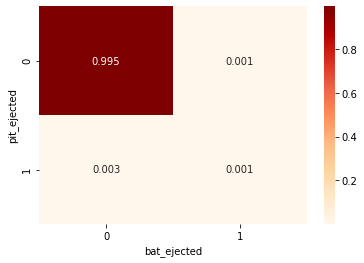

In [165]:
sns.heatmap(pd.crosstab(hbp["pit_ejected"], hbp["bat_ejected"], normalize=True), cmap="OrRd", 
            annot=True, fmt='.3f')

In [33]:
hbp["ejections_ct"].value_counts()

0    61713
1      230
2      135
3       25
4       12
7        4
6        4
5        4
9        1
8        1
Name: ejections_ct, dtype: int64

In [34]:
pd.set_option('display.max_colwidth', None)
hbp[hbp["ejections_ct"] > 4]["ejection_des"]

2048                                                                                                                                                                                                                                                                                                                                                                         Ray Fossse charged the mound and both benches cleared; Willie Horton decked Ray Lamb with a right to the jaw; Fosse was spiked by Bill Denehy and required five stitches on his right hand; Fosse, Denehy, Horton, Ike Brown and Gomer Hodge ejected by HP umpire Marty Springstead
11575                                                                                                                                                                                                                                      Craig Lefferts and Padres acting manager Jack Krol ejected by HP umpire Steve Rippley; both benches cleared and a 10-minute 

In [42]:
hbp["umpire"].value_counts().head(10)

Joe West           764
Gerry Davis        657
Dana DeMuth        647
Derryl Cousins     633
Gary Cederstrom    619
Mike Winters       607
Angel Hernandez    590
Jerry Meals        578
Mike Reilly        568
Joe Brinkman       565
Name: umpire, dtype: int64

In [57]:
hbp[hbp["ejections_ct"] > 0]["umpire"].value_counts().head(10)

Gary Darling        10
Tim Tschida          9
Bob Davidson         9
Charlie Williams     6
John McSherry        6
Jerry Layne          6
Joe West             6
Phil Cuzzi           6
Bruce Froemming      6
Marty Foster         6
Name: umpire, dtype: int64

In [36]:
hbp.columns

Index(['epoch', 'event_id', 'date', 'month', 'day', 'year', 'doubleheader',
       'pit_team_is_home', 'pit_league', 'pit_division', 'pit_lg_div',
       'bat_league', 'bat_division', 'bat_lg_div', 'game_type', 'game_stat',
       'pit_bat', 'pit_id', 'pit_id_y', 'pitcher', 'pit_first', 'pit_last',
       'pit_team', 'throws', 'bat_id', 'bat_id_y', 'batter', 'bat_first',
       'bat_last', 'bat_team', 'bats', 'position', 'position_group',
       'lineup_spot', 'bat_team_score', 'fld_team_score', 'fld_team_run_diff',
       'fld_run_diff', 'pit_team_is_ahead', 'pit_team_is_behind',
       'bases_state', 'runners_on', 'risp', 'half', 'inning', 'half_inning',
       'inning_rec', 'outs_ct', 'balls', 'strikes', 'num_pitches', 'pit_count',
       'count_status', 'the_count', 'missing_balls_strikes',
       'missing_pit_count', 'pitch_type', 'missing_pitch_type', 'velocity',
       'missing_velocity', 'low_velocity', 'avg_velocity', 'high_velocity',
       'velocity_range', 'rbi_on_play', 'w

In [58]:
hbp[hbp["epoch"] == 1]["pit_bat"].value_counts().head(10)

Charlie Hough --> Don Baylor        7
Jim Beattie --> Don Baylor          5
Phil Niekro --> Pete Rose           5
Nolan Ryan --> Ron Hunt             5
Ken Forsch --> Ron Hunt             5
Jack Billingham --> Felix Millan    4
Jim Bunning --> Ron Hunt            4
Doug Rau --> Bake McBride           4
Mark Langston --> Don Baylor        4
Jose Deleon --> Lonnie Smith        4
Name: pit_bat, dtype: int64

In [59]:
hbp[hbp["epoch"] == 2]["pit_bat"].value_counts().head(10)

David Wells --> Jason Giambi         8
Pedro Astacio --> Craig Biggio       7
Jamey Wright --> Jason Kendall       6
Mark Buehrle --> Travis Hafner       6
Tim Wakefield --> Shannon Stewart    6
Jeff Weaver --> A.J. Pierzynski      6
Chris Carpenter --> Melvin Mora      5
Chuck Finley --> Brady Anderson      5
Casey Fossum --> Reed Johnson        5
Pedro Martinez --> Jose Guillen      5
Name: pit_bat, dtype: int64

In [60]:
hbp[hbp["epoch"] == 3]["pit_bat"].value_counts().head(10)

Tanner Roark --> Derek Dietrich        7
Alfredo Simon --> Starling Marte       6
Charlie Morton --> Jon Jay             5
David Price --> Brandon Guyer          5
Travis Wood --> Shin-Soo Choo          4
Mark Buehrle --> Brandon Guyer         4
Jacob deGrom --> Derek Dietrich        4
Johnny Cueto --> Aramis Ramirez        4
Francisco Liriano --> Anthony Rizzo    4
Brandon Morrow --> Kevin Youkilis      4
Name: pit_bat, dtype: int64

In [74]:
hbp["pitcher"].nunique()

4301

In [75]:
hbp["batter"].nunique()

3969

In [76]:
hbp["pit_bat"].nunique()

57423

In [83]:
pd.crosstab(hbp["runners_on"], hbp["rbi_on_play"])

rbi_on_play,0,1
runners_on,,
1st,10984,0
1st_2nd,4879,0
1st_3rd,2418,0
2nd,6004,0
2nd_3rd,1734,0
3rd,2428,0
empty,31849,0
full,0,1833


In [84]:
hbp["runners_on"].dtype

CategoricalDtype(categories=['1st', '1st_2nd', '1st_3rd', '2nd', '2nd_3rd', '3rd',
                  'empty', 'full'],
                 ordered=False)

In [85]:
# This did not persist when reopening file
hbp["runners_on"].cat.reorder_categories(["empty",
                                          "1st",
                                          "2nd",
                                          "3rd",
                                          "1st_2nd",
                                          "1st_3rd",
                                          "2nd_3rd",
                                          "full"], 
                                         ordered = True, 
                                         inplace = True)

In [86]:
pd.crosstab(hbp["runners_on"], hbp["rbi_on_play"])

rbi_on_play,0,1
runners_on,,
empty,31849,0
1st,10984,0
2nd,6004,0
3rd,2428,0
1st_2nd,4879,0
1st_3rd,2418,0
2nd_3rd,1734,0
full,0,1833


# Create Dummy Variables

In [61]:
hbp.columns

Index(['epoch', 'event_id', 'date', 'month', 'day', 'year', 'doubleheader',
       'pit_team_is_home', 'pit_league', 'pit_division', 'pit_lg_div',
       'bat_league', 'bat_division', 'bat_lg_div', 'game_type', 'game_stat',
       'pit_bat', 'pit_id', 'pit_id_y', 'pitcher', 'pit_first', 'pit_last',
       'pit_team', 'throws', 'bat_id', 'bat_id_y', 'batter', 'bat_first',
       'bat_last', 'bat_team', 'bats', 'position', 'position_group',
       'lineup_spot', 'bat_team_score', 'fld_team_score', 'fld_team_run_diff',
       'fld_run_diff', 'pit_team_is_ahead', 'pit_team_is_behind',
       'bases_state', 'runners_on', 'risp', 'half', 'inning', 'half_inning',
       'inning_rec', 'outs_ct', 'balls', 'strikes', 'num_pitches', 'pit_count',
       'count_status', 'the_count', 'missing_balls_strikes',
       'missing_pit_count', 'pitch_type', 'missing_pitch_type', 'velocity',
       'missing_velocity', 'low_velocity', 'avg_velocity', 'high_velocity',
       'velocity_range', 'rbi_on_play', 'w

In [195]:
hbp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62129 entries, 0 to 62128
Data columns (total 79 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   epoch                  62129 non-null  int64   
 1   event_id               62129 non-null  int64   
 2   date                   62129 non-null  object  
 3   month                  62129 non-null  int64   
 4   day                    62129 non-null  int64   
 5   year                   62129 non-null  int64   
 6   doubleheader           62129 non-null  int64   
 7   pit_team_is_home       62129 non-null  int64   
 8   pit_league             62129 non-null  object  
 9   pit_division           62129 non-null  object  
 10  pit_lg_div             62129 non-null  object  
 11  bat_league             62129 non-null  object  
 12  bat_division           62129 non-null  object  
 13  bat_lg_div             62129 non-null  object  
 14  game_type              62129 non-null 

In [351]:
cat_columns= ['month', 'pit_league', 'pit_division', 'pit_lg_div','bat_league', 'bat_division', 'bat_lg_div',
              'game_type', 'pit_team', 'throws', 'bat_team', 'bats', 'position', 'position_group', 'lineup_spot',
              'fld_run_diff', 'runners_on', 'half', 'inning_rec', 'the_count', 'pitch_type', 
              'velocity_range', 'winning_team']

In [352]:
hbp_d = pd.get_dummies(hbp, columns=cat_columns)
hbp_d.head()

,epoch,event_id,date,day,year,doubleheader,pit_team_is_home,game_stat,pit_bat,pit_id,pit_id_y,pitcher,pit_first,pit_last,bat_id,bat_id_y,batter,bat_first,bat_last,bat_team_score,fld_team_score,fld_team_run_diff,pit_team_is_ahead,pit_team_is_behind,bases_state,risp,inning,half_inning,outs_ct,balls,strikes,num_pitches,pit_count,count_status,missing_balls_strikes,missing_pit_count,missing_pitch_type,velocity,missing_velocity,low_velocity,avg_velocity,high_velocity,rbi_on_play,win_prob_added,base_out_runs_added,leverage_index,win_team,pit_removed,bat_removed,pit_ejected,...,runners_on_1st,runners_on_1st_2nd,runners_on_1st_3rd,runners_on_2nd,runners_on_2nd_3rd,runners_on_3rd,runners_on_empty,runners_on_full,half_Bot,half_Top,inning_rec_1,inning_rec_2,inning_rec_3,inning_rec_4,inning_rec_5,inning_rec_6,inning_rec_7,inning_rec_8,inning_rec_9,inning_rec_10,the_count_0-0,the_count_0-1,the_count_0-2,the_count_1-0,the_count_1-1,the_count_1-2,the_count_2-0,the_count_2-1,the_count_2-2,the_count_3-0,the_count_3-1,the_count_3-2,the_count_Unknown,pitch_type_Changeup (CH),"pitch_type_Curveball (CU, CS)",pitch_type_Cutter (FC),pitch_type_Fastball (FA),pitch_type_Knuckleball (KN),pitch_type_Sinker (SI),"pitch_type_Slider (SL, SB)",pitch_type_Splitter (FS),velocity_range_70-79 mph,velocity_range_80-89 mph,velocity_range_90-95 mph,velocity_range_96+ mph,velocity_range_Under 70 mph,velocity_range_Unknown,winning_team_Team batting,winning_team_Team pitching,winning_team_Tie
0,1,1,1969-04-07,7,1969,0,1,1,Pat Jarvis --> Ron Hunt,23911,jarvipa01,Pat Jarvis,Pat,Jarvis,23773,huntro01,Ron Hunt,Ron,Hunt,1,3,2,1,0,___,0,6,t6,0,NaN,NaN,NaN,NaN,Unknown,1,1,1,NaN,1,0,0,0,0,0.05,0.37,1.20,ATL,0,0,0,...,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
1,1,2,1969-04-08,8,1969,0,0,1,Gaylord Perry --> Felix Millan,27356,perryga01,Gaylord Perry,Gaylord,Perry,26172,millafe01,Felix Millan,Felix,Millan,0,1,1,1,0,__3,1,1,b1,0,NaN,NaN,NaN,NaN,Unknown,1,1,1,NaN,1,0,0,0,0,0.04,0.42,1.22,ATL,0,0,0,...,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
2,1,3,1969-04-08,8,1969,0,1,2,Phil Niekro --> Bobby Etheridge,26807,niekrph01,Phil Niekro,Phil,Niekro,21692,etherbo01,Bobby Etheridge,Bobby,Etheridge,2,3,1,1,0,___,0,4,t4,1,NaN,NaN,NaN,NaN,Unknown,1,1,1,NaN,1,0,0,0,0,0.03,0.25,0.80,ATL,0,0,0,...,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
3,1,4,1969-04-08,8,1969,0,0,1,Lee Stange --> Andy Etchebarren,29297,stangle01,Lee Stange,Lee,Stange,21690,etchean01,Andy Etchebarren,Andy,Etchebarren,1,2,1,1,0,___,0,5,b5,1,NaN,NaN,NaN,NaN,Unknown,1,1,1,NaN,1,0,0,0,0,0.04,0.25,0.96,BOS,0,0,0,...,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
4,1,5,1969-04-08,8,1969,0,0,2,Bill Landis --> Andy Etchebarren,24764,landibi01,Bill Landis,Bill,Landis,21690,etchean01,Andy Etchebarren,Andy,Etchebarren,4,4,0,0,0,___,0,11,b11,0,NaN,NaN,NaN,NaN,Unknown,1,1,1,NaN,1,0,0,0,0,0.07,0.37,2.22,BOS,0,0,0,...,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0


In [353]:
hbp_d.shape

(62129, 236)

In [354]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_seq_items', None)
hbp_d.columns

Index(['epoch', 'event_id', 'date', 'day', 'year', 'doubleheader',
       'pit_team_is_home', 'game_stat', 'pit_bat', 'pit_id', 'pit_id_y',
       'pitcher', 'pit_first', 'pit_last', 'bat_id', 'bat_id_y', 'batter',
       'bat_first', 'bat_last', 'bat_team_score', 'fld_team_score',
       'fld_team_run_diff', 'pit_team_is_ahead', 'pit_team_is_behind',
       'bases_state', 'risp', 'inning', 'half_inning', 'outs_ct', 'balls',
       'strikes', 'num_pitches', 'pit_count', 'count_status',
       'missing_balls_strikes', 'missing_pit_count', 'missing_pitch_type',
       'velocity', 'missing_velocity', 'low_velocity', 'avg_velocity',
       'high_velocity', 'rbi_on_play', 'win_prob_added', 'base_out_runs_added',
       'leverage_index', 'win_team', 'pit_removed', 'bat_removed',
       'pit_ejected', 'bat_ejected', 'any_ejection', 'ejections_ct', 'umpire',
       'ejections_pl', 'ejection_des', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'p

In [355]:
# Save file
hbp_d.to_csv("../data/Combined HBP Data - cleaned with dummies.csv", index=False)

# Create separate files for analysis based on epoch

In [ ]:
hbp = pd.read_csv("../data/Combined HBP Database - cleaned.csv")
hbp.head()

In [108]:
hbp_1 = hbp[hbp["epoch"] == 1].copy()
hbp_2 = hbp[hbp["epoch"] == 2].copy()
hbp_3 = hbp[hbp["epoch"] == 3].copy()

In [109]:
hbp_1.shape

(14104, 79)

In [110]:
hbp_2.shape

(28056, 79)

In [111]:
hbp_3.shape

(19969, 79)

# Exploratory Data Analysis - By Epoch

## Epoch 1 - Old School Scoresheets (1969-1987)

## Epoch 2 - Project Scoresheet (1988-2007)

## Epoch 3 - PITCHf/x Years (2008-2019)

In [330]:
# Use original file (without dummies) for this section

In [98]:
hbp_3[hbp_3["pitch_type"] == "Knuckleball (KN)"]["pitcher"].value_counts()

R.A. Dickey       70
Tim Wakefield     31
Steven Wright     11
Charlie Haeger     5
Luke Maile         1
Name: pitcher, dtype: int64

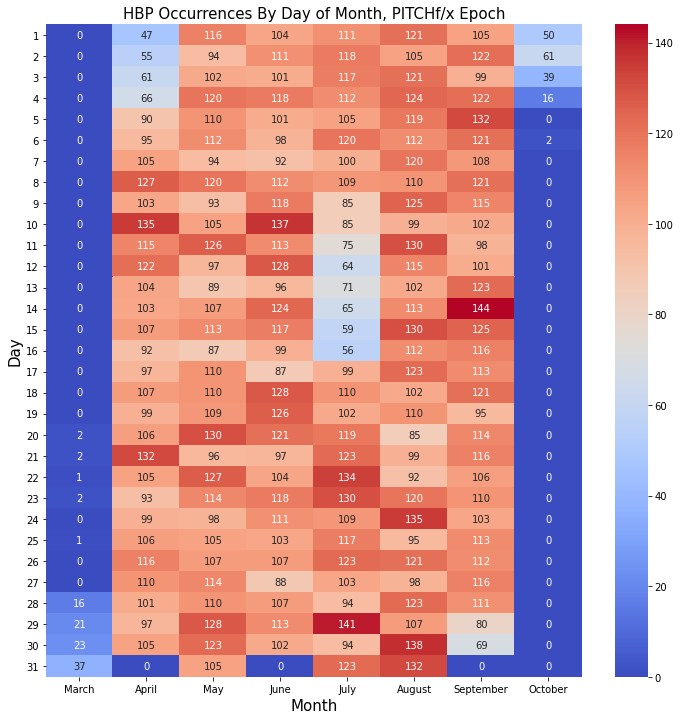

In [99]:
# Examine HBP Occurences by month and day
plt.figure(figsize=(12,12))
sns.heatmap(pd.crosstab(hbp_3["day"], hbp_3["month"]), cmap="coolwarm", annot=True, fmt='d')
plt.title("HBP Occurrences By Day of Month, PITCHf/x Epoch", fontsize=15)
plt.xlabel("Month", fontsize=15)
plt.xticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5],
          ["March", "April", "May", "June", "July", "August", "September", "October"])
plt.ylabel("Day", fontsize=15)
plt.yticks(rotation=0);

In [100]:
hbp_3["pitcher"].value_counts().head(10)

Charlie Morton      117
Johnny Cueto        104
Chris Sale           98
Cole Hamels          94
Felix Hernandez      94
Justin Masterson     93
A.J. Burnett         92
Max Scherzer         85
Rick Porcello        82
James Shields        82
Name: pitcher, dtype: int64

In [101]:
hbp_3["batter"].value_counts().head(10)

Chase Utley       148
Shin-Soo Choo     148
Anthony Rizzo     145
Derek Dietrich    118
Starling Marte    111
Carlos Gomez      109
Jon Jay           109
Carlos Quentin    108
Alex Gordon       105
Adam Jones        102
Name: batter, dtype: int64

In [102]:
hbp_3["pit_bat"].value_counts().head(10)

Tanner Roark --> Derek Dietrich        7
Alfredo Simon --> Starling Marte       6
Charlie Morton --> Jon Jay             5
David Price --> Brandon Guyer          5
Travis Wood --> Shin-Soo Choo          4
Mark Buehrle --> Brandon Guyer         4
Jacob deGrom --> Derek Dietrich        4
Johnny Cueto --> Aramis Ramirez        4
Francisco Liriano --> Anthony Rizzo    4
Brandon Morrow --> Kevin Youkilis      4
Name: pit_bat, dtype: int64

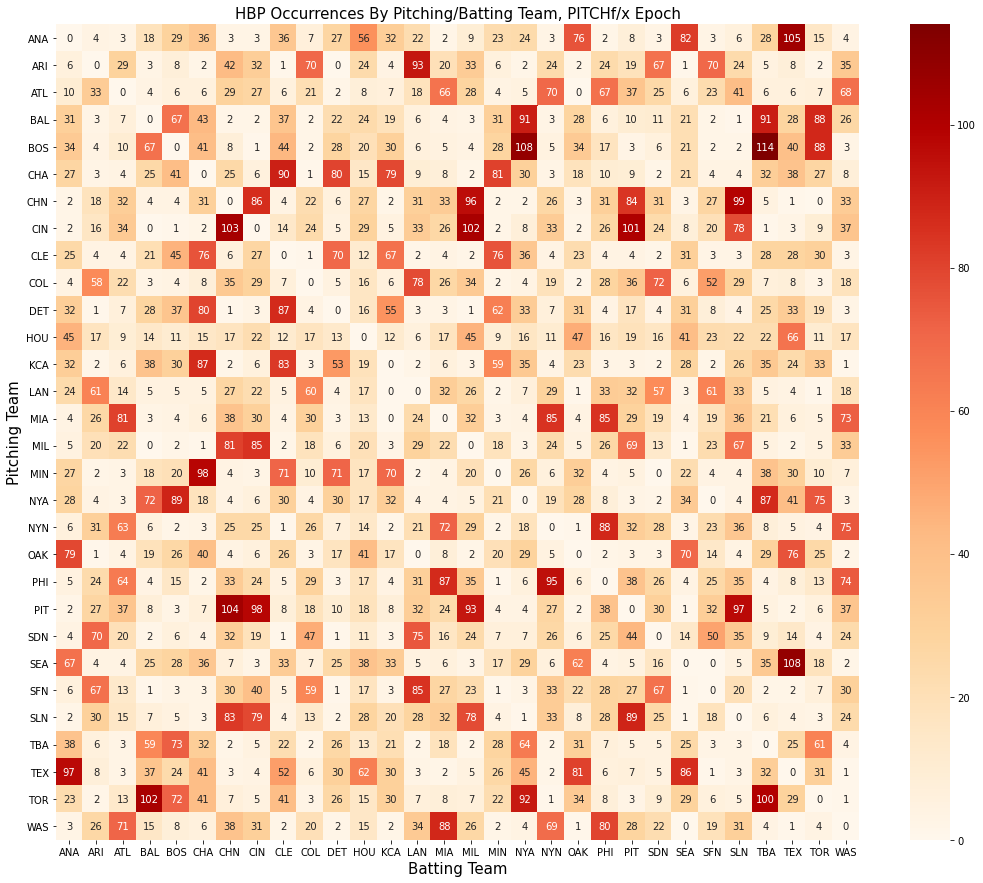

In [103]:
plt.figure(figsize=(18,15))
sns.heatmap(pd.crosstab(hbp_3["pit_team"], hbp_3["bat_team"]), cmap="OrRd", annot=True, fmt='d')
plt.title("HBP Occurrences By Pitching/Batting Team, PITCHf/x Epoch", fontsize=15)
plt.xlabel("Batting Team", fontsize=15)
plt.ylabel("Pitching Team", fontsize=15)
plt.yticks(rotation=0);

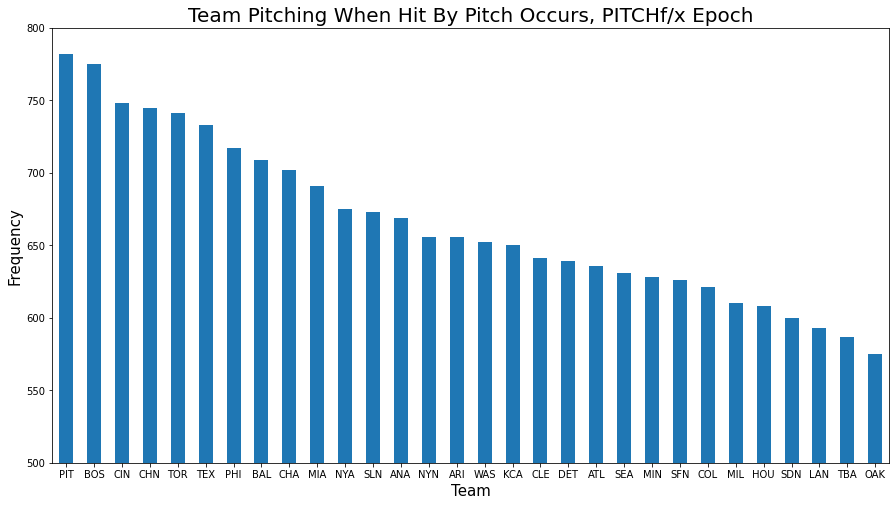

In [132]:
hbp_3["pit_team"].value_counts().plot(kind='bar', figsize=(15,8))
plt.title("Team Pitching When Hit By Pitch Occurs, PITCHf/x Epoch", fontsize=20)
plt.xlabel("Team", fontsize=15)
plt.ylim(500, 800)
plt.xticks(rotation=0)
plt.ylabel("Frequency", fontsize=15);

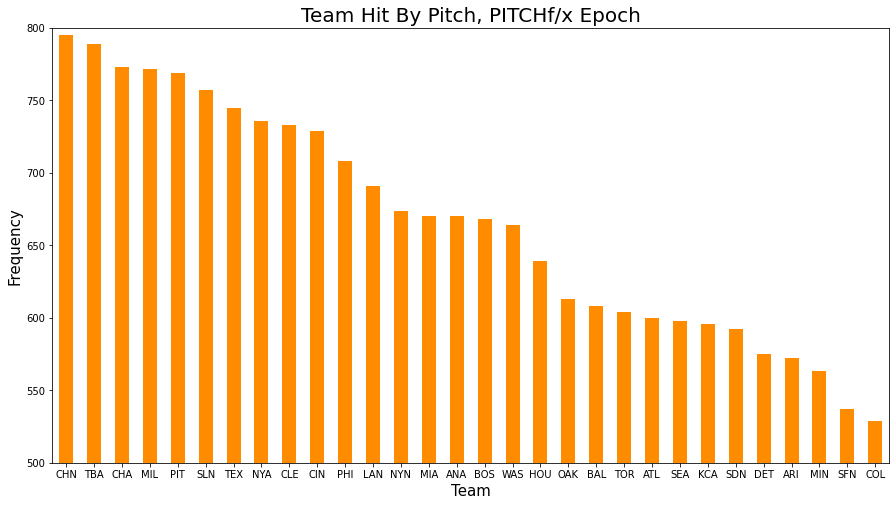

In [150]:
hbp_3["bat_team"].value_counts().plot(kind='bar', figsize=(15,8), color='darkorange')
plt.title("Team Hit By Pitch, PITCHf/x Epoch", fontsize=20)
plt.xlabel("Team", fontsize=15)
plt.xticks(rotation=0)
plt.ylim(500, 800)
plt.ylabel("Frequency", fontsize=15);

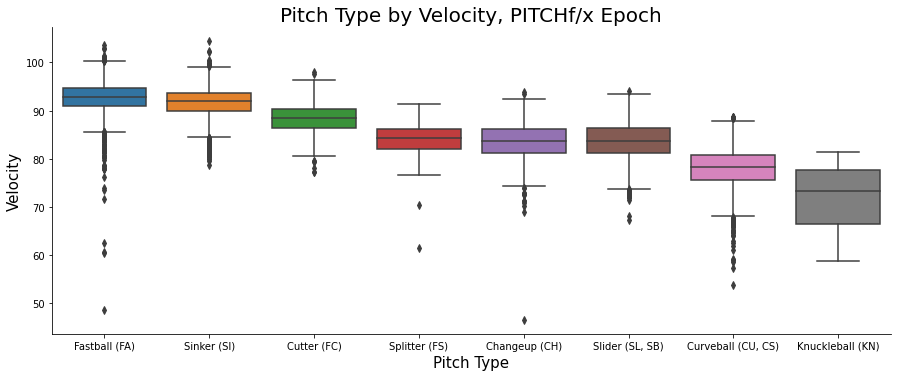

In [158]:
sns.catplot(x="pitch_type", y="velocity", kind="box", data=hbp_3, height=5, aspect=2.5,
            order=["Fastball (FA)", "Sinker (SI)", "Cutter (FC)", "Splitter (FS)",
                   "Changeup (CH)", "Slider (SL, SB)", "Curveball (CU, CS)", "Knuckleball (KN)"])
plt.title("Pitch Type by Velocity, PITCHf/x Epoch", fontsize=20)
plt.xlabel("Pitch Type", fontsize=15)
plt.ylabel("Velocity", fontsize=15);

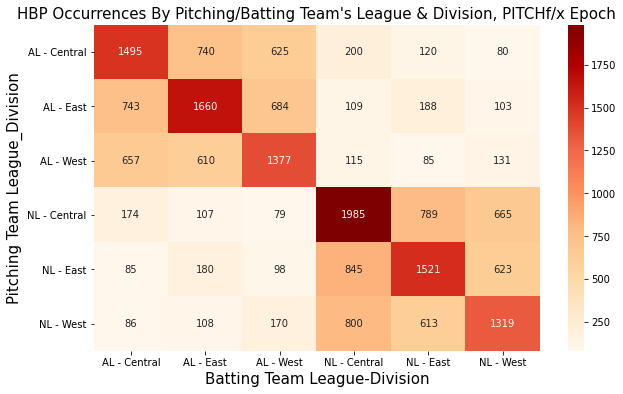

In [157]:
plt.figure(figsize=(10,6))
sns.heatmap(pd.crosstab(hbp_3["pit_lg_div"], hbp_3["bat_lg_div"]), cmap="OrRd", annot=True, fmt='d')
plt.title("HBP Occurrences By Pitching/Batting Team's League & Division, PITCHf/x Epoch", fontsize=15)
plt.xlabel("Batting Team League-Division", fontsize=15)
plt.ylabel("Pitching Team League_Division", fontsize=15)
plt.yticks(rotation=0);

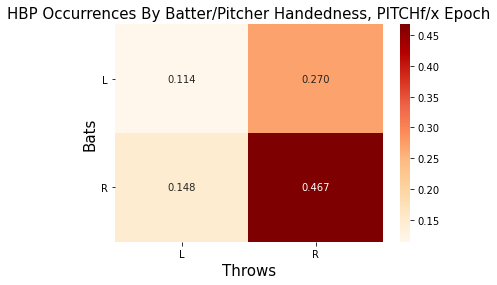

In [163]:
sns.heatmap(pd.crosstab(hbp_3["bats"], hbp_3["throws"], normalize=True), cmap="OrRd", annot=True, fmt='.3f')
plt.title("HBP Occurrences By Batter/Pitcher Handedness, PITCHf/x Epoch", fontsize=15)
plt.xlabel("Throws", fontsize=15)
plt.ylabel("Bats", fontsize=15)
plt.yticks(rotation=0);

# Modeling

In [356]:
# For modeling, will need to use file with dummy codes instead of original variables used above
hbp_d = pd.read_csv('../data/Combined HBP Data - cleaned with dummies.csv', low_memory=False)

In [357]:
hbp_d.columns

Index(['epoch', 'event_id', 'date', 'day', 'year', 'doubleheader',
       'pit_team_is_home', 'game_stat', 'pit_bat', 'pit_id', 'pit_id_y',
       'pitcher', 'pit_first', 'pit_last', 'bat_id', 'bat_id_y', 'batter',
       'bat_first', 'bat_last', 'bat_team_score', 'fld_team_score',
       'fld_team_run_diff', 'pit_team_is_ahead', 'pit_team_is_behind',
       'bases_state', 'risp', 'inning', 'half_inning', 'outs_ct', 'balls',
       'strikes', 'num_pitches', 'pit_count', 'count_status',
       'missing_balls_strikes', 'missing_pit_count', 'missing_pitch_type',
       'velocity', 'missing_velocity', 'low_velocity', 'avg_velocity',
       'high_velocity', 'rbi_on_play', 'win_prob_added', 'base_out_runs_added',
       'leverage_index', 'win_team', 'pit_removed', 'bat_removed',
       'pit_ejected', 'bat_ejected', 'any_ejection', 'ejections_ct', 'umpire',
       'ejections_pl', 'ejection_des', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'p

## Start With PITCHf/x Years, Epoch == 3

In [358]:
# Create dataframe with dummies just for Epoch 3
hbp_d_3 = hbp_d[hbp_d["epoch"] == 3].copy()

In [359]:
hbp_d_3.shape

(19969, 236)

### Set up distance calculations using HEOM distance

In [370]:
X_vars = [
    'month_3', 
    'month_4', 
    'month_5',
    'month_6', 
    'month_7', 
    'month_8', 
    'month_9', 
    'month_10', 
    "doubleheader", 
    "pit_team_is_home", 
    "game_type_Division",
    "game_type_Interleague", 
    "game_type_Intraleague", 
    "game_stat", 
    "throws_L",
    "bats_L", 
    'position_1B', 
    'position_2B', 
    'position_3B',
    'position_C', 
    'position_CF', 
    'position_DH', 
    'position_LF', 
    'position_P',
    'position_PH_PR', 
    'position_RF', 
    'position_SS',
    'position_group_DH_PH_PR', 
    'position_group_Infielder',
    'position_group_Outfielder', 
    'position_group_Pitcher_Catcher',
    'lineup_spot_1', 
    'lineup_spot_2', 
    'lineup_spot_3', 
    'lineup_spot_4',
    'lineup_spot_5', 
    'lineup_spot_6', 
    'lineup_spot_7', 
    'lineup_spot_8',
    'lineup_spot_9', 
    'fld_run_diff_Down by 1 run', 
    'fld_run_diff_Down by 2 to 3 runs',
    'fld_run_diff_Down by 4 to 6 runs',
    'fld_run_diff_Down by 7 or more runs', 
    'fld_run_diff_Tie score',
    'fld_run_diff_Up by 1 run', 
    'fld_run_diff_Up by 2 to 3 runs',
    'fld_run_diff_Up by 4 to 6 runs', 
    'fld_run_diff_Up by 7 or more runs', 
    "pit_team_is_ahead",
    "pit_team_is_behind", 
    'runners_on_1st', 
    'runners_on_1st_2nd', 
    'runners_on_1st_3rd',
    'runners_on_2nd', 
    'runners_on_2nd_3rd', 
    'runners_on_3rd',
    'runners_on_empty', 
    'runners_on_full',  
    "risp", 
    "half_Top", 
    'inning_rec_1', 
    'inning_rec_2', 
    'inning_rec_3', 
    'inning_rec_4',
    'inning_rec_5', 
    'inning_rec_6', 
    'inning_rec_7', 
    'inning_rec_8',
    'inning_rec_9', 
    'inning_rec_10', 
    "outs_ct", 
    "num_pitches",
    'the_count_0-0', 
    'the_count_0-1', 
    'the_count_0-2', 
    'the_count_1-0',
    'the_count_1-1', 
    'the_count_1-2', 
    'the_count_2-0', 
    'the_count_2-1',
    'the_count_2-2', 
    'the_count_3-0', 
    'the_count_3-1', 
    'the_count_3-2',
#     'the_count_Unknown',  (these are all 0s for epoch 3)
    'pitch_type_Changeup (CH)',
    'pitch_type_Curveball (CU, CS)',
    'pitch_type_Cutter (FC)',
    'pitch_type_Fastball (FA)', 
    'pitch_type_Knuckleball (KN)',
    'pitch_type_Sinker (SI)', 
    'pitch_type_Slider (SL, SB)',
    'pitch_type_Splitter (FS)', 
    "velocity", 
    "low_velocity", 
    "avg_velocity", 
    "high_velocity", 
    'velocity_range_70-79 mph',
    'velocity_range_80-89 mph',
    'velocity_range_90-95 mph',
    'velocity_range_96+ mph',
    'velocity_range_Under 70 mph',
    'velocity_range_Unknown',
    "rbi_on_play",
    "win_prob_added",
    "base_out_runs_added",
    "leverage_index",
    'winning_team_Team pitching', 
#     'winning_team_Tie', (these are all 0s for epoch 3)
    "pit_removed", 
    "bat_removed", 
    "pit_ejected", 
    "bat_ejected", 
    "any_ejection",
    "ejections_ct",
    "velocity_missing"
]

In [361]:
hbp_d_3["num_pitches"] = hbp_d_3["num_pitches"].astype('int64')

In [362]:
hbp_d_3["velocity"].replace(np.nan, 999, inplace=True)

In [363]:
hbp_d_3["velocity"].value_counts()

999.0    287
92.2     203
91.4     199
92.1     192
91.7     190
        ... 
102.3      1
60.6       1
101.4      1
58.8       1
69.0       1
Name: velocity, Length: 388, dtype: int64

In [364]:
pd.set_option('display.max_info_columns', 120)
hbp_d_3[X_vars].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19969 entries, 42160 to 62128
Data columns (total 114 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   month_3                              19969 non-null  int64  
 1   month_4                              19969 non-null  int64  
 2   month_5                              19969 non-null  int64  
 3   month_6                              19969 non-null  int64  
 4   month_7                              19969 non-null  int64  
 5   month_8                              19969 non-null  int64  
 6   month_9                              19969 non-null  int64  
 7   month_10                             19969 non-null  int64  
 8   doubleheader                         19969 non-null  int64  
 9   pit_team_is_home                     19969 non-null  int64  
 10  game_type_Division                   19969 non-null  int64  
 11  game_type_Interleague  

In [365]:
hbp_d_3[X_vars]

,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,doubleheader,pit_team_is_home,game_type_Division,game_type_Interleague,game_type_Intraleague,game_stat,throws_L,bats_L,position_1B,position_2B,position_3B,position_C,position_CF,position_DH,position_LF,position_P,position_PH_PR,position_RF,position_SS,position_group_DH_PH_PR,position_group_Infielder,position_group_Outfielder,position_group_Pitcher_Catcher,lineup_spot_1,lineup_spot_2,lineup_spot_3,lineup_spot_4,lineup_spot_5,lineup_spot_6,lineup_spot_7,lineup_spot_8,lineup_spot_9,fld_run_diff_Down by 1 run,fld_run_diff_Down by 2 to 3 runs,fld_run_diff_Down by 4 to 6 runs,fld_run_diff_Down by 7 or more runs,fld_run_diff_Tie score,fld_run_diff_Up by 1 run,fld_run_diff_Up by 2 to 3 runs,fld_run_diff_Up by 4 to 6 runs,fld_run_diff_Up by 7 or more runs,pit_team_is_ahead,...,inning_rec_4,inning_rec_5,inning_rec_6,inning_rec_7,inning_rec_8,inning_rec_9,inning_rec_10,outs_ct,num_pitches,the_count_0-0,the_count_0-1,the_count_0-2,the_count_1-0,the_count_1-1,the_count_1-2,the_count_2-0,the_count_2-1,the_count_2-2,the_count_3-0,the_count_3-1,the_count_3-2,pitch_type_Changeup (CH),"pitch_type_Curveball (CU, CS)",pitch_type_Cutter (FC),pitch_type_Fastball (FA),pitch_type_Knuckleball (KN),pitch_type_Sinker (SI),"pitch_type_Slider (SL, SB)",pitch_type_Splitter (FS),velocity,low_velocity,avg_velocity,high_velocity,velocity_range_70-79 mph,velocity_range_80-89 mph,velocity_range_90-95 mph,velocity_range_96+ mph,velocity_range_Under 70 mph,velocity_range_Unknown,rbi_on_play,win_prob_added,base_out_runs_added,leverage_index,winning_team_Team pitching,pit_removed,bat_removed,pit_ejected,bat_ejected,any_ejection,ejections_ct
42160,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,5,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,999.0,0,0,0,0,0,0,0,0,1,0,0.03,0.39,1.00,1,0,0,0,0,0,0
42161,1,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,999.0,0,0,0,0,0,0,0,0,1,0,0.06,0.62,1.62,0,0,0,0,0,0,0
42162,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,1,5,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,89.1,0,1,0,0,1,0,0,0,0,0,0.05,0.40,2.00,1,0,0,0,0,0,0
42163,1,0,0,0,0,0,0,0,0,1,1,0,0,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,95.5,0,0,1,0,0,1,0,0,0,0,0.08,0.39,2.37,0,0,0,0,0,0,0
42164,1,0,0,0,0,0,0,0,0,1,1,0,0,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,1,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,90.8,0,1,0,0,0,1,0,0,0,0,0.01,0.25,4.29,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62124,0,0,0,0,0,0,1,0,0,0,1,0,0,3,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,2,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,90.7,0,1,0,0,0,1,0,0,0,0,0.00,0.27,0.10,0,0,0,0,0,0,0
62125,0,0,0,0,0,0,1,0,0,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,2,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,92.4,0,1,0,0,0,1,0,0,0,0,0.00,0.13,0.73,1,0,0,0,0,0,0
62126,0,0,0,0,0,0,1,0,0,1,0,0,1,2,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,97.7,0,0,1,0,0,0,1,0,0,0,0.02,0.34,2.26,1,1,0,0,0,0,0
62127,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,

In [366]:
pd.set_option('display.max_rows', 120)
hbp_d_3[X_vars].describe().T

,count,mean,std,min,25%,50%,75%,max
month_3,19969.0,0.005258,0.072324,0.00,0.00,0.00,0.00,1.00
month_4,19969.0,0.150233,0.357308,0.00,0.00,0.00,0.00,1.00
month_5,19969.0,0.168812,0.374595,0.00,0.00,0.00,0.00,1.00
month_6,19969.0,0.164305,0.370561,0.00,0.00,0.00,0.00,1.00
month_7,19969.0,0.158896,0.365589,0.00,0.00,0.00,0.00,1.00
month_8,19969.0,0.177175,0.381826,0.00,0.00,0.00,0.00,1.00
month_9,19969.0,0.166909,0.372904,0.00,0.00,0.00,0.00,1.00
month_10,19969.0,0.008413,0.091338,0.00,0.00,0.00,0.00,1.00
doubleheader,19969.0,0.012519,0.111190,0.00,0.00,0.00,0.00,1.00
pit_team_is_home,19969.0,0.500626,0.500012,0.00,0.00,1.00,1.00,1.00


In [367]:
# Non categorical vars are only 13, 71, 72, 93, 104, 105, 106, 113
cat_index=[0,1,2,3,4,5,6,7,8,9,10,11,12,14,15,16,17,18,19,20,21,22,23,24,25,
           26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,
           51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,73,74,75,
           76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,94,95,96,97,98,99,100,
           101,102,103,107,108,109,110,111,112]
# Calculate HEOM distance - Heterogeneous Euclidean Overlap Metric
# See https://github.com/KacperKubara/distython
nan_equiv = 999
heom_metric = HEOM(hbp_d_3[X_vars], cat_index, nan_equivalents=[nan_equiv], normalised='normal')

### Run HDBSCAN model to uncover clusters

In [263]:
# See https://hdbscan.readthedocs.io/en/latest/index.html for more info on HDBSCAN
clusterer = HDBSCAN(metric=heom_metric.heom)

In [264]:
clusterer.fit(hbp_d_3[X_vars])

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
        approx_min_span_tree=True, cluster_selection_epsilon=0.0,
        cluster_selection_method='eom', core_dist_n_jobs=4,
        gen_min_span_tree=False, leaf_size=40,
        match_reference_implementation=False, memory=Memory(location=None),
        metric=<bound method HEOM.heom of <distython.HEOM.HEOM object at 0x7fabe2443fd0>>,
        min_cluster_size=5, min_samples=None, p=None, prediction_data=False)

In [266]:
clusterer.labels_.max()

13

In [268]:
clusterer.probabilities_

array([0., 0., 0., ..., 0., 0., 0.])

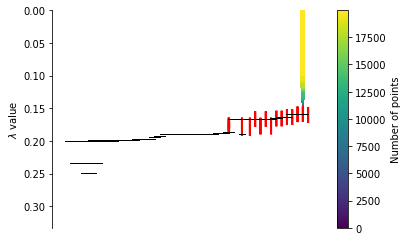

In [272]:
clusterer.condensed_tree_.plot(select_clusters=True,
                               selection_palette=sns.color_palette('deep', 13))

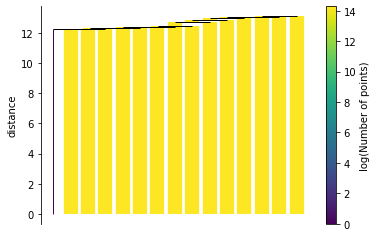

In [274]:
clusterer.single_linkage_tree_.plot(truncate_mode='level', p=13)

In [280]:
hbp_d_3["hdbscan_seg"] = clusterer.labels_
hbp_d_3["hdbscan_seg"].value_counts(normalize=True)

-1     0.886524
 12    0.108368
 13    0.001653
 9     0.000401
 7     0.000351
 5     0.000351
 11    0.000300
 1     0.000300
 10    0.000250
 8     0.000250
 6     0.000250
 4     0.000250
 3     0.000250
 2     0.000250
 0     0.000250
Name: hdbscan_seg, dtype: float64

**NOTE** Ok, so that didn't really work. Will perhaps revisit this approach another time.

In [530]:
# save the model just in case
filename = '../results/initial_hdbscan_model.sav'
pickle.dump(clusterer, open(filename, 'wb'))

### Try k-prototypes model as an alternative

In [368]:
# Set velocity to 0 in place of nan where applicable
hbp_d_3["velocity"].replace(999, 0, inplace=True)
hbp_d_3["velocity"].value_counts()

0.0      287
92.2     203
91.4     199
92.1     192
91.7     190
        ... 
65.0       1
102.1      1
102.9      1
67.3       1
46.6       1
Name: velocity, Length: 388, dtype: int64

In [369]:
hbp_d_3["velocity_missing"] = (hbp_d_3["velocity"] == 0).astype(int)
hbp_d_3["velocity_missing"].value_counts()

0    19682
1      287
Name: velocity_missing, dtype: int64

In [371]:
# Scale data first
ss = StandardScaler()
X_sc = ss.fit_transform(hbp_d_3[X_vars])

In [372]:
hbp_d_3[X_vars].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19969 entries, 42160 to 62128
Data columns (total 115 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   month_3                              19969 non-null  int64  
 1   month_4                              19969 non-null  int64  
 2   month_5                              19969 non-null  int64  
 3   month_6                              19969 non-null  int64  
 4   month_7                              19969 non-null  int64  
 5   month_8                              19969 non-null  int64  
 6   month_9                              19969 non-null  int64  
 7   month_10                             19969 non-null  int64  
 8   doubleheader                         19969 non-null  int64  
 9   pit_team_is_home                     19969 non-null  int64  
 10  game_type_Division                   19969 non-null  int64  
 11  game_type_Interleague  

In [373]:
# Non categorical vars are only 13, 71, 72, 93, 104, 105, 106, 113
cat_index=[0,1,2,3,4,5,6,7,8,9,10,11,12,14,15,16,17,18,19,20,21,22,23,24,25,
           26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,
           51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,73,74,75,
           76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,94,95,96,97,98,99,100,
           101,102,103,107,108,109,110,111,112,114]

In [374]:
# Try an initial 10-cluster solution as a test
# https://medium.com/datadriveninvestor/k-prototype-in-clustering-mixed-attributes-e6907db91914
kproto = KPrototypes(n_clusters=10, init='Cao', gamma=None, verbose=1, random_state=2112, n_jobs=4)
clusters = kproto.fit_predict(X_sc, categorical=cat_index)

Best run was number 10


In [375]:
# Print cluster centroids of the trained model.
print(kproto.cluster_centroids_)
# Print training statistics
print(kproto.cost_)
print(kproto.n_iter_)


[array([[-2.80095361e-01,  8.45130487e-01, -6.18072989e-01,
         2.18146710e-01, -5.16118740e-01, -7.68523771e-01,
        -4.69554180e-01, -6.28340024e-02],
       [-2.71391958e-01, -6.74009664e-01,  1.21173564e+00,
         4.97832887e-02,  1.91965667e-01,  1.70012257e-01,
        -7.13702451e-02, -6.28340024e-02],
       [ 1.03679446e+00, -1.56739080e-01, -4.42834395e-01,
         3.79149762e-01, -4.66171893e-01, -3.28727752e-01,
        -5.34887923e-01,  1.22795876e+01],
       [ 5.92545891e-02, -5.07445958e-02,  5.18762021e-02,
        -7.13972171e+00,  3.59651605e-02,  7.68324234e-02,
         1.06290766e-01, -3.42458914e-02],
       [ 2.43350265e-01, -3.33239714e-01, -2.13824822e-02,
         1.35582525e-01,  2.81453913e+00,  2.35903504e+00,
         2.33691614e+00, -6.28340024e-02],
       [ 2.77867751e+00,  4.19897595e-02, -5.78938805e-02,
         1.11047204e-01, -2.78897594e-01, -3.72200770e-02,
        -3.09854850e-01, -6.28340024e-02],
       [-2.86913008e-01, -8.18935

In [376]:
silhouette_score(X_sc, kproto.labels_)

0.004022105444669264

In [377]:
hbp_d_3["kproto_10"] = kproto.labels_
hbp_d_3["kproto_10"].value_counts(normalize=True)

0    0.181932
8    0.175873
6    0.148280
7    0.146677
1    0.141920
9    0.076919
5    0.059843
4    0.049226
3    0.014272
2    0.005058
Name: kproto_10, dtype: float64

In [378]:
hbp_d_3.groupby("kproto_10")[X_vars].mean().T

kproto_10,0,1,2,3,4,5,6,7,8,9
month_3,0.001927,0.004940,0.009901,0.052632,0.007121,0.003347,0.004728,0.005804,0.003132,0.009766
month_4,0.154418,0.147142,0.128713,0.178947,0.161750,0.134728,0.154677,0.133834,0.154043,0.160807
month_5,0.164878,0.172195,0.188119,0.101754,0.177009,0.175732,0.166836,0.171731,0.173121,0.160807
month_6,0.166254,0.162668,0.138614,0.101754,0.159715,0.168201,0.182371,0.174462,0.150342,0.153646
month_7,0.166529,0.160903,0.118812,0.087719,0.156663,0.167364,0.159743,0.174121,0.142369,0.154948
month_8,0.169282,0.193013,0.198020,0.105263,0.185148,0.184100,0.178656,0.178559,0.172267,0.173828
month_9,0.168731,0.149612,0.207921,0.364912,0.145473,0.157322,0.147923,0.154319,0.195330,0.171875
month_10,0.007982,0.009527,0.009901,0.007018,0.007121,0.009205,0.005066,0.007170,0.009396,0.014323
doubleheader,0.011836,0.014467,0.000000,0.014035,0.015259,0.015063,0.007768,0.015022,0.012528,0.011719
pit_team_is_home,0.600606,0.434721,0.475248,0.491228,0.461851,0.526360,0.379601,0.362922,0.647210,0.554688


In [463]:
hbp_d_3[X_vars].agg([np.mean, np.std]).T

,mean,std
month_3,0.005258,0.072324
month_4,0.150233,0.357308
month_5,0.168812,0.374595
month_6,0.164305,0.370561
month_7,0.158896,0.365589
month_8,0.177175,0.381826
month_9,0.166909,0.372904
month_10,0.008413,0.091338
doubleheader,0.012519,0.111190
pit_team_is_home,0.500626,0.500012


In [379]:
path = "../results/profiles.xlsx"

In [380]:
# https://stackoverflow.com/questions/42370977/how-to-save-a-new-sheet-in-an-existing-excel-file-using-pandas
writer = pd.ExcelWriter(path, engine = 'xlsxwriter')
hbp_d_3.groupby("kproto_10")[X_vars].mean().T.to_excel(writer, sheet_name = 'kproto10_2')
writer.save()
writer.close()

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 4834, ncost: 285849.23336474306
Run: 1, iteration: 2/100, moves: 2877, ncost: 282895.27613270754
Run: 1, iteration: 3/100, moves: 1124, ncost: 282233.47941999417
Run: 1, iteration: 4/100, moves: 254, ncost: 282210.11449315364
Run: 1, iteration: 5/100, moves: 74, ncost: 282205.23256379407
Run: 1, iteration: 6/100, moves: 79, ncost: 282201.25306498125
Run: 1, iteration: 7/100, moves: 49, ncost: 282199.93293317273
Run: 1, iteration: 8/100, moves: 11, ncost: 282199.8768049818
Run: 1, iteration: 9/100, moves: 0, ncost: 282199.8768049818
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 5029, ncost: 284150.6344905349
Run: 2, iteration: 2/100, moves: 2131, ncost: 282827.44346873736
Run: 2, iteration: 3/100, moves: 570, ncost: 282698.009393312
Run: 2, iteration: 4/100, moves: 250, ncost: 282669.2531661386
Run: 2, iterati

Run: 10, iteration: 3/100, moves: 660, ncost: 282443.0682009843
Run: 10, iteration: 4/100, moves: 399, ncost: 282408.7574917967
Run: 10, iteration: 5/100, moves: 135, ncost: 282400.10750192887
Run: 10, iteration: 6/100, moves: 47, ncost: 282398.87946779665
Run: 10, iteration: 7/100, moves: 4, ncost: 282398.8639740543
Run: 10, iteration: 8/100, moves: 0, ncost: 282398.8639740543
Best run was number 1
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 7043, ncost: 273556.7382817364
Run: 1, iteration: 2/100, moves: 3838, ncost: 268411.687570897
Run: 1, iteration: 3/100, moves: 2288, ncost: 266279.62580793904
Run: 1, iteration: 4/100, moves: 1079, ncost: 265721.916067841
Run: 1, iteration: 5/100, moves: 593, ncost: 265571.2812953624
Run: 1, iteration: 6/100, moves: 289, ncost: 265542.6993893396
Run: 1, iteration: 7/100, moves: 127, ncost: 265537.8761069375
Run: 1, iteration: 8/100, moves: 53, ncost: 265537.07389724185
Run: 1, it

Run: 8, iteration: 11/100, moves: 9, ncost: 271720.40074722003
Run: 8, iteration: 12/100, moves: 0, ncost: 271720.40074722003
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 9, iteration: 1/100, moves: 5246, ncost: 268967.99410177453
Run: 9, iteration: 2/100, moves: 2495, ncost: 266251.78457759833
Run: 9, iteration: 3/100, moves: 1618, ncost: 265742.52844121377
Run: 9, iteration: 4/100, moves: 349, ncost: 265667.3225115356
Run: 9, iteration: 5/100, moves: 191, ncost: 265622.93790638115
Run: 9, iteration: 6/100, moves: 110, ncost: 265618.32729601744
Run: 9, iteration: 7/100, moves: 36, ncost: 265617.7018932328
Run: 9, iteration: 8/100, moves: 15, ncost: 265617.5586619014
Run: 9, iteration: 9/100, moves: 12, ncost: 265617.5078261019
Run: 9, iteration: 10/100, moves: 10, ncost: 265617.4626133985
Run: 9, iteration: 11/100, moves: 1, ncost: 265617.46173234493
Run: 9, iteration: 12/100, moves: 3, ncost: 265617.45868162456
Run: 9, iteration: 13/100, moves:

Starting iterations...
Run: 6, iteration: 1/100, moves: 6629, ncost: 273371.1339912598
Run: 6, iteration: 2/100, moves: 4755, ncost: 265095.2244165598
Run: 6, iteration: 3/100, moves: 2183, ncost: 263837.5966231978
Run: 6, iteration: 4/100, moves: 1286, ncost: 262981.97517768334
Run: 6, iteration: 5/100, moves: 1237, ncost: 262378.34443655954
Run: 6, iteration: 6/100, moves: 1384, ncost: 261483.42069033455
Run: 6, iteration: 7/100, moves: 1921, ncost: 259495.92880585903
Run: 6, iteration: 8/100, moves: 2205, ncost: 257060.81097730692
Run: 6, iteration: 9/100, moves: 1327, ncost: 256479.79352629665
Run: 6, iteration: 10/100, moves: 718, ncost: 256283.31060564125
Run: 6, iteration: 11/100, moves: 397, ncost: 256196.69624942882
Run: 6, iteration: 12/100, moves: 279, ncost: 256170.8646998327
Run: 6, iteration: 13/100, moves: 168, ncost: 256159.01311299618
Run: 6, iteration: 14/100, moves: 81, ncost: 256156.71417558452
Run: 6, iteration: 15/100, moves: 33, ncost: 256156.3221777106
Run: 6, i

Run: 1, iteration: 9/100, moves: 124, ncost: 243207.92858810362
Run: 1, iteration: 10/100, moves: 59, ncost: 243206.4280610613
Run: 1, iteration: 11/100, moves: 44, ncost: 243205.7408694225
Run: 1, iteration: 12/100, moves: 12, ncost: 243205.66968688116
Run: 1, iteration: 13/100, moves: 1, ncost: 243205.66884391036
Run: 1, iteration: 14/100, moves: 0, ncost: 243205.66884391036
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 8608, ncost: 246728.45770900225
Run: 2, iteration: 2/100, moves: 1973, ncost: 245017.85787021212
Run: 2, iteration: 3/100, moves: 956, ncost: 244698.6283869015
Run: 2, iteration: 4/100, moves: 726, ncost: 244529.53206364583
Run: 2, iteration: 5/100, moves: 614, ncost: 244159.85094287668
Run: 2, iteration: 6/100, moves: 1223, ncost: 243878.9117225034
Run: 2, iteration: 7/100, moves: 953, ncost: 243529.528514146
Run: 2, iteration: 8/100, moves: 533, ncost: 243467.60585960813
Run: 2, iteration: 9/100, mov

Run: 6, iteration: 22/100, moves: 9, ncost: 241705.82345667618
Run: 6, iteration: 23/100, moves: 7, ncost: 241705.79353684993
Run: 6, iteration: 24/100, moves: 2, ncost: 241705.7782971217
Run: 6, iteration: 25/100, moves: 0, ncost: 241705.7782971217
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 7, iteration: 1/100, moves: 7278, ncost: 246908.62062250247
Run: 7, iteration: 2/100, moves: 2562, ncost: 244634.072980236
Run: 7, iteration: 3/100, moves: 1547, ncost: 243704.59862440955
Run: 7, iteration: 4/100, moves: 890, ncost: 243564.6525333666
Run: 7, iteration: 5/100, moves: 326, ncost: 243535.20253413188
Run: 7, iteration: 6/100, moves: 190, ncost: 243523.7882034147
Run: 7, iteration: 7/100, moves: 106, ncost: 243520.54895510394
Run: 7, iteration: 8/100, moves: 28, ncost: 243520.28808674435
Run: 7, iteration: 9/100, moves: 10, ncost: 243520.23829052396
Run: 7, iteration: 10/100, moves: 0, ncost: 243520.23829052396
Init: initializing centroids
Init:

Run: 2, iteration: 8/100, moves: 1114, ncost: 234905.7179528828
Run: 2, iteration: 9/100, moves: 508, ncost: 234866.64635399487
Run: 2, iteration: 10/100, moves: 193, ncost: 234856.62884250973
Run: 2, iteration: 11/100, moves: 140, ncost: 234850.07039588384
Run: 2, iteration: 12/100, moves: 66, ncost: 234848.18458944093
Run: 2, iteration: 13/100, moves: 35, ncost: 234847.1927758323
Run: 2, iteration: 14/100, moves: 31, ncost: 234846.67992610208
Run: 2, iteration: 15/100, moves: 31, ncost: 234846.16127755522
Run: 2, iteration: 16/100, moves: 24, ncost: 234845.79834270052
Run: 2, iteration: 17/100, moves: 15, ncost: 234845.7061159215
Run: 2, iteration: 18/100, moves: 4, ncost: 234845.69456009456
Run: 2, iteration: 19/100, moves: 1, ncost: 234845.69386360666
Run: 2, iteration: 20/100, moves: 0, ncost: 234845.69386360666
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 9877, ncost: 248606.73851397377
Run: 3, iteration: 2/100, 

Run: 7, iteration: 8/100, moves: 76, ncost: 235093.47987580663
Run: 7, iteration: 9/100, moves: 71, ncost: 235091.8481943218
Run: 7, iteration: 10/100, moves: 55, ncost: 235090.77570027835
Run: 7, iteration: 11/100, moves: 62, ncost: 235089.371031091
Run: 7, iteration: 12/100, moves: 94, ncost: 235085.53111353487
Run: 7, iteration: 13/100, moves: 74, ncost: 235083.90994776392
Run: 7, iteration: 14/100, moves: 27, ncost: 235083.6367378449
Run: 7, iteration: 15/100, moves: 10, ncost: 235083.58426073674
Run: 7, iteration: 16/100, moves: 5, ncost: 235083.55732510166
Run: 7, iteration: 17/100, moves: 3, ncost: 235083.54629868577
Run: 7, iteration: 18/100, moves: 0, ncost: 235083.54629868577
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 8, iteration: 1/100, moves: 6979, ncost: 241196.83472273525
Run: 8, iteration: 2/100, moves: 3167, ncost: 238319.24076555326
Run: 8, iteration: 3/100, moves: 2257, ncost: 236488.21716814945
Run: 8, iteration: 4/100, move

Run: 1, iteration: 28/100, moves: 127, ncost: 230848.73236131316
Run: 1, iteration: 29/100, moves: 166, ncost: 230780.82874673675
Run: 1, iteration: 30/100, moves: 107, ncost: 230767.23107382862
Run: 1, iteration: 31/100, moves: 94, ncost: 230672.7034041639
Run: 1, iteration: 32/100, moves: 28, ncost: 230669.6145423783
Run: 1, iteration: 33/100, moves: 13, ncost: 230644.7687442894
Run: 1, iteration: 34/100, moves: 34, ncost: 230439.13344284325
Run: 1, iteration: 35/100, moves: 29, ncost: 230401.6386818144
Run: 1, iteration: 36/100, moves: 6, ncost: 230401.60303660636
Run: 1, iteration: 37/100, moves: 6, ncost: 230401.57324500944
Run: 1, iteration: 38/100, moves: 5, ncost: 230401.54962542676
Run: 1, iteration: 39/100, moves: 0, ncost: 230401.54962542676
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 9301, ncost: 232937.85980487912
Run: 2, iteration: 2/100, moves: 2384, ncost: 231781.0084288639
Run: 2, iteration: 3/100, mo

Run: 6, iteration: 37/100, moves: 11, ncost: 229539.092799795
Run: 6, iteration: 38/100, moves: 15, ncost: 229539.01527700183
Run: 6, iteration: 39/100, moves: 7, ncost: 229538.98146518803
Run: 6, iteration: 40/100, moves: 6, ncost: 229538.95714945867
Run: 6, iteration: 41/100, moves: 2, ncost: 229538.95199967592
Run: 6, iteration: 42/100, moves: 3, ncost: 229538.94578145817
Run: 6, iteration: 43/100, moves: 0, ncost: 229538.94578145817
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 7, iteration: 1/100, moves: 8662, ncost: 234225.45722908675
Run: 7, iteration: 2/100, moves: 2857, ncost: 231830.7316796409
Run: 7, iteration: 3/100, moves: 1748, ncost: 231056.13147220982
Run: 7, iteration: 4/100, moves: 777, ncost: 230860.21152599543
Run: 7, iteration: 5/100, moves: 374, ncost: 230807.99052573345
Run: 7, iteration: 6/100, moves: 206, ncost: 230675.20086112493
Run: 7, iteration: 7/100, moves: 461, ncost: 230553.50982840432
Run: 7, iteration: 8/100, mov

Run: 10, iteration: 21/100, moves: 6, ncost: 230277.5783994624
Run: 10, iteration: 22/100, moves: 12, ncost: 230277.5369738442
Run: 10, iteration: 23/100, moves: 3, ncost: 230277.53137666162
Run: 10, iteration: 24/100, moves: 0, ncost: 230277.53137666162
Best run was number 4
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 9513, ncost: 239194.69791272064
Run: 1, iteration: 2/100, moves: 3492, ncost: 235831.69568369284
Run: 1, iteration: 3/100, moves: 1933, ncost: 230311.8570688106
Run: 1, iteration: 4/100, moves: 1286, ncost: 227693.27242385835
Run: 1, iteration: 5/100, moves: 727, ncost: 227257.1358917559
Run: 1, iteration: 6/100, moves: 506, ncost: 227144.36563339073
Run: 1, iteration: 7/100, moves: 332, ncost: 227069.86468221634
Run: 1, iteration: 8/100, moves: 321, ncost: 227003.17187216494
Run: 1, iteration: 9/100, moves: 176, ncost: 226960.11246896995
Run: 1, iteration: 10/100, moves: 154, ncost: 226902.66933107335


Init: initializing clusters
Starting iterations...
Run: 5, iteration: 1/100, moves: 8274, ncost: 233205.38278637914
Run: 5, iteration: 2/100, moves: 3058, ncost: 228262.41248348996
Run: 5, iteration: 3/100, moves: 1456, ncost: 227752.93818064328
Run: 5, iteration: 4/100, moves: 831, ncost: 227433.39674092457
Run: 5, iteration: 5/100, moves: 723, ncost: 226631.92557170795
Run: 5, iteration: 6/100, moves: 710, ncost: 216794.17896413285
Run: 5, iteration: 7/100, moves: 486, ncost: 216479.4844966774
Run: 5, iteration: 8/100, moves: 403, ncost: 216393.68544316178
Run: 5, iteration: 9/100, moves: 281, ncost: 216359.9080690133
Run: 5, iteration: 10/100, moves: 300, ncost: 216275.31646730338
Run: 5, iteration: 11/100, moves: 264, ncost: 216192.62962173353
Run: 5, iteration: 12/100, moves: 314, ncost: 216127.77802284653
Run: 5, iteration: 13/100, moves: 232, ncost: 216039.72898175215
Run: 5, iteration: 14/100, moves: 176, ncost: 216010.0568472247
Run: 5, iteration: 15/100, moves: 117, ncost: 21

Run: 1, iteration: 3/100, moves: 1836, ncost: 222540.26147819712
Run: 1, iteration: 4/100, moves: 748, ncost: 222367.53108053497
Run: 1, iteration: 5/100, moves: 432, ncost: 222147.55686367443
Run: 1, iteration: 6/100, moves: 398, ncost: 222001.22316963656
Run: 1, iteration: 7/100, moves: 240, ncost: 221973.83466305645
Run: 1, iteration: 8/100, moves: 210, ncost: 221888.2187156857
Run: 1, iteration: 9/100, moves: 311, ncost: 221805.86074686158
Run: 1, iteration: 10/100, moves: 118, ncost: 221799.04164835907
Run: 1, iteration: 11/100, moves: 26, ncost: 221798.16564426944
Run: 1, iteration: 12/100, moves: 9, ncost: 221798.0139998354
Run: 1, iteration: 13/100, moves: 0, ncost: 221798.0139998354
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 7822, ncost: 225126.50889003163
Run: 2, iteration: 2/100, moves: 2967, ncost: 223177.12673346567
Run: 2, iteration: 3/100, moves: 1692, ncost: 222318.0170183171
Run: 2, iteration: 4/100,

Run: 6, iteration: 13/100, moves: 253, ncost: 222142.7859007439
Run: 6, iteration: 14/100, moves: 182, ncost: 222135.98039739358
Run: 6, iteration: 15/100, moves: 134, ncost: 222132.1836984627
Run: 6, iteration: 16/100, moves: 78, ncost: 222130.59217457552
Run: 6, iteration: 17/100, moves: 74, ncost: 222129.13977801494
Run: 6, iteration: 18/100, moves: 42, ncost: 222128.53672968547
Run: 6, iteration: 19/100, moves: 43, ncost: 222128.10634917405
Run: 6, iteration: 20/100, moves: 33, ncost: 222127.76414800048
Run: 6, iteration: 21/100, moves: 22, ncost: 222127.6411654467
Run: 6, iteration: 22/100, moves: 16, ncost: 222127.56893174563
Run: 6, iteration: 23/100, moves: 5, ncost: 222127.54314278899
Run: 6, iteration: 24/100, moves: 1, ncost: 222127.54085191822
Run: 6, iteration: 25/100, moves: 0, ncost: 222127.54085191822
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 7, iteration: 1/100, moves: 8347, ncost: 228348.3849463268
Run: 7, iteration: 2/100, m

Run: 1, iteration: 5/100, moves: 335, ncost: 207156.42918963826
Run: 1, iteration: 6/100, moves: 227, ncost: 207126.55485778625
Run: 1, iteration: 7/100, moves: 152, ncost: 207109.63368492704
Run: 1, iteration: 8/100, moves: 120, ncost: 207099.47375162932
Run: 1, iteration: 9/100, moves: 115, ncost: 207092.18908691296
Run: 1, iteration: 10/100, moves: 70, ncost: 207089.30933045378
Run: 1, iteration: 11/100, moves: 45, ncost: 207087.62154218234
Run: 1, iteration: 12/100, moves: 30, ncost: 207086.44450366506
Run: 1, iteration: 13/100, moves: 37, ncost: 207084.74831993962
Run: 1, iteration: 14/100, moves: 32, ncost: 207083.3540974225
Run: 1, iteration: 15/100, moves: 35, ncost: 207082.0468580571
Run: 1, iteration: 16/100, moves: 21, ncost: 207081.46804389003
Run: 1, iteration: 17/100, moves: 12, ncost: 207081.28632129435
Run: 1, iteration: 18/100, moves: 11, ncost: 207081.06078287808
Run: 1, iteration: 19/100, moves: 11, ncost: 207080.8314950452
Run: 1, iteration: 20/100, moves: 10, ncost

Init: initializing clusters
Starting iterations...
Run: 7, iteration: 1/100, moves: 8724, ncost: 224189.08563920992
Run: 7, iteration: 2/100, moves: 3052, ncost: 222007.02262459858
Run: 7, iteration: 3/100, moves: 1811, ncost: 220516.72881028018
Run: 7, iteration: 4/100, moves: 1357, ncost: 211430.54377310383
Run: 7, iteration: 5/100, moves: 744, ncost: 208938.78041836107
Run: 7, iteration: 6/100, moves: 543, ncost: 208765.7211970278
Run: 7, iteration: 7/100, moves: 982, ncost: 208417.72855681228
Run: 7, iteration: 8/100, moves: 530, ncost: 208357.93813230467
Run: 7, iteration: 9/100, moves: 267, ncost: 208273.82404904815
Run: 7, iteration: 10/100, moves: 99, ncost: 208271.3082370587
Run: 7, iteration: 11/100, moves: 55, ncost: 208270.20847632806
Run: 7, iteration: 12/100, moves: 46, ncost: 208269.26919732208
Run: 7, iteration: 13/100, moves: 42, ncost: 208268.53950868305
Run: 7, iteration: 14/100, moves: 24, ncost: 208268.30392275914
Run: 7, iteration: 15/100, moves: 11, ncost: 208268

Run: 10, iteration: 5/100, moves: 862, ncost: 220022.4140628624
Run: 10, iteration: 6/100, moves: 658, ncost: 219157.64908088683
Run: 10, iteration: 7/100, moves: 706, ncost: 209289.66201113616
Run: 10, iteration: 8/100, moves: 513, ncost: 208847.33034296596
Run: 10, iteration: 9/100, moves: 428, ncost: 208773.1716839457
Run: 10, iteration: 10/100, moves: 316, ncost: 208723.61457316208
Run: 10, iteration: 11/100, moves: 276, ncost: 208689.72850547655
Run: 10, iteration: 12/100, moves: 298, ncost: 208630.52407555122
Run: 10, iteration: 13/100, moves: 290, ncost: 208570.49302768422
Run: 10, iteration: 14/100, moves: 202, ncost: 208535.49750152402
Run: 10, iteration: 15/100, moves: 139, ncost: 208455.35629913397
Run: 10, iteration: 16/100, moves: 53, ncost: 208454.6338849017
Run: 10, iteration: 17/100, moves: 47, ncost: 208453.64457957004
Run: 10, iteration: 18/100, moves: 61, ncost: 208451.80701752147
Run: 10, iteration: 19/100, moves: 73, ncost: 208450.21683663593
Run: 10, iteration: 20

Run: 3, iteration: 15/100, moves: 365, ncost: 204444.9203624869
Run: 3, iteration: 16/100, moves: 328, ncost: 204411.55312732584
Run: 3, iteration: 17/100, moves: 317, ncost: 204376.12275667614
Run: 3, iteration: 18/100, moves: 352, ncost: 204326.97564039894
Run: 3, iteration: 19/100, moves: 484, ncost: 204204.43854904617
Run: 3, iteration: 20/100, moves: 689, ncost: 204013.08657478672
Run: 3, iteration: 21/100, moves: 747, ncost: 203763.25476875776
Run: 3, iteration: 22/100, moves: 619, ncost: 203682.7939226895
Run: 3, iteration: 23/100, moves: 410, ncost: 203645.86091390543
Run: 3, iteration: 24/100, moves: 294, ncost: 203623.084170531
Run: 3, iteration: 25/100, moves: 262, ncost: 203605.440147202
Run: 3, iteration: 26/100, moves: 205, ncost: 203594.60505619907
Run: 3, iteration: 27/100, moves: 235, ncost: 203580.68494949906
Run: 3, iteration: 28/100, moves: 252, ncost: 203567.91276475845
Run: 3, iteration: 29/100, moves: 165, ncost: 203562.08794999376
Run: 3, iteration: 30/100, move

Run: 8, iteration: 7/100, moves: 730, ncost: 205087.49067829797
Run: 8, iteration: 8/100, moves: 502, ncost: 205048.4278110307
Run: 8, iteration: 9/100, moves: 329, ncost: 205020.2334949062
Run: 8, iteration: 10/100, moves: 303, ncost: 205000.43898430956
Run: 8, iteration: 11/100, moves: 238, ncost: 204986.8783091278
Run: 8, iteration: 12/100, moves: 204, ncost: 204974.96618526537
Run: 8, iteration: 13/100, moves: 144, ncost: 204967.63677315362
Run: 8, iteration: 14/100, moves: 130, ncost: 204957.75724070423
Run: 8, iteration: 15/100, moves: 188, ncost: 204942.79220492268
Run: 8, iteration: 16/100, moves: 244, ncost: 204920.9365061719
Run: 8, iteration: 17/100, moves: 382, ncost: 204722.51791601224
Run: 8, iteration: 18/100, moves: 794, ncost: 204609.89461771844
Run: 8, iteration: 19/100, moves: 498, ncost: 204529.09126510358
Run: 8, iteration: 20/100, moves: 394, ncost: 204463.29123568555
Run: 8, iteration: 21/100, moves: 396, ncost: 204415.738426006
Run: 8, iteration: 22/100, moves: 

Run: 3, iteration: 16/100, moves: 19, ncost: 200756.8088455257
Run: 3, iteration: 17/100, moves: 15, ncost: 200756.67581010613
Run: 3, iteration: 18/100, moves: 16, ncost: 200756.53082083265
Run: 3, iteration: 19/100, moves: 14, ncost: 200756.44941635354
Run: 3, iteration: 20/100, moves: 7, ncost: 200756.4319654673
Run: 3, iteration: 21/100, moves: 1, ncost: 200756.42934786537
Run: 3, iteration: 22/100, moves: 0, ncost: 200756.42934786537
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 4, iteration: 1/100, moves: 9938, ncost: 214143.64704747932
Run: 4, iteration: 2/100, moves: 3731, ncost: 205898.223107859
Run: 4, iteration: 3/100, moves: 1645, ncost: 203484.27711019086
Run: 4, iteration: 4/100, moves: 1042, ncost: 203107.35685677762
Run: 4, iteration: 5/100, moves: 652, ncost: 202949.2869035363
Run: 4, iteration: 6/100, moves: 457, ncost: 202863.27352981787
Run: 4, iteration: 7/100, moves: 330, ncost: 202791.76012279635
Run: 4, iteration: 8/100, mo

Run: 7, iteration: 12/100, moves: 433, ncost: 201741.6284362458
Run: 7, iteration: 13/100, moves: 92, ncost: 201728.00367078703
Run: 7, iteration: 14/100, moves: 43, ncost: 201726.8406274015
Run: 7, iteration: 15/100, moves: 47, ncost: 201724.56877457668
Run: 7, iteration: 16/100, moves: 34, ncost: 201723.7526504641
Run: 7, iteration: 17/100, moves: 34, ncost: 201723.31157436612
Run: 7, iteration: 18/100, moves: 35, ncost: 201722.8065807413
Run: 7, iteration: 19/100, moves: 22, ncost: 201722.55491578262
Run: 7, iteration: 20/100, moves: 10, ncost: 201722.50145975765
Run: 7, iteration: 21/100, moves: 5, ncost: 201722.49274804187
Run: 7, iteration: 22/100, moves: 4, ncost: 201722.483962454
Run: 7, iteration: 23/100, moves: 3, ncost: 201722.48002783977
Run: 7, iteration: 24/100, moves: 1, ncost: 201722.47851506795
Run: 7, iteration: 25/100, moves: 0, ncost: 201722.47851506795
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 8, iteration: 1/100, moves: 9

Run: 3, iteration: 7/100, moves: 286, ncost: 199565.1603376615
Run: 3, iteration: 8/100, moves: 204, ncost: 199555.11077327517
Run: 3, iteration: 9/100, moves: 549, ncost: 199356.01935542727
Run: 3, iteration: 10/100, moves: 428, ncost: 199325.16927400092
Run: 3, iteration: 11/100, moves: 149, ncost: 199317.51276571976
Run: 3, iteration: 12/100, moves: 97, ncost: 199314.5119880368
Run: 3, iteration: 13/100, moves: 52, ncost: 199313.01855828616
Run: 3, iteration: 14/100, moves: 40, ncost: 199312.1122235227
Run: 3, iteration: 15/100, moves: 37, ncost: 199311.07359924403
Run: 3, iteration: 16/100, moves: 36, ncost: 199310.04291344556
Run: 3, iteration: 17/100, moves: 14, ncost: 199309.87009272157
Run: 3, iteration: 18/100, moves: 9, ncost: 199309.73693256025
Run: 3, iteration: 19/100, moves: 5, ncost: 199309.69043140765
Run: 3, iteration: 20/100, moves: 6, ncost: 199309.6547762407
Run: 3, iteration: 21/100, moves: 4, ncost: 199309.62775823253
Run: 3, iteration: 22/100, moves: 6, ncost: 19

Run: 8, iteration: 15/100, moves: 272, ncost: 199274.9238775297
Run: 8, iteration: 16/100, moves: 276, ncost: 199249.46248034167
Run: 8, iteration: 17/100, moves: 224, ncost: 199228.44708153873
Run: 8, iteration: 18/100, moves: 301, ncost: 199198.75681164875
Run: 8, iteration: 19/100, moves: 268, ncost: 199176.850310657
Run: 8, iteration: 20/100, moves: 246, ncost: 199155.41816182135
Run: 8, iteration: 21/100, moves: 256, ncost: 199133.07042769543
Run: 8, iteration: 22/100, moves: 272, ncost: 199109.29151367416
Run: 8, iteration: 23/100, moves: 278, ncost: 199090.27667315086
Run: 8, iteration: 24/100, moves: 230, ncost: 199077.8132980171
Run: 8, iteration: 25/100, moves: 257, ncost: 199062.67027546803
Run: 8, iteration: 26/100, moves: 339, ncost: 199034.47169337884
Run: 8, iteration: 27/100, moves: 350, ncost: 199007.4311088622
Run: 8, iteration: 28/100, moves: 278, ncost: 198993.92803365612
Run: 8, iteration: 29/100, moves: 185, ncost: 198988.53690763604
Run: 8, iteration: 30/100, mov

Run: 2, iteration: 4/100, moves: 1019, ncost: 197108.24430965623
Run: 2, iteration: 5/100, moves: 545, ncost: 197047.9365675783
Run: 2, iteration: 6/100, moves: 358, ncost: 197012.09983909965
Run: 2, iteration: 7/100, moves: 253, ncost: 196997.3011913483
Run: 2, iteration: 8/100, moves: 141, ncost: 196992.6450894571
Run: 2, iteration: 9/100, moves: 88, ncost: 196989.18039272743
Run: 2, iteration: 10/100, moves: 108, ncost: 196984.83367480867
Run: 2, iteration: 11/100, moves: 84, ncost: 196982.3012598379
Run: 2, iteration: 12/100, moves: 54, ncost: 196981.17862710418
Run: 2, iteration: 13/100, moves: 51, ncost: 196980.19536837147
Run: 2, iteration: 14/100, moves: 46, ncost: 196978.87112053487
Run: 2, iteration: 15/100, moves: 55, ncost: 196977.4109446206
Run: 2, iteration: 16/100, moves: 44, ncost: 196976.7962986136
Run: 2, iteration: 17/100, moves: 34, ncost: 196976.14064808554
Run: 2, iteration: 18/100, moves: 47, ncost: 196974.7519719973
Run: 2, iteration: 19/100, moves: 82, ncost: 1

Run: 4, iteration: 39/100, moves: 14, ncost: 197788.54942017302
Run: 4, iteration: 40/100, moves: 6, ncost: 197788.49669378749
Run: 4, iteration: 41/100, moves: 6, ncost: 197788.45775873374
Run: 4, iteration: 42/100, moves: 12, ncost: 197788.38259950228
Run: 4, iteration: 43/100, moves: 7, ncost: 197788.35502489982
Run: 4, iteration: 44/100, moves: 3, ncost: 197788.34674698478
Run: 4, iteration: 45/100, moves: 3, ncost: 197788.3354434602
Run: 4, iteration: 46/100, moves: 1, ncost: 197788.3337546509
Run: 4, iteration: 47/100, moves: 0, ncost: 197788.3337546509
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 5, iteration: 1/100, moves: 8782, ncost: 201515.21767976432
Run: 5, iteration: 2/100, moves: 3292, ncost: 199258.55527298982
Run: 5, iteration: 3/100, moves: 1885, ncost: 198288.23660451485
Run: 5, iteration: 4/100, moves: 1112, ncost: 197985.11561388982
Run: 5, iteration: 5/100, moves: 801, ncost: 197687.43045393148
Run: 5, iteration: 6/100, move

Run: 7, iteration: 39/100, moves: 1, ncost: 196246.54167292442
Run: 7, iteration: 40/100, moves: 0, ncost: 196246.54167292442
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 8, iteration: 1/100, moves: 10494, ncost: 201561.12443715878
Run: 8, iteration: 2/100, moves: 3742, ncost: 199582.37122529143
Run: 8, iteration: 3/100, moves: 2284, ncost: 198714.7292377026
Run: 8, iteration: 4/100, moves: 1619, ncost: 198182.21017725058
Run: 8, iteration: 5/100, moves: 1257, ncost: 197778.80391298974
Run: 8, iteration: 6/100, moves: 729, ncost: 197642.0111113323
Run: 8, iteration: 7/100, moves: 542, ncost: 197429.48597810575
Run: 8, iteration: 8/100, moves: 390, ncost: 197369.1493743204
Run: 8, iteration: 9/100, moves: 228, ncost: 197349.26147379383
Run: 8, iteration: 10/100, moves: 184, ncost: 197337.0795753128
Run: 8, iteration: 11/100, moves: 156, ncost: 197326.12055591567
Run: 8, iteration: 12/100, moves: 144, ncost: 197318.4736581873
Run: 8, iteration: 13/

Run: 10, iteration: 29/100, moves: 112, ncost: 196711.1456521798
Run: 10, iteration: 30/100, moves: 127, ncost: 196707.0517625359
Run: 10, iteration: 31/100, moves: 109, ncost: 196704.49808774842
Run: 10, iteration: 32/100, moves: 51, ncost: 196703.87433477573
Run: 10, iteration: 33/100, moves: 32, ncost: 196703.57127297885
Run: 10, iteration: 34/100, moves: 13, ncost: 196703.49590141635
Run: 10, iteration: 35/100, moves: 4, ncost: 196703.48107725242
Run: 10, iteration: 36/100, moves: 0, ncost: 196703.48107725242
Best run was number 9


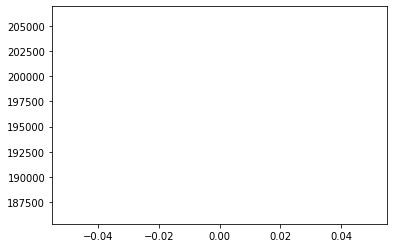

In [401]:
# Try a variation of Tim Book's function for "grid searching" k-means
scores = []
for k in range(2, 15):
    cl = KPrototypes(n_clusters=k, init='Cao', gamma=None, verbose=2, random_state=2112, n_jobs=1)
    cl.fit_predict(X_sc, categorical=cat_index)
#     inertia = cl.inertia_   # unfortunately k-prototypes doesn't compute inertia 
    cost = cl.cost_
    sil = silhouette_score(X_sc, cl.labels_)
    scores.append([k, cost, sil])
    
score_df = pd.DataFrame(scores)
score_df.columns = ['k', 'cost', 'silhouette']
plt.plot(cost)

In [408]:
score_df

,k,cost,silhouette
0,2,282199.876805,0.016843
1,3,265358.181760,0.010789
2,4,249725.281249,0.010870
3,5,241705.778297,0.006769
4,6,227789.688412,0.011503
5,7,220018.545747,0.005729
6,8,215010.970129,0.009678
7,9,210788.422011,0.006502
8,10,206918.655689,0.004022
9,11,203283.353699,0.004231


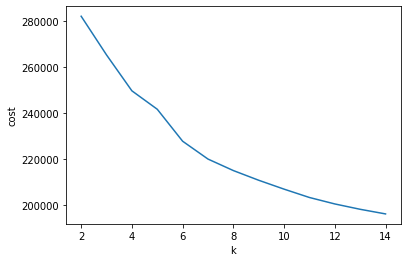

In [411]:
sns.lineplot(x="k", y="cost", data=score_df)

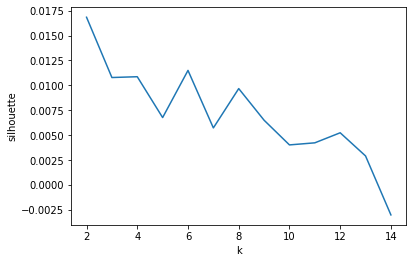

In [412]:
sns.lineplot(x="k", y="silhouette", data=score_df)

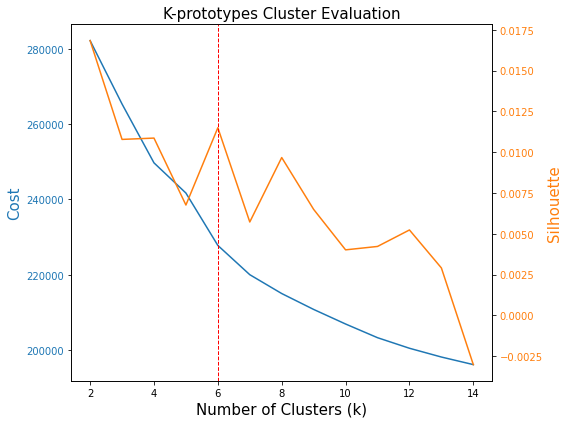

In [429]:
fig, ax1 = plt.subplots(figsize=(8,6))

color = 'tab:blue'
ax1.set_xlabel('Number of Clusters (k)', fontsize=15)
ax1.set_ylabel('Cost', color=color, fontsize=15)
ax1.plot("k", "cost", data=score_df, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:orange'
ax2.set_ylabel('Silhouette', color=color, fontsize=15)  # we already handled the x-label with ax1
ax2.plot("k", "silhouette", data=score_df, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title("K-prototypes Cluster Evaluation", fontsize=15)
plt.axvline(x=6, linewidth=1, color='red', ls='dashed')


fig.tight_layout() 

In [430]:
kproto = KPrototypes(n_clusters=6, init='Cao', gamma=None, verbose=1, random_state=2112)
clusters = kproto.fit_predict(X_sc, categorical=cat_index)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 9463, ncost: 250410.71117239667
Run: 1, iteration: 2/100, moves: 4539, ncost: 246227.4064110997
Run: 1, iteration: 3/100, moves: 2199, ncost: 244890.2865690078
Run: 1, iteration: 4/100, moves: 1375, ncost: 243974.45730393086
Run: 1, iteration: 5/100, moves: 908, ncost: 243698.81247234205
Run: 1, iteration: 6/100, moves: 401, ncost: 243603.21165767877
Run: 1, iteration: 7/100, moves: 150, ncost: 243588.95124367886
Run: 1, iteration: 8/100, moves: 74, ncost: 243585.27985672982
Run: 1, iteration: 9/100, moves: 36, ncost: 243584.38849348386
Run: 1, iteration: 10/100, moves: 7, ncost: 243584.3232100917
Run: 1, iteration: 11/100, moves: 1, ncost: 243584.3170403898
Run: 1, iteration: 12/100, moves: 0, ncost: 243584.3170403898
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 9552, ncost: 240962.65492289662
Run: 2, itera

Run: 5, iteration: 40/100, moves: 0, ncost: 234555.23014452463
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 6, iteration: 1/100, moves: 7874, ncost: 241390.11850559674
Run: 6, iteration: 2/100, moves: 3794, ncost: 236572.33886954776
Run: 6, iteration: 3/100, moves: 1692, ncost: 235157.68901721836
Run: 6, iteration: 4/100, moves: 743, ncost: 234972.732771231
Run: 6, iteration: 5/100, moves: 204, ncost: 234945.02828921343
Run: 6, iteration: 6/100, moves: 93, ncost: 234939.48347949318
Run: 6, iteration: 7/100, moves: 54, ncost: 234938.32635392863
Run: 6, iteration: 8/100, moves: 17, ncost: 234938.17230589053
Run: 6, iteration: 9/100, moves: 16, ncost: 234938.07787054998
Run: 6, iteration: 10/100, moves: 2, ncost: 234938.07098827328
Run: 6, iteration: 11/100, moves: 0, ncost: 234938.07098827328
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 7, iteration: 1/100, moves: 8134, ncost: 238469.6288829325
Run: 7, iterat

In [431]:
print(kproto.cost_)
print(kproto.n_iter_)
print(silhouette_score(X_sc, kproto.labels_))

227789.68841220485
17
0.011503228669410432


In [432]:
hbp_d_3["kproto_6"] = kproto.labels_
hbp_d_3["kproto_6"].value_counts(normalize=True)

0    0.336271
1    0.327608
4    0.210727
5    0.106014
2    0.014322
3    0.005058
Name: kproto_6, dtype: float64

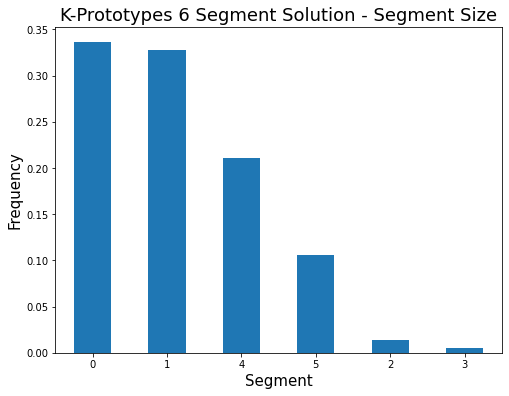

In [522]:
plt.figure(figsize=(8, 6))
hbp_d_3["kproto_6"].value_counts(normalize=True).plot(kind="bar")
plt.title("K-Prototypes 6 Segment Solution - Segment Size", fontsize=18)
plt.xlabel("Segment", fontsize=15)
plt.xticks(rotation=0)
plt.ylabel("Frequency", fontsize=15);

In [434]:
kproto_8 = KPrototypes(n_clusters=8, init='Cao', gamma=None, verbose=0, random_state=2112)
clusters_8 = kproto_8.fit_predict(X_sc, categorical=cat_index)

In [435]:
print(kproto_8.n_iter_)
print(silhouette_score(X_sc, kproto_8.labels_))

15
0.009677980581945196


In [436]:
hbp_d_3["kproto_8"] = kproto_8.labels_
hbp_d_3["kproto_8"].value_counts(normalize=True)

0    0.285993
7    0.239621
4    0.181331
1    0.117132
5    0.091542
6    0.065051
2    0.014272
3    0.005058
Name: kproto_8, dtype: float64

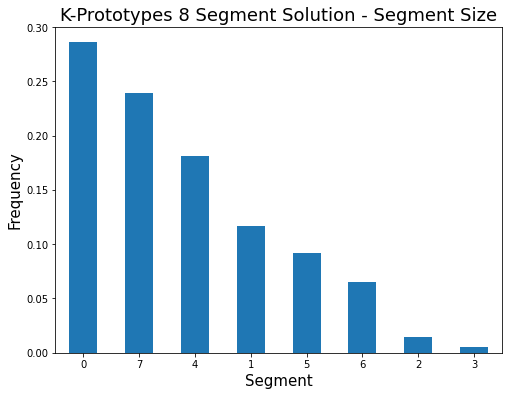

In [521]:
plt.figure(figsize=(8, 6))
hbp_d_3["kproto_8"].value_counts(normalize=True).plot(kind="bar")
plt.title("K-Prototypes 8 Segment Solution - Segment Size", fontsize=18)
plt.xlabel("Segment", fontsize=15)
plt.xticks(rotation=0)
plt.ylabel("Frequency", fontsize=15);

In [454]:
book = load_workbook(path)
writer = pd.ExcelWriter(path, engine = 'openpyxl')
writer.book = book

hbp_d_3.groupby("kproto_6")[X_vars].mean().T.to_excel(writer, sheet_name = 'kproto_6')
hbp_d_3.groupby("kproto_8")[X_vars].mean().T.to_excel(writer, sheet_name = 'kproto_8')
writer.save()
writer.close()

In [481]:
pd.crosstab(hbp_d_3["kproto_8"], hbp_d_3["kproto_6"], margins=True, margins_name="Total")

kproto_6,0,1,2,3,4,5,Total
kproto_8,,,,,,,
0,5162,95,0,0,228,226,5711
1,917,896,0,0,428,98,2339
2,0,0,285,0,0,0,285
3,0,0,0,101,0,0,101
4,49,368,0,0,3204,0,3621
5,250,791,0,0,283,504,1828
6,8,0,1,0,1,1289,1299
7,329,4392,0,0,64,0,4785
Total,6715,6542,286,101,4208,2117,19969


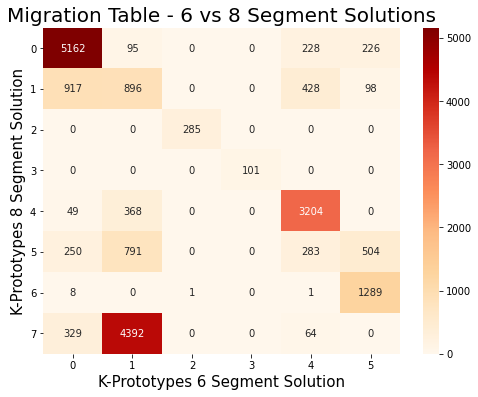

In [475]:
plt.figure(figsize=(8,6))
sns.heatmap(pd.crosstab(hbp_d_3["kproto_8"], hbp_d_3["kproto_6"]), cmap="OrRd", annot=True, fmt='d')
plt.title("Migration Table - 6 vs 8 Segment Solutions", fontsize=20)
plt.xlabel("K-Prototypes 6 Segment Solution", fontsize=15)
plt.ylabel("K-Prototypes 8 Segment Solution", fontsize=15)
plt.yticks(rotation=0);

In [526]:
hbp_d_3.to_csv('../data/temporary file with initial k-p segments.csv', index=False)

In [531]:
# save the models just in case
filename1 = '../results/kproto_6_model.sav'
pickle.dump(kproto, open(filename1, 'wb'))

filename2 = '../results/kproto_8_model.sav'
pickle.dump(kproto_8, open(filename2, 'wb'))

### Principal Components

In [381]:
pca = PCA(random_state=2112)
Z = pca.fit_transform(X_sc)

In [385]:
# Pull the explained variance attribute.
var_exp = pca.explained_variance_ratio_
print(f'Explained variance (first 30 components): {np.round(var_exp[:30],3)}')

print('')

# Generate the cumulative explained variance.
cum_var_exp = np.cumsum(var_exp)
print(f'Cumulative explained variance (first 30 components): {np.round(cum_var_exp[:30],3)}')

Explained variance (first 30 components): [0.035 0.032 0.03  0.026 0.025 0.024 0.023 0.022 0.021 0.02  0.019 0.019
 0.018 0.017 0.014 0.014 0.014 0.013 0.013 0.013 0.012 0.012 0.012 0.011
 0.011 0.011 0.011 0.011 0.011 0.011]

Cumulative explained variance (first 30 components): [0.035 0.067 0.097 0.123 0.148 0.171 0.195 0.216 0.237 0.257 0.276 0.294
 0.312 0.328 0.343 0.357 0.371 0.384 0.396 0.409 0.421 0.433 0.444 0.456
 0.467 0.478 0.488 0.499 0.51  0.52 ]


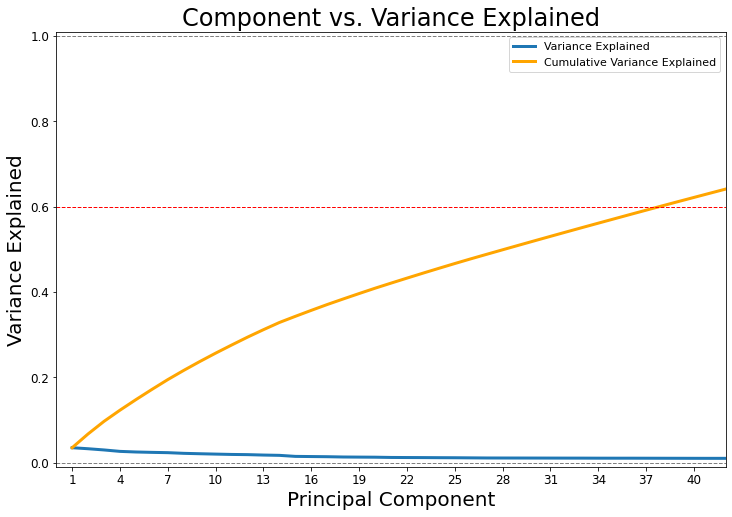

In [387]:
# Plot the variance explained (and cumulative variance explained).

# Set figure size.
plt.figure(figsize=(12,8))

# Plot the explained variance.
plt.plot(range(len(var_exp)), var_exp, lw=3, label = 'Variance Explained')

# Plot the cumulative explained variance.
plt.plot(range(len(var_exp)), cum_var_exp, lw=3, color = 'orange', label = 'Cumulative Variance Explained')

# Add horizontal lines at y=0 and y=1.
plt.axhline(y=0, linewidth=1, color='grey', ls='dashed')
plt.axhline(y=1, linewidth=1, color='grey', ls='dashed')
plt.axhline(y=0.6, linewidth=1, color='red', ls='dashed')

# Set the limits of the axes.
plt.xlim([-1,41])
plt.ylim([-0.01,1.01])

# Label the axes.
plt.ylabel('Variance Explained', fontsize=20)
plt.xlabel('Principal Component', fontsize=20)

# Make the tick labels bigger
plt.xticks(range(0, 41, 3), range(1, 42, 3), fontsize=12)
plt.yticks(fontsize=12)
    
# Add title and legend.
plt.title('Component vs. Variance Explained', fontsize=24)
plt.legend(fontsize=11);

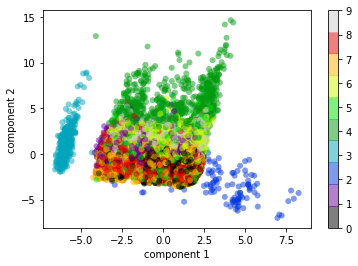

In [394]:
plt.scatter(Z[:, 0], Z[:, 1],
            c=hbp_d_3["kproto_10"], edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

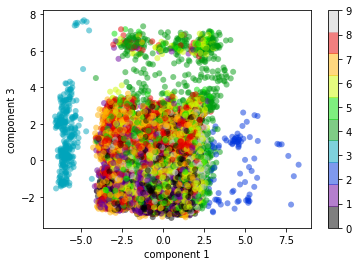

In [395]:
plt.scatter(Z[:, 0], Z[:, 2],
            c=hbp_d_3["kproto_10"], edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 3')
plt.colorbar();

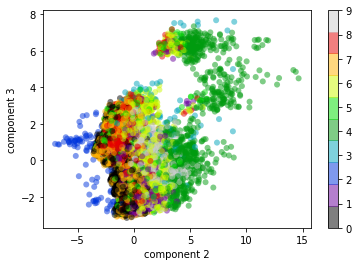

In [396]:
plt.scatter(Z[:, 1], Z[:, 2],
            c=hbp_d_3["kproto_10"], edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.xlabel('component 2')
plt.ylabel('component 3')
plt.colorbar();

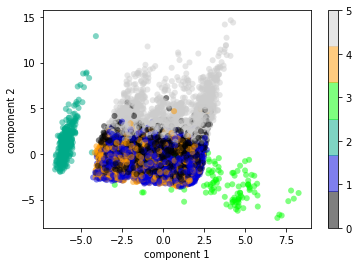

In [446]:
plt.scatter(Z[:, 0], Z[:, 1],
            c=hbp_d_3["kproto_6"], edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('nipy_spectral', 6))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

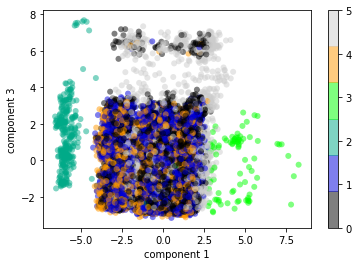

In [447]:
plt.scatter(Z[:, 0], Z[:, 2],
            c=hbp_d_3["kproto_6"], edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('nipy_spectral', 6))
plt.xlabel('component 1')
plt.ylabel('component 3')
plt.colorbar();

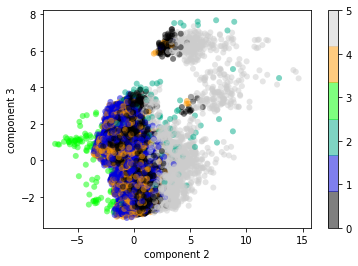

In [448]:
plt.scatter(Z[:, 1], Z[:, 2],
            c=hbp_d_3["kproto_6"], edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('nipy_spectral', 6))
plt.xlabel('component 2')
plt.ylabel('component 3')
plt.colorbar();

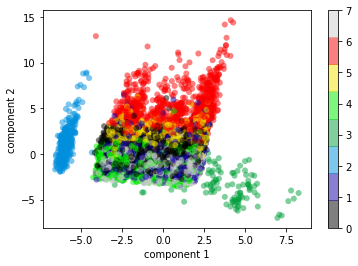

In [449]:
plt.scatter(Z[:, 0], Z[:, 1],
            c=hbp_d_3["kproto_8"], edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('nipy_spectral', 8))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

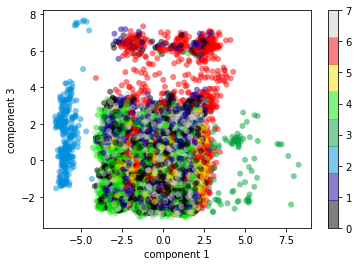

In [450]:
plt.scatter(Z[:, 0], Z[:, 2],
            c=hbp_d_3["kproto_8"], edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('nipy_spectral', 8))
plt.xlabel('component 1')
plt.ylabel('component 3')
plt.colorbar();

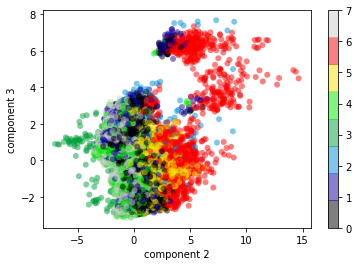

In [451]:
plt.scatter(Z[:, 1], Z[:, 2],
            c=hbp_d_3["kproto_8"], edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('nipy_spectral', 8))
plt.xlabel('component 2')
plt.ylabel('component 3')
plt.colorbar();

# Conclusions & Recommendations